# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from scipy.stats import chi2_contingency, ks_2samp

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load Data and Preprocessing

In [2]:
# Load dataset
df = pd.read_excel("../data/albion_dataset_2024.8.xlsx")

# Filter rows with valid diagnosis and visits
df_cleaned = df[df['DIAGNOSIS'].notna() & (df['DIAGNOSIS'] != 2) & (df['VisitNuA'] != 999)]

# Replace 0 with 1 in IADL columns
iadl_columns = [f'IADL{i}' for i in range(1, 9)]
df_cleaned[iadl_columns] = df_cleaned[iadl_columns].replace(0, 1)

# Function to map CDR values
def map_values(val):
    mapping = {0.0: 0, 0.5: 1, 1.0: 2, 1.5: 3, 2.0: 3, 3.0: 4, 999.0: 999}
    return mapping.get(val, val)

# Apply mapping function to CDR columns
cdr_columns = [f'CDR{i}' for i in range(1, 7)]
df_cleaned[cdr_columns] = df_cleaned[cdr_columns].applymap(map_values)

# Rename column (error)
if 'UODRS3e' in df_cleaned.columns:
    df_cleaned.rename(columns={'UODRS3e': 'UPDRS3e'}, inplace=True)

# Replace invalid values with valid values from other visits
def replace_invalid(group, column):
    valid_values = group[(group[column] != 999) & (~group[column].isna())][column]
    if not valid_values.empty:
        valid_value = valid_values.iloc[0]
        group[column] = group[column].replace(999, valid_value).fillna(valid_value)
    return group

# Apply replacement for MH and FH features
mh_features = [f'MH{i}' for i in range(1, 23)]
fh_features = [f'FH{i}' for i in range(1, 17)]
all_features = mh_features + fh_features
for feature in all_features:
    df_cleaned = df_cleaned.groupby('ID').apply(lambda group: replace_invalid(group, feature)).reset_index(drop=True)

# Last Observation Carried Forward for Marital Status and Living Arrangement
df_cleaned['ΜaritalC'] = df_cleaned.groupby('ID')['ΜaritalC'].fillna(method='ffill')
df_cleaned['Living_Arrangement'] = df_cleaned.groupby('ID')['Living_Arrangement'].fillna(method='ffill')

# List of columns to select
columns = [
    "ID", "SEX", "VisitNuA", "EDU", "AgeC", "ΜaritalC", 
    "Living_Arrangement", "WorkStat", "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", 
    "MH8", "MH9", "MH10", "MH11", "MH12", "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", 
    "MH20", "MH21", "MH22", "SMOKING", "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "NPI_TOT", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "CDR_TOT", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8", "IADL_TOT", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "HACH_TOT", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14", "UPDRS_TOT", "MMSE", "ZME", "ZEX", 
    "ZVS", "ZLA", "ZAS", "DIAGNOSIS"
]

# Select the columns from the dataframe
df_cleaned = df_cleaned[columns]

# Replace specific values in columns (error)
df_cleaned['EDU'] = df_cleaned['EDU'].replace(999, 0)

# Replace 999 with NaN
df_cleaned.replace(999, np.nan, inplace=True)

# Drop columns with excessive missing values
missing_percentage = df_cleaned.isnull().mean() * 100
columns_to_keep = missing_percentage[missing_percentage <= 30].index
df_cleaned = df_cleaned[columns_to_keep]

# Remove rows with excessive missing values per group (ID + VisitNuA)
total_columns = df_cleaned.drop(columns=["ID", "VisitNuA"], errors="ignore").shape[1]
thresh_value = 0.3 * total_columns

group_missing = df_cleaned.groupby(['ID', 'VisitNuA']).apply(lambda x: x.isnull().sum().sum())
to_drop = group_missing[group_missing > thresh_value].index
df_cleaned = df_cleaned[~df_cleaned.set_index(['ID', 'VisitNuA']).index.isin(to_drop)].reset_index(drop=True)

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/127349616.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[iadl_columns] = df_cleaned[iadl_columns].replace(0, 1)
/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/127349616.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned[cdr_columns] = df_cleaned[cdr_columns].applymap(map_values)
/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/127349616.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

# Train and Test Split

In [4]:
# Step 1: Use the first (or most frequent) `DIAGNOSIS` for each patient
id_diagnosis = df_cleaned[['ID', 'DIAGNOSIS']].copy()
id_diagnosis = id_diagnosis.groupby('ID')['DIAGNOSIS'].agg(lambda x: x.mode()[0]).reset_index()

# Step 2: Prepare for stratified splitting
ids = id_diagnosis['ID'].values
diagnoses = id_diagnosis['DIAGNOSIS'].values

# Step 3: Stratified split based on the chosen `DIAGNOSIS`
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in stratified_split.split(ids, diagnoses):
    train_ids = ids[train_index]
    test_ids = ids[test_index]

# Step 4: Assign all visits of a patient to the respective set
train_df = df_cleaned[df_cleaned['ID'].isin(train_ids)]
test_df = df_cleaned[df_cleaned['ID'].isin(test_ids)]

# Step 5: Verify no overlap
overlapping_ids = set(train_df['ID']).intersection(set(test_df['ID']))
if overlapping_ids:
    print(f"Overlapping IDs found: {overlapping_ids}")
else:
    print("No overlapping IDs. Train and test sets are correctly split!")

# Step 6: Print distributions for verification
print("\nTrain DIAGNOSIS distribution:")
print(train_df['DIAGNOSIS'].value_counts(normalize=True))
print("\nTest DIAGNOSIS distribution:")
print(test_df['DIAGNOSIS'].value_counts(normalize=True))

# Final Assertion
assert not overlapping_ids, "Train and test sets have overlapping IDs!"


No overlapping IDs. Train and test sets are correctly split!

Train DIAGNOSIS distribution:
DIAGNOSIS
0.0    0.703349
1.0    0.296651
Name: proportion, dtype: float64

Test DIAGNOSIS distribution:
DIAGNOSIS
0.0    0.722772
1.0    0.277228
Name: proportion, dtype: float64


In [5]:
# Reset the indexes for train and test sets
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [6]:
# Save as baseline datasets
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()
original_stats_train = train_df.describe()
original_stats_test = test_df.describe()

# MICE Implementation

In [7]:
def perform_imputation_and_analysis(train_df, test_df, target_column, impute_columns, n_imputations=10):
    # Step 1: Encode categorical variables as needed for imputation
    train_df_encoded = train_df.copy()
    test_df_encoded = test_df.copy()

    # Replace special missing values in the target column for training and test sets
    for df_encoded in [train_df_encoded, test_df_encoded]:
        if target_column.startswith('IADL'):
            df_encoded[target_column].replace(99, np.nan, inplace=True)
        else:
            print(f"No special replacements for {target_column}, continuing...")

    # Add the target column to the list of impute columns
    if target_column not in impute_columns:
        impute_columns.append(target_column)

    # Select relevant columns for imputation
    impute_train_df = train_df_encoded[impute_columns]
    impute_test_df = test_df_encoded[impute_columns]

    # Step 2: Perform multiple imputations with added noise on the training data
    imputed_train_datasets = []
    for i in range(n_imputations):
        imputer = IterativeImputer(max_iter=10, random_state=i*4, sample_posterior=True)
        imputed_train_data = imputer.fit_transform(impute_train_df)

        # Add small random noise to the imputed values
        noise = np.random.normal(0, 0.2, imputed_train_data.shape)
        imputed_train_data += noise

        imputed_train_df = pd.DataFrame(imputed_train_data, columns=impute_train_df.columns)
        imputed_train_datasets.append(imputed_train_df)

    # Apply the imputation model from the training data to the test set
    imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)
    imputed_test_data = imputer.fit(impute_train_df).transform(impute_test_df)

    # Step 3: Clip and round imputed values for both train and test sets
    for df, imputed_datasets in [(train_df, imputed_train_datasets), (test_df, [pd.DataFrame(imputed_test_data, columns=impute_test_df.columns)])]:
        # Identify NaNs in the target column of the original dataset
        nan_indices = df.index[df[target_column].isna()].tolist()

        # Collect imputed values for NaNs and calculate the mean of the imputed values for each NaN
        imputed_values = []
        for imputed_df in imputed_datasets:
            imputed_values.append(imputed_df.loc[nan_indices, target_column])
        imputed_values_df = pd.DataFrame(imputed_values).transpose()
        imputed_means = imputed_values_df.mean(axis=1).round()

        # Clip imputed values within the original column's min and max values
        min_value = df[target_column].min()
        max_value = df[target_column].max()
        imputed_means = imputed_means.clip(lower=min_value, upper=max_value)

        # Replace negative zeros with positive zeros
        imputed_means[imputed_means == -0] = 0

        # Save original values before imputation
        original_values = df.copy()
        
        print(f"Imputed Values for {target_column} in {'training' if df is train_df else 'test'} set:")
        print(imputed_means)

        # Replace NaNs in the original dataset with the imputed values
        df.loc[nan_indices, target_column] = imputed_means

    # Perform analysis on the imputed training data
    results = []
    for imputed_train_df in imputed_train_datasets:
        X = imputed_train_df.drop(columns=[target_column])
        y = imputed_train_df[target_column]
        model = LinearRegression()
        model.fit(X, y)
        results.append(model.coef_)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Pooling Phase Using Rubin's Rules
    mean_coefficients = results_df.mean(axis=0)
    within_var = results_df.var(axis=0, ddof=1)
    between_var = results_df.mean(axis=0).var(ddof=1)
    total_var = within_var + (1 + 1 / n_imputations) * between_var
    se = np.sqrt(total_var)

    pooled_results = pd.DataFrame({
        'Coefficient': mean_coefficients,
        'Standard Error': se
    })

    return train_df, test_df, pooled_results

In [8]:
def perform_imputation_and_analysis_unrounded(train_df, test_df, target_column, impute_columns, n_imputations=10):
    # Step 1: Encode categorical variables as needed for imputation
    train_df_encoded = train_df.copy()
    test_df_encoded = test_df.copy()

    # Add the target column to the list of impute columns
    if target_column not in impute_columns:
        impute_columns.append(target_column)

    # Select relevant columns for imputation
    impute_train_df = train_df_encoded[impute_columns]
    impute_test_df = test_df_encoded[impute_columns]

    # Step 2: Perform multiple imputations with added noise on the training data
    imputed_train_datasets = []
    for i in range(n_imputations):
        imputer = IterativeImputer(max_iter=10, random_state=i*4, sample_posterior=True)
        imputed_train_data = imputer.fit_transform(impute_train_df)

        # Add small random noise to the imputed values
        noise = np.random.normal(0, 0.2, imputed_train_data.shape)
        imputed_train_data += noise

        imputed_train_df = pd.DataFrame(imputed_train_data, columns=impute_train_df.columns)
        imputed_train_datasets.append(imputed_train_df)

    # Apply the imputation model from the training data to the test set
    imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)
    imputed_test_data = imputer.fit(impute_train_df).transform(impute_test_df)

    # Step 3: Clip and round imputed values for both train and test sets
    for df, imputed_datasets in [(train_df, imputed_train_datasets), (test_df, [pd.DataFrame(imputed_test_data, columns=impute_test_df.columns)])]:
        # Identify NaNs in the target column of the original dataset
        nan_indices = df.index[df[target_column].isna()].tolist()

        # Collect imputed values for NaNs and calculate the mean of the imputed values for each NaN
        imputed_values = []
        for imputed_df in imputed_datasets:
            imputed_values.append(imputed_df.loc[nan_indices, target_column])
        imputed_values_df = pd.DataFrame(imputed_values).transpose()
        imputed_means = imputed_values_df.mean(axis=1)

        # Clip imputed values within the original column's min and max values
        min_value = df[target_column].min()
        max_value = df[target_column].max()
        imputed_means = imputed_means.clip(lower=min_value, upper=max_value)

        # Replace negative zeros with positive zeros
        imputed_means[imputed_means == -0] = 0

        # Save original values before imputation
        original_values = df.copy()
        
        print(f"Imputed Values for {target_column} in {'training' if df is train_df else 'test'} set:")
        print(imputed_means)

        # Replace NaNs in the original dataset with the imputed values
        df.loc[nan_indices, target_column] = imputed_means

    # Perform analysis on the imputed training data
    results = []
    for imputed_train_df in imputed_train_datasets:
        X = imputed_train_df.drop(columns=[target_column])
        y = imputed_train_df[target_column]
        model = LinearRegression()
        model.fit(X, y)
        results.append(model.coef_)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Pooling Phase Using Rubin's Rules
    mean_coefficients = results_df.mean(axis=0)
    within_var = results_df.var(axis=0, ddof=1)
    between_var = results_df.mean(axis=0).var(ddof=1)
    total_var = within_var + (1 + 1 / n_imputations) * between_var
    se = np.sqrt(total_var)

    pooled_results = pd.DataFrame({
        'Coefficient': mean_coefficients,
        'Standard Error': se
    })

    return train_df, test_df, pooled_results

In [9]:
def chi_square_test(feature, target):
    data = df_cleaned[[feature, target]].replace(999, np.nan).dropna()
    data = df_cleaned[[feature, target]].replace(99, np.nan).dropna()
    contingency_table = pd.crosstab(data[feature], data[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p, dof, ex

In [10]:
def process_feature(train_df, test_df, feature):
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # Step 1: Calculate correlations between other variables in the training set
    correlation_matrix = train_df_copy.corr()

    # Extract correlations with the feature
    feature_corr = correlation_matrix[feature].drop(feature)

    # Filter correlations above 0.1
    significant_corr = feature_corr[feature_corr.abs() > 0.1]

    # Display significant correlations
    print(f"Significant Correlations with {feature} (|correlation| > 0.1):")
    print(significant_corr)

    # Step 2: Perform chi-square tests on significant features
    chi_square_results = {}
    for sig_feature in significant_corr.index:
        chi2, p, dof, ex = chi_square_test(sig_feature, feature)
        chi_square_results[sig_feature] = {'Chi2': chi2, 'p-value': p}

    # Display chi-square test results
    print(f"\nChi-Squared Test Results for {feature}:")
    for sig_feature, results in chi_square_results.items():
        print(f"{sig_feature}: Chi2: {results['Chi2']}, p-value: {results['p-value']}")

    # Step 3: Perform imputation and analysis on significant features
    impute_columns = significant_corr.index.tolist()

    # Check if impute_columns is empty and print a message if it is
    if not impute_columns:
        print(f"No significant correlations for {feature}. Using all columns for imputation.")
        # Exclude 'ID' from the columns list
        impute_columns = [col for col in train_df_copy.columns if col != 'ID']

    # Perform imputation on both train and test data
    train_df_copy, test_df_copy, pooled_results = perform_imputation_and_analysis(train_df_copy, test_df_copy, feature, impute_columns)

    return train_df_copy, test_df_copy, chi_square_results, pooled_results


In [11]:
def process_feature_unrounded(train_df, test_df, feature):
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # Step 1: Calculate correlations between other variables in the training set
    correlation_matrix = train_df_copy.corr()

    # Extract correlations with the feature
    feature_corr = correlation_matrix[feature].drop(feature)

    # Filter correlations above 0.1
    significant_corr = feature_corr[feature_corr.abs() > 0.1]

    # Display significant correlations
    print(f"Significant Correlations with {feature} (|correlation| > 0.1):")
    print(significant_corr)

    # Step 2: Perform chi-square tests on significant features
    chi_square_results = {}
    for sig_feature in significant_corr.index:
        chi2, p, dof, ex = chi_square_test(sig_feature, feature)
        chi_square_results[sig_feature] = {'Chi2': chi2, 'p-value': p}

    # Display chi-square test results
    print(f"\nChi-Squared Test Results for {feature}:")
    for sig_feature, results in chi_square_results.items():
        print(f"{sig_feature}: Chi2: {results['Chi2']}, p-value: {results['p-value']}")

    # Step 3: Perform imputation and analysis on significant features
    impute_columns = significant_corr.index.tolist()

    # Check if impute_columns is empty and print a message if it is
    if not impute_columns:
        print(f"No significant correlations for {feature}. Using all columns for imputation.")
        # Exclude 'ID' from the columns list
        impute_columns = [col for col in train_df_copy.columns if col != 'ID']

    # Perform imputation on both train and test data
    train_df_copy, test_df_copy, pooled_results = perform_imputation_and_analysis_unrounded(train_df_copy, test_df_copy, feature, impute_columns)

    return train_df_copy, test_df_copy, chi_square_results, pooled_results


# Imputation

In [12]:
# List of target columns to impute
target_columns = ["CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "IADL1", "IADL2", "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8","Living_Arrangement","WorkStat","ΜaritalC", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14"]

for feature in target_columns:
    train_df_copy2, test_df_copy2, chi_square_results, pooled_results = process_feature(train_df_copy, test_df_copy, feature)

    # Update the original train and test data with the imputed feature
    train_df[feature] = train_df_copy2[feature]
    test_df[feature] = test_df_copy2[feature]


Significant Correlations with CDR1 (|correlation| > 0.1):
SEX         -0.113219
EDU         -0.285711
AgeC         0.329815
WorkStat     0.210599
MH6          0.116771
MH7          0.154244
MH8          0.205272
MH9          0.224744
MH19         0.140638
MH20         0.179517
MH21         0.116597
MED1         0.239747
MED2         0.166386
MED4         0.212188
MED5         0.147462
MED7         0.150406
MED9         0.133472
MED10        0.225895
MED11        0.190012
MED12        0.206064
MED13        0.117991
MED15        0.118005
MED22        0.112179
MED23        0.238350
FH8         -0.122502
NPI7         0.117679
NPI9         0.170792
NPI11        0.170788
NPI_TOT      0.124762
CDR2         0.185324
CDR3         0.307507
CDR4         0.341354
CDR5         0.195160
CDR_TOT      0.781070
IADL1        0.117145
IADL2        0.194128
IADL3        0.189448
IADL4        0.217464
IADL5        0.192905
IADL6        0.193323
IADL7        0.134915
IADL_TOT    -0.103859
HACH5        0.192

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/565025255.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL1 in training set:
35     1.0
39     1.0
75     1.0
95     1.0
117    1.0
198    1.0
242    1.0
247    1.0
256    1.0
334    1.0
dtype: float64
Imputed Values for IADL1 in test set:
1     1.0
32    1.0
75    1.0
83    1.0
84    1.0
dtype: float64
Significant Correlations with IADL2 (|correlation| > 0.1):
AgeC         0.154935
MH6          0.402464
MH10         0.157852
MH21         0.122153
MED1         0.171353
MED3         0.151744
MED4         0.138304
MED7         0.128582
MED10        0.136302
MED19        0.231742
NPI9         0.196949
CDR1         0.194128
CDR2         0.590943
CDR3         0.418433
CDR4         0.460172
CDR5         0.496220
CDR6         0.666209
CDR_TOT      0.458682
IADL1        0.852277
IADL3        0.183389
IADL4        0.186444
IADL5        0.159466
IADL6        0.801659
IADL7        0.703095
IADL8        0.248145
IADL_TOT     0.489457
UPDRS4a      0.168553
UPDRS4b      0.348876
UPDRS8a      0.469280
UPDRS8b      0.264482
UPDRS13    

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/565025255.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL2 in training set:
35     1.0
39     1.0
75     1.0
95     1.0
117    1.0
198    1.0
242    1.0
247    1.0
256    1.0
334    1.0
dtype: float64
Imputed Values for IADL2 in test set:
1     1.0
32    1.0
75    1.0
83    1.0
84    1.0
dtype: float64
Significant Correlations with IADL3 (|correlation| > 0.1):
SEX         -0.418697
AgeC         0.192089
ΜaritalC    -0.134037
MH2         -0.105236
MH3          0.104985
MH6          0.152661
MH10         0.129812
MH16         0.133874
MH20         0.193525
MED7         0.113024
MED11        0.139991
MED18        0.202966
NPI1         0.149573
NPI7         0.149573
NPI9         0.140270
CDR1         0.189448
CDR2         0.103867
CDR4         0.154142
CDR5         0.135411
CDR6         0.142292
CDR_TOT      0.175729
IADL1        0.164631
IADL2        0.183389
IADL4        0.835852
IADL5        0.822837
IADL6        0.158765
IADL7        0.223914
IADL_TOT    -0.580708
HACH5        0.123888
UPDRS8a      0.145742
ZME        

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/565025255.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL3 in training set:
31     1.0
32     1.0
35     1.0
39     1.0
44     1.0
75     1.0
95     1.0
117    1.0
150    1.0
198    1.0
242    1.0
247    1.0
256    1.0
334    1.0
dtype: float64
Imputed Values for IADL3 in test set:
1     1.0
32    1.0
75    1.0
83    1.0
84    1.0
dtype: float64
Significant Correlations with IADL4 (|correlation| > 0.1):
SEX                  -0.414731
AgeC                  0.162592
ΜaritalC             -0.132560
Living_Arrangement    0.133865
MH2                  -0.102525
MH3                   0.107348
MH6                   0.154800
MH10                  0.132522
MH16                  0.136140
MH20                  0.198086
MED2                  0.130323
MED3                  0.104054
MED7                  0.117894
MED11                 0.165327
MED18                 0.174434
MED23                 0.138405
NPI1                  0.149548
NPI5                  0.102906
NPI7                  0.149548
NPI9                  0.140406
NPI_TOT

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/565025255.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL4 in training set:
31     1.0
32     1.0
35     1.0
39     1.0
44     1.0
75     1.0
95     1.0
117    1.0
145    1.0
150    1.0
198    1.0
242    1.0
247    1.0
256    1.0
334    1.0
dtype: float64
Imputed Values for IADL4 in test set:
1     1.0
32    1.0
75    1.0
83    1.0
84    1.0
dtype: float64
Significant Correlations with IADL5 (|correlation| > 0.1):
SEX                  -0.483195
AgeC                  0.173255
ΜaritalC             -0.139439
Living_Arrangement    0.161537
MH2                  -0.138787
MH6                   0.133632
MH10                  0.103894
MH16                  0.168257
MH20                  0.183419
MED2                  0.109542
MED11                 0.124389
MED18                 0.264402
MED23                 0.145881
FH9                  -0.107872
NPI1                  0.136444
NPI7                  0.136444
NPI9                  0.120815
CDR1                  0.192905
CDR4                  0.127102
CDR5                  0.115

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/565025255.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL5 in training set:
31     1.0
32     1.0
35     1.0
39     1.0
44     1.0
75     1.0
95     1.0
117    1.0
137    1.0
142    1.0
145    1.0
150    1.0
198    1.0
242    1.0
247    1.0
256    1.0
334    1.0
dtype: float64
Imputed Values for IADL5 in test set:
1     1.0
32    1.0
75    1.0
83    1.0
84    1.0
dtype: float64
Significant Correlations with IADL6 (|correlation| > 0.1):
AgeC         0.145718
MH6          0.409108
MH9          0.120218
MH21         0.125542
MED1         0.174639
MED4         0.161589
MED7         0.108645
MED19        0.537332
NPI1         0.273926
NPI4         0.128677
NPI9         0.149440
NPI_TOT      0.118487
CDR1         0.193323
CDR2         0.571779
CDR3         0.387375
CDR4         0.413475
CDR5         0.480001
CDR6         0.254419
CDR_TOT      0.414385
IADL1        0.702013
IADL2        0.801659
IADL3        0.158765
IADL4        0.161765
IADL5        0.136945
IADL7        0.593240
IADL8        0.555106
IADL_TOT     0.484048


/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/565025255.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL6 in training set:
35     1.0
39     1.0
75     1.0
95     1.0
117    1.0
198    1.0
242    1.0
247    1.0
256    1.0
334    1.0
dtype: float64
Imputed Values for IADL6 in test set:
1     1.0
32    1.0
75    1.0
83    1.0
84    1.0
dtype: float64
Significant Correlations with IADL7 (|correlation| > 0.1):
SEX         -0.112762
AgeC         0.156778
MH6          0.378903
MH10         0.233233
MH16         0.112541
MH19         0.131935
MED1         0.160434
MED3         0.224996
MED7         0.205329
MED11        0.101002
MED12        0.104348
NPI1         0.497991
NPI9         0.153955
CDR1         0.134915
CDR2         0.392366
CDR3         0.345824
CDR4         0.301134
CDR5         0.156527
CDR6         0.444955
CDR_TOT      0.292866
IADL1        0.701540
IADL2        0.703095
IADL3        0.223914
IADL4        0.226986
IADL5        0.196818
IADL6        0.593240
IADL_TOT     0.389506
HACH5        0.106452
UPDRS4b      0.134768
UPDRS8a      0.375272
UPDRS8b    

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/565025255.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL7 in training set:
35     1.0
39     1.0
75     1.0
95     1.0
117    1.0
142    1.0
198    1.0
242    1.0
247    1.0
256    1.0
334    1.0
dtype: float64
Imputed Values for IADL7 in test set:
1     1.0
32    1.0
75    1.0
83    1.0
84    1.0
dtype: float64
Significant Correlations with IADL8 (|correlation| > 0.1):
MH18         0.201620
MH21         0.102281
MED19        0.999437
MED25        0.196914
CDR2         0.449143
CDR3         0.263726
CDR4         0.239767
CDR5         0.378532
CDR_TOT      0.256835
IADL2        0.248145
IADL6        0.555106
IADL_TOT     0.147894
UPDRS4a      0.754945
UPDRS4b      0.754945
UPDRS_TOT    0.139887
ZAS         -0.238352
Name: IADL8, dtype: float64

Chi-Squared Test Results for IADL8:
MH18: Chi2: 0.5634706451448648, p-value: 0.7544733501739217
MH21: Chi2: 0.2486739292703101, p-value: 0.8830822232630868
MED19: Chi2: 0.0, p-value: 1.0
MED25: Chi2: 3.1902638118990754, p-value: 0.202881765425566
CDR2: Chi2: 82.47965172414636, p

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_93400/565025255.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL8 in training set:
35     1.0
39     2.0
75     1.0
95     1.0
117    1.0
198    1.0
242    1.0
247    1.0
256    1.0
334    1.0
dtype: float64
Imputed Values for IADL8 in test set:
1     1.0
32    1.0
75    1.0
83    1.0
84    1.0
dtype: float64
Significant Correlations with Living_Arrangement (|correlation| > 0.1):
SEX         -0.152067
ΜaritalC    -0.322188
MH18        -0.100713
MH20        -0.108956
MED8        -0.242648
MED10       -0.125021
MED12       -0.105403
MED13       -0.107608
MED15       -0.128880
MED21       -0.168526
NPI4         0.112468
NPI9         0.109197
NPI_TOT      0.113857
IADL4        0.133865
IADL5        0.161537
IADL_TOT    -0.162275
UPDRS1      -0.136110
UPDRS2      -0.159926
UPDRS5c     -0.155484
UPDRS6b     -0.158827
UPDRS7b     -0.134630
UPDRS8b     -0.100700
UPDRS9b     -0.100700
UPDRS10     -0.100479
UPDRS12     -0.213723
UPDRS14     -0.121653
UPDRS_TOT   -0.132870
MMSE        -0.142836
Name: Living_Arrangement, dtype: float64



In [13]:
# List of target columns to impute
target_columns = ["MMSE", "ZME", "ZEX", "ZVS", "ZLA", "ZAS"]

for feature in target_columns:
    train_df_copy2, test_df_copy2, chi_square_results, pooled_results = process_feature_unrounded(train_df_copy, test_df_copy, feature)

    # Update the original train and test data with the imputed feature
    train_df[feature] = train_df_copy2[feature]
    test_df[feature] = test_df_copy2[feature]

Significant Correlations with MMSE (|correlation| > 0.1):
EDU                   0.344221
AgeC                 -0.300399
Living_Arrangement   -0.142836
WorkStat             -0.198433
MH2                  -0.108264
MH6                  -0.116089
MH7                  -0.120377
MH8                  -0.119156
MED1                 -0.242818
MED4                 -0.254631
MED5                 -0.128092
MED9                 -0.101040
MED10                -0.198466
MED11                -0.103474
MED13                -0.141380
MED23                -0.302413
MED24                -0.170377
MED25                -0.133732
FH8                   0.151375
NPI4                 -0.124571
NPI5                 -0.177166
NPI9                 -0.217543
NPI_TOT              -0.220093
CDR1                 -0.575429
CDR3                 -0.129604
CDR4                 -0.172398
CDR5                 -0.134944
CDR_TOT              -0.428225
IADL1                -0.147552
IADL2                -0.182883
IADL5       

# Post-Imputation Data Refinement

In [15]:
# Function to map CDR values back
def map_values(val):
    mapping = {
        0.0: 0,
        1: 0.5,
        2: 1,
        3: 2,
        4: 3,
        999.0: 999
    }
    return mapping.get(val, val)

# Define lists of columns
cdr_columns = [f'CDR{i}' for i in range(1, 7)]
npi_columns = [f'NPI{i}' for i in range(1, 13)]
iadl_columns = [f'IADL{i}' for i in range(1, 9)]
hach_columns = [f'HACH{i}' for i in range(1, 9)]
updrs_columns = [
    "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", "UPDRS3d", "UPDRS3e",
    "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e",
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b",
    "UPDRS10", "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14"
]

# Apply mapping function to CDR columns in train_df and test_df
for col in cdr_columns:
    train_df[col] = train_df[col].apply(map_values)
    test_df[col] = test_df[col].apply(map_values)

# Calculate total scores for each dataset
score_columns = {
    'CDR_TOT': cdr_columns,
    'NPI_TOT': npi_columns,
    'IADL_TOT': iadl_columns,
    'HACH_TOT': hach_columns,
    'UPDRS_TOT': updrs_columns
}

for score_col, columns in score_columns.items():
    if score_col == 'IADL_TOT':
        train_df[score_col] = train_df[columns].replace(99, np.nan).sum(axis=1)
        test_df[score_col] = test_df[columns].replace(99, np.nan).sum(axis=1)
    else:
        train_df[score_col] = train_df[columns].sum(axis=1)
        test_df[score_col] = test_df[columns].sum(axis=1)

# Save the refined datasets to CSV
train_df.to_csv('../data/train_df_imputed_allvisit.csv', index=False)
test_df.to_csv('../data/test_df_imputed_allvisit.csv', index=False)


# Data Comparison: Pre- and Post-Imputation

In [17]:
new_stats_train = train_df.describe()
new_stats_test = test_df.describe()

In [18]:
original_stats_test

,ID,SEX,VisitNuA,EDU,AgeC,ΜaritalC,Living_Arrangement,WorkStat,MH1,MH2,MH3,MH4,MH5,MH6,MH7,MH8,MH9,MH10,MH11,MH12,MH13,MH14,MH15,MH16,MH17,MH18,MH19,MH20,MH21,MH22,SMOKING,ALCOHOL,MED1,MED2,MED3,MED4,MED5,MED6,MED7,MED8,MED9,MED10,MED11,MED12,MED13,MED14,MED15,MED16,MED17,MED18,MED19,MED20,MED21,MED22,MED23,MED24,MED25,MED26,FH5,FH6,FH7,FH8,FH9,FH10,FH11,FH12,FH13,FH14,FH15,FH16,NPI1,NPI2,NPI3,NPI4,NPI5,NPI6,NPI7,NPI8,NPI9,NPI10,NPI11,NPI12,NPI_TOT,CDR1,CDR2,CDR3,CDR4,CDR5,CDR6,CDR_TOT,IADL1,IADL2,IADL3,IADL4,IADL5,IADL6,IADL7,IADL8,IADL_TOT,HACH1,HACH2,HACH3,HACH4,HACH5,HACH6,HACH7,HACH8,HACH_TOT,UPDRS1,UPDRS2,UPDRS3a,UPDRS3b,UPDRS3c,UPDRS3d,UPDRS3e,UPDRS4a,UPDRS4b,UPDRS5a,UPDRS5b,UPDRS5c,UPDRS5d,UPDRS5e,UPDRS6a,UPDRS6b,UPDRS7a,UPDRS7b,UPDRS8a,UPDRS8b,UPDRS9a,UPDRS9b,UPDRS10,UPDRS11,UPDRS12,UPDRS13,UPDRS14,UPDRS_TOT,MMSE,ZME,ZEX,ZVS,ZLA,ZAS,DIAGNOSIS
count,101.000000,101.000000,101.000000,101.000000,101.000000,97.000000,9.800000e+01,96.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.000000,101.000000,101.0,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.0,101.0,101.0,101.000000,101.0,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.0,101.0,101.000000,101.0,101.000000,101.000000,100.0,101.0,101.0,101.0,101.000000,101.000000,100.0,90.0,90.0,90.0,90.000000,90.000000,90.0,90.000000,90.000000,90.0,90.0,90.000000,90.000000,90.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.0,99.000000,96.0,96.0,96.000000,96.000000,96.000000,96.000000,96.0,96.000000,96.000000,96.0,96.0,96.0,96.000000,96.000000,96.0,96.0,96.0,96.000000,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,94.0,99.000000,99.000000,95.000000,99.000000,98.000000,99.000000,101.000000
mean,6744.207921,1.742574,1.990099,16.128713,64.613861,1.505155,1.022950e+08,2.281250,0.009901,0.227723,0.029703,0.0,0.009901,0.019802,0.108911,0.287129,0.475248,0.019802,0.0,0.059406,0.039604,0.009901,0.0,0.0,0.009901,0.019802,0.059406,0.029703,0.247525,0.188119,0.613861,0.079208,0.069307,0.0,0.009901,0.405941,0.138614,0.009901,0.287129,0.049505,0.108911,0.079208,0.356436,0.465347,0.257426,0.0,0.0,0.0,0.0,0.029703,0.0,0.009901,0.009901,0.009901,0.009901,0.0,0.079208,0.0,0.0,0.039604,0.0,0.227723,0.089109,0.0,0.0,0.0,0.0,0.287129,0.049505,0.0,0.0,0.0,0.0,0.933333,1.644444,0.0,0.044444,0.022222,0.0,0.0,0.566667,0.088889,3.300000,0.282828,0.050505,0.070707,0.030303,0.020202,0.0,0.232323,1.0,1.0,5.093750,6.114583,7.135417,1.010417,1.0,1.031250,7.916667,0.0,0.0,0.0,0.010417,0.364583,0.0,0.0,0.0,0.375000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.444444,-0.387903,-0.191573,-0.077835,-0.244935,-0.208334,0.277228
std,709.340910,0.439397,1.204118,10.819116,9.475200,0.936791,1.012668e+09,0.902664,0.099504,0.421454,0.170613,0.0,0.099504,0.140014,0.313081,0.454679,0.501878,0.140014,0.0,0.237562,0.196000,0.099504,0.0,0.0,0.099504,0.140014,0.237562,0.170613,0.433727,0.392756,0.848178,0.365600,0.255242,0.0,0.099504,0.493522,0.347267,0.099504,0.454679,0.218002,0.313081,0.271410,0.481335,0.501285,0.439397,0.0,0.0,0.0,0.0,0.170613,0.0,0.099504,0.099504,0.099504,0.099504,0.0,0.271410,0.0,0.0,0.196000,0.0,0.421454,0.286322,0.0,0.0,0.0,0.0,0.454679,0.218002,0.0,0.0,0.0,0.0,1.877124,2.773515,0.0,0.421637,0.210819,0.0,0.0,1.722619,0.592925,4.722526,0.554028,0.262396,0.294595,0.223814,0.201008,0.0,0.693678,0.0,0.0,19.683858,21.887208,23.844063,0.102062,0.0,0.174906,0.803501,0.0,0.0,0.0,0.102062,0.483840,0.0,0.0,0.0,0.486664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.819521,1.134895,0.697099,0.

In [19]:
original_stats_train

,ID,SEX,VisitNuA,EDU,AgeC,ΜaritalC,Living_Arrangement,WorkStat,MH1,MH2,MH3,MH4,MH5,MH6,MH7,MH8,MH9,MH10,MH11,MH12,MH13,MH14,MH15,MH16,MH17,MH18,MH19,MH20,MH21,MH22,SMOKING,ALCOHOL,MED1,MED2,MED3,MED4,MED5,MED6,MED7,MED8,MED9,MED10,MED11,MED12,MED13,MED14,MED15,MED16,MED17,MED18,MED19,MED20,MED21,MED22,MED23,MED24,MED25,MED26,FH5,FH6,FH7,FH8,FH9,FH10,FH11,FH12,FH13,FH14,FH15,FH16,NPI1,NPI2,NPI3,NPI4,NPI5,NPI6,NPI7,NPI8,NPI9,NPI10,NPI11,NPI12,NPI_TOT,CDR1,CDR2,CDR3,CDR4,CDR5,CDR6,CDR_TOT,IADL1,IADL2,IADL3,IADL4,IADL5,IADL6,IADL7,IADL8,IADL_TOT,HACH1,HACH2,HACH3,HACH4,HACH5,HACH6,HACH7,HACH8,HACH_TOT,UPDRS1,UPDRS2,UPDRS3a,UPDRS3b,UPDRS3c,UPDRS3d,UPDRS3e,UPDRS4a,UPDRS4b,UPDRS5a,UPDRS5b,UPDRS5c,UPDRS5d,UPDRS5e,UPDRS6a,UPDRS6b,UPDRS7a,UPDRS7b,UPDRS8a,UPDRS8b,UPDRS9a,UPDRS9b,UPDRS10,UPDRS11,UPDRS12,UPDRS13,UPDRS14,UPDRS_TOT,MMSE,ZME,ZEX,ZVS,ZLA,ZAS,DIAGNOSIS
count,418.000000,418.000000,418.000000,418.000000,418.000000,410.000000,401.000000,403.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,415.000000,415.000000,415.000000,415.000000,415.000000,415.000000,413.000000,413.000000,413.00000,413.000000,413.000000,413.000000,413.000000,413.0,413.000000,413.000000,413.0,413.000000,413.000000,413.0,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,408.0,408.000000,408.0,408.000000,408.000000,404.0,408.0,408.000000,408.0,411.000000,408.000000,405.0,382.000000,382.0,382.0,382.000000,382.000000,382.000000,382.000000,382.0,382.000000,382.0,382.000000,382.0,382.000000,404.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,408.000000,408.000000,404.000000,403.000000,401.000000,408.000000,407.000000,408.000000,408.000000,408.0,408.000000,408.000000,408.000000,408.000000,408.000000,408.0,408.000000,408.000000,392.000000,392.000000,393.0,393.0,393.0,393.0,393.0,393.000000,393.000000,393.0,393.000000,393.000000,393.0,393.0,394.0,394.000000,394.0,394.000000,394.000000,394.000000,394.0,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,410.000000,410.000000,387.000000,410.000000,408.000000,403.000000,418.000000
mean,6650.889952,1.612440,2.100478,13.342105,65.358852,1.268293,0.855362,2.342432,0.028708,0.232057,0.040670,0.007177,0.028708,0.007177,0.102871,0.416268,0.421053,0.038278,0.0,0.047847,0.033493,0.007177,0.0,0.016746,0.002392,0.057416,0.045455,0.083732,0.196172,0.126794,0.698565,0.122010,0.036145,0.009639,0.043373,0.346988,0.132530,0.040964,0.176755,0.016949,0.09201,0.048426,0.430993,0.421308,0.222760,0.0,0.004843,0.002421,0.0,0.070218,0.002421,0.0,0.021792,0.014528,0.041162,0.016949,0.060533,0.004843,0.0,0.014706,0.0,0.191176,0.071078,0.0,0.0,0.002451,0.0,0.323601,0.071078,0.0,0.005236,0.0,0.0,0.657068,0.871728,0.015707,0.015707,0.0,0.102094,0.0,0.376963,0.0,2.044503,0.267327,0.012315,0.039409,0.046798,0.019704,0.002463,0.205665,1.012255,1.024510,11.915842,11.707196,14.443890,1.031863,1.017199,1.262255,7.700980,0.0,0.002451,0.002451,0.007353,0.406863,0.017157,0.0,0.009804,0.446078,0.010204,0.012755,0.0,0.0,0.0,0.0,0.0,0.012723,0.012723,0.0,0.002545,0.017812,0.0,0.0,0.0,0.012690,0.0,0.010152,0.002538,0.007614,0.0,0.007614,0.017766,0.010152,0.012690,0.015228,0.012690,0.177665,28.214634,-0.392453,-0.212715,-0.416093,-0.364014,-0.277692,0.296651
std,766.899027,0.487777,1.282402,4.187477,9.131884,0.737550,0.473315,0.934076,0.167185,0.422651,0.197761,0.084514,0.167185,0.084514,0.304154,0.493530,0.494320,0.192095,0.0,0.213698,0.180135,0.084514,0.0,0.128474,0.048912,0.232915,0.208549,0.277317,0.397576,0.333141,0.851038,0.434643,0.186875,0.097820,0.203942,0.476586,0.339475,0.198446,0.381924,0.129237,0.28939,0.214925,0.495816,0.494368,0.416603,0.0,0.069504,0.049207,0.0,0.255824,0.049207,0.0,0.146180,0.119798,0.198906,0.129237,0.238760,0.069504,0.0,0.120521,0.0,0.393710,0.257271,0.0,0.

In [20]:
new_stats_train

,ID,SEX,VisitNuA,EDU,AgeC,ΜaritalC,Living_Arrangement,WorkStat,MH1,MH2,MH3,MH4,MH5,MH6,MH7,MH8,MH9,MH10,MH11,MH12,MH13,MH14,MH15,MH16,MH17,MH18,MH19,MH20,MH21,MH22,SMOKING,ALCOHOL,MED1,MED2,MED3,MED4,MED5,MED6,MED7,MED8,MED9,MED10,MED11,MED12,MED13,MED14,MED15,MED16,MED17,MED18,MED19,MED20,MED21,MED22,MED23,MED24,MED25,MED26,FH5,FH6,FH7,FH8,FH9,FH10,FH11,FH12,FH13,FH14,FH15,FH16,NPI1,NPI2,NPI3,NPI4,NPI5,NPI6,NPI7,NPI8,NPI9,NPI10,NPI11,NPI12,NPI_TOT,CDR1,CDR2,CDR3,CDR4,CDR5,CDR6,CDR_TOT,IADL1,IADL2,IADL3,IADL4,IADL5,IADL6,IADL7,IADL8,IADL_TOT,HACH1,HACH2,HACH3,HACH4,HACH5,HACH6,HACH7,HACH8,HACH_TOT,UPDRS1,UPDRS2,UPDRS3a,UPDRS3b,UPDRS3c,UPDRS3d,UPDRS3e,UPDRS4a,UPDRS4b,UPDRS5a,UPDRS5b,UPDRS5c,UPDRS5d,UPDRS5e,UPDRS6a,UPDRS6b,UPDRS7a,UPDRS7b,UPDRS8a,UPDRS8b,UPDRS9a,UPDRS9b,UPDRS10,UPDRS11,UPDRS12,UPDRS13,UPDRS14,UPDRS_TOT,MMSE,ZME,ZEX,ZVS,ZLA,ZAS,DIAGNOSIS
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.0,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.0,418.000000,418.000000,418.0,418.0,418.000000,418.0,418.000000,418.000000,418.0,418.000000,418.0,418.0,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.0,418.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.0,418.0,418.0,418.0,418.0,418.000000,418.000000,418.0,418.000000,418.000000,418.0,418.0,418.0,418.000000,418.0,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,6650.889952,1.612440,2.100478,13.342105,65.358852,1.275120,0.858852,2.339713,0.028708,0.232057,0.040670,0.007177,0.028708,0.007177,0.102871,0.416268,0.421053,0.038278,0.0,0.047847,0.033493,0.007177,0.0,0.016746,0.002392,0.057416,0.045455,0.083732,0.196172,0.126794,0.698565,0.122010,0.035885,0.009569,0.043062,0.349282,0.131579,0.040670,0.174641,0.016746,0.093301,0.047847,0.430622,0.421053,0.222488,0.0,0.004785,0.002392,0.0,0.069378,0.002392,0.0,0.021531,0.014354,0.040670,0.016746,0.059809,0.004785,0.0,0.014354,0.0,0.188995,0.069378,0.0,0.0,0.002392,0.0,0.325359,0.071770,0.0,0.009569,0.0,0.0,0.681818,0.868421,0.016746,0.014354,0.0,0.122010,0.0,0.394737,0.0,2.107656,0.137560,0.007177,0.020335,0.023923,0.010766,0.001196,0.200957,1.011962,1.023923,11.550239,11.322967,13.897129,1.031100,1.016746,1.258373,7.770335,0.0,0.002392,0.002392,0.007177,0.409091,0.016746,0.0,0.009569,0.447368,0.009569,0.011962,0.0,0.0,0.0,0.0,0.0,0.011962,0.011962,0.0,0.002392,0.016746,0.0,0.0,0.0,0.011962,0.0,0.009569,0.002392,0.007177,0.0,0.007177,0.016746,0.009569,0.011962,0.014354,0.011962,0.167464,28.211629,-0.398638,-0.304576,-0.433075,-0.376704,-0.304477,0.296651
std,766.899027,0.487777,1.282402,4.187477,9.131884,0.735143,0.466304,0.923658,0.167185,0.422651,0.197761,0.084514,0.167185,0.084514,0.304154,0.493530,0.494320,0.192095,0.0,0.213698,0.180135,0.084514,0.0,0.128474,0.048912,0.232915,0.208549,0.277317,0.397576,0.333141,0.851038,0.434643,0.186227,0.097471,0.203240,0.477315,0.338438,0.197761,0.380115,0.128474,0.291203,0.213698,0.495757,0.494320,0.416416,0.0,0.069088,0.048912,0.0,0.254400,0.048912,0.0,0.145320,0.119088,0.197761,0.128474,0.237416,0.069088,0.0,0.119088,0.0,0.391974,0.254400,0.0

In [21]:
new_stats_test

,ID,SEX,VisitNuA,EDU,AgeC,ΜaritalC,Living_Arrangement,WorkStat,MH1,MH2,MH3,MH4,MH5,MH6,MH7,MH8,MH9,MH10,MH11,MH12,MH13,MH14,MH15,MH16,MH17,MH18,MH19,MH20,MH21,MH22,SMOKING,ALCOHOL,MED1,MED2,MED3,MED4,MED5,MED6,MED7,MED8,MED9,MED10,MED11,MED12,MED13,MED14,MED15,MED16,MED17,MED18,MED19,MED20,MED21,MED22,MED23,MED24,MED25,MED26,FH5,FH6,FH7,FH8,FH9,FH10,FH11,FH12,FH13,FH14,FH15,FH16,NPI1,NPI2,NPI3,NPI4,NPI5,NPI6,NPI7,NPI8,NPI9,NPI10,NPI11,NPI12,NPI_TOT,CDR1,CDR2,CDR3,CDR4,CDR5,CDR6,CDR_TOT,IADL1,IADL2,IADL3,IADL4,IADL5,IADL6,IADL7,IADL8,IADL_TOT,HACH1,HACH2,HACH3,HACH4,HACH5,HACH6,HACH7,HACH8,HACH_TOT,UPDRS1,UPDRS2,UPDRS3a,UPDRS3b,UPDRS3c,UPDRS3d,UPDRS3e,UPDRS4a,UPDRS4b,UPDRS5a,UPDRS5b,UPDRS5c,UPDRS5d,UPDRS5e,UPDRS6a,UPDRS6b,UPDRS7a,UPDRS7b,UPDRS8a,UPDRS8b,UPDRS9a,UPDRS9b,UPDRS10,UPDRS11,UPDRS12,UPDRS13,UPDRS14,UPDRS_TOT,MMSE,ZME,ZEX,ZVS,ZLA,ZAS,DIAGNOSIS
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,1.010000e+02,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.000000,101.000000,101.0,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.0,101.0,101.0,101.000000,101.0,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.0,101.0,101.000000,101.0,101.000000,101.000000,101.0,101.0,101.0,101.0,101.000000,101.000000,101.0,101.0,101.0,101.0,101.000000,101.000000,101.0,101.000000,101.000000,101.0,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.0,101.0,101.000000,101.000000,101.000000,101.000000,101.0,101.000000,101.000000,101.0,101.0,101.0,101.000000,101.000000,101.0,101.0,101.0,101.000000,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,6744.207921,1.742574,1.990099,16.128713,64.613861,1.475248,9.925650e+07,2.257426,0.009901,0.227723,0.029703,0.0,0.009901,0.019802,0.108911,0.287129,0.475248,0.019802,0.0,0.059406,0.039604,0.009901,0.0,0.0,0.009901,0.019802,0.059406,0.029703,0.247525,0.188119,0.613861,0.079208,0.069307,0.0,0.009901,0.405941,0.138614,0.009901,0.287129,0.049505,0.108911,0.079208,0.356436,0.465347,0.257426,0.0,0.0,0.0,0.0,0.029703,0.0,0.009901,0.009901,0.009901,0.009901,0.0,0.079208,0.0,0.0,0.039604,0.0,0.227723,0.089109,0.0,0.0,0.0,0.0,0.287129,0.049505,0.0,0.0,0.0,0.0,0.851485,1.603960,0.0,0.039604,0.019802,0.0,0.0,0.554455,0.079208,3.148515,0.148515,0.024752,0.034653,0.014851,0.009901,0.0,0.232673,1.0,1.0,4.891089,5.861386,6.831683,1.009901,1.0,1.029703,7.920792,0.0,0.0,0.0,0.009901,0.356436,0.0,0.0,0.0,0.366337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.408078,-0.400793,-0.230537,-0.074602,-0.253604,-0.228587,0.277228
std,709.340910,0.439397,1.204118,10.819116,9.475200,0.933746,9.975155e+08,0.901704,0.099504,0.421454,0.170613,0.0,0.099504,0.140014,0.313081,0.454679,0.501878,0.140014,0.0,0.237562,0.196000,0.099504,0.0,0.0,0.099504,0.140014,0.237562,0.170613,0.433727,0.392756,0.848178,0.365600,0.255242,0.0,0.099504,0.493522,0.347267,0.099504,0.454679,0.218002,0.313081,0.271410,0.481335,0.501285,0.439397,0.0,0.0,0.0,0.0,0.170613,0.0,0.099504,0.099504,0.099504,0.099504,0.0,0.271410,0.0,0.0,0.196000,0.0,0.421454,0.286322,0.0,0.0,0.0,0.0,0.454679,0.218002,0.0,0.0,0.0,0.0,1.791012,2.661125,0.0,0.398015,0.199007,0.0,0.0,1.639971,0.560057,4.501969,0.304504,0.129928,0.145901,0.110803,0.099504,0.0,0.687620,0.0,0.0,19.206197,21.362130,23.278775,0.099504,0.0,0.170613,0.783367,0.0,0.0,0.0,0.099504,0.481335,0.0,0.0,0.0,0.484206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

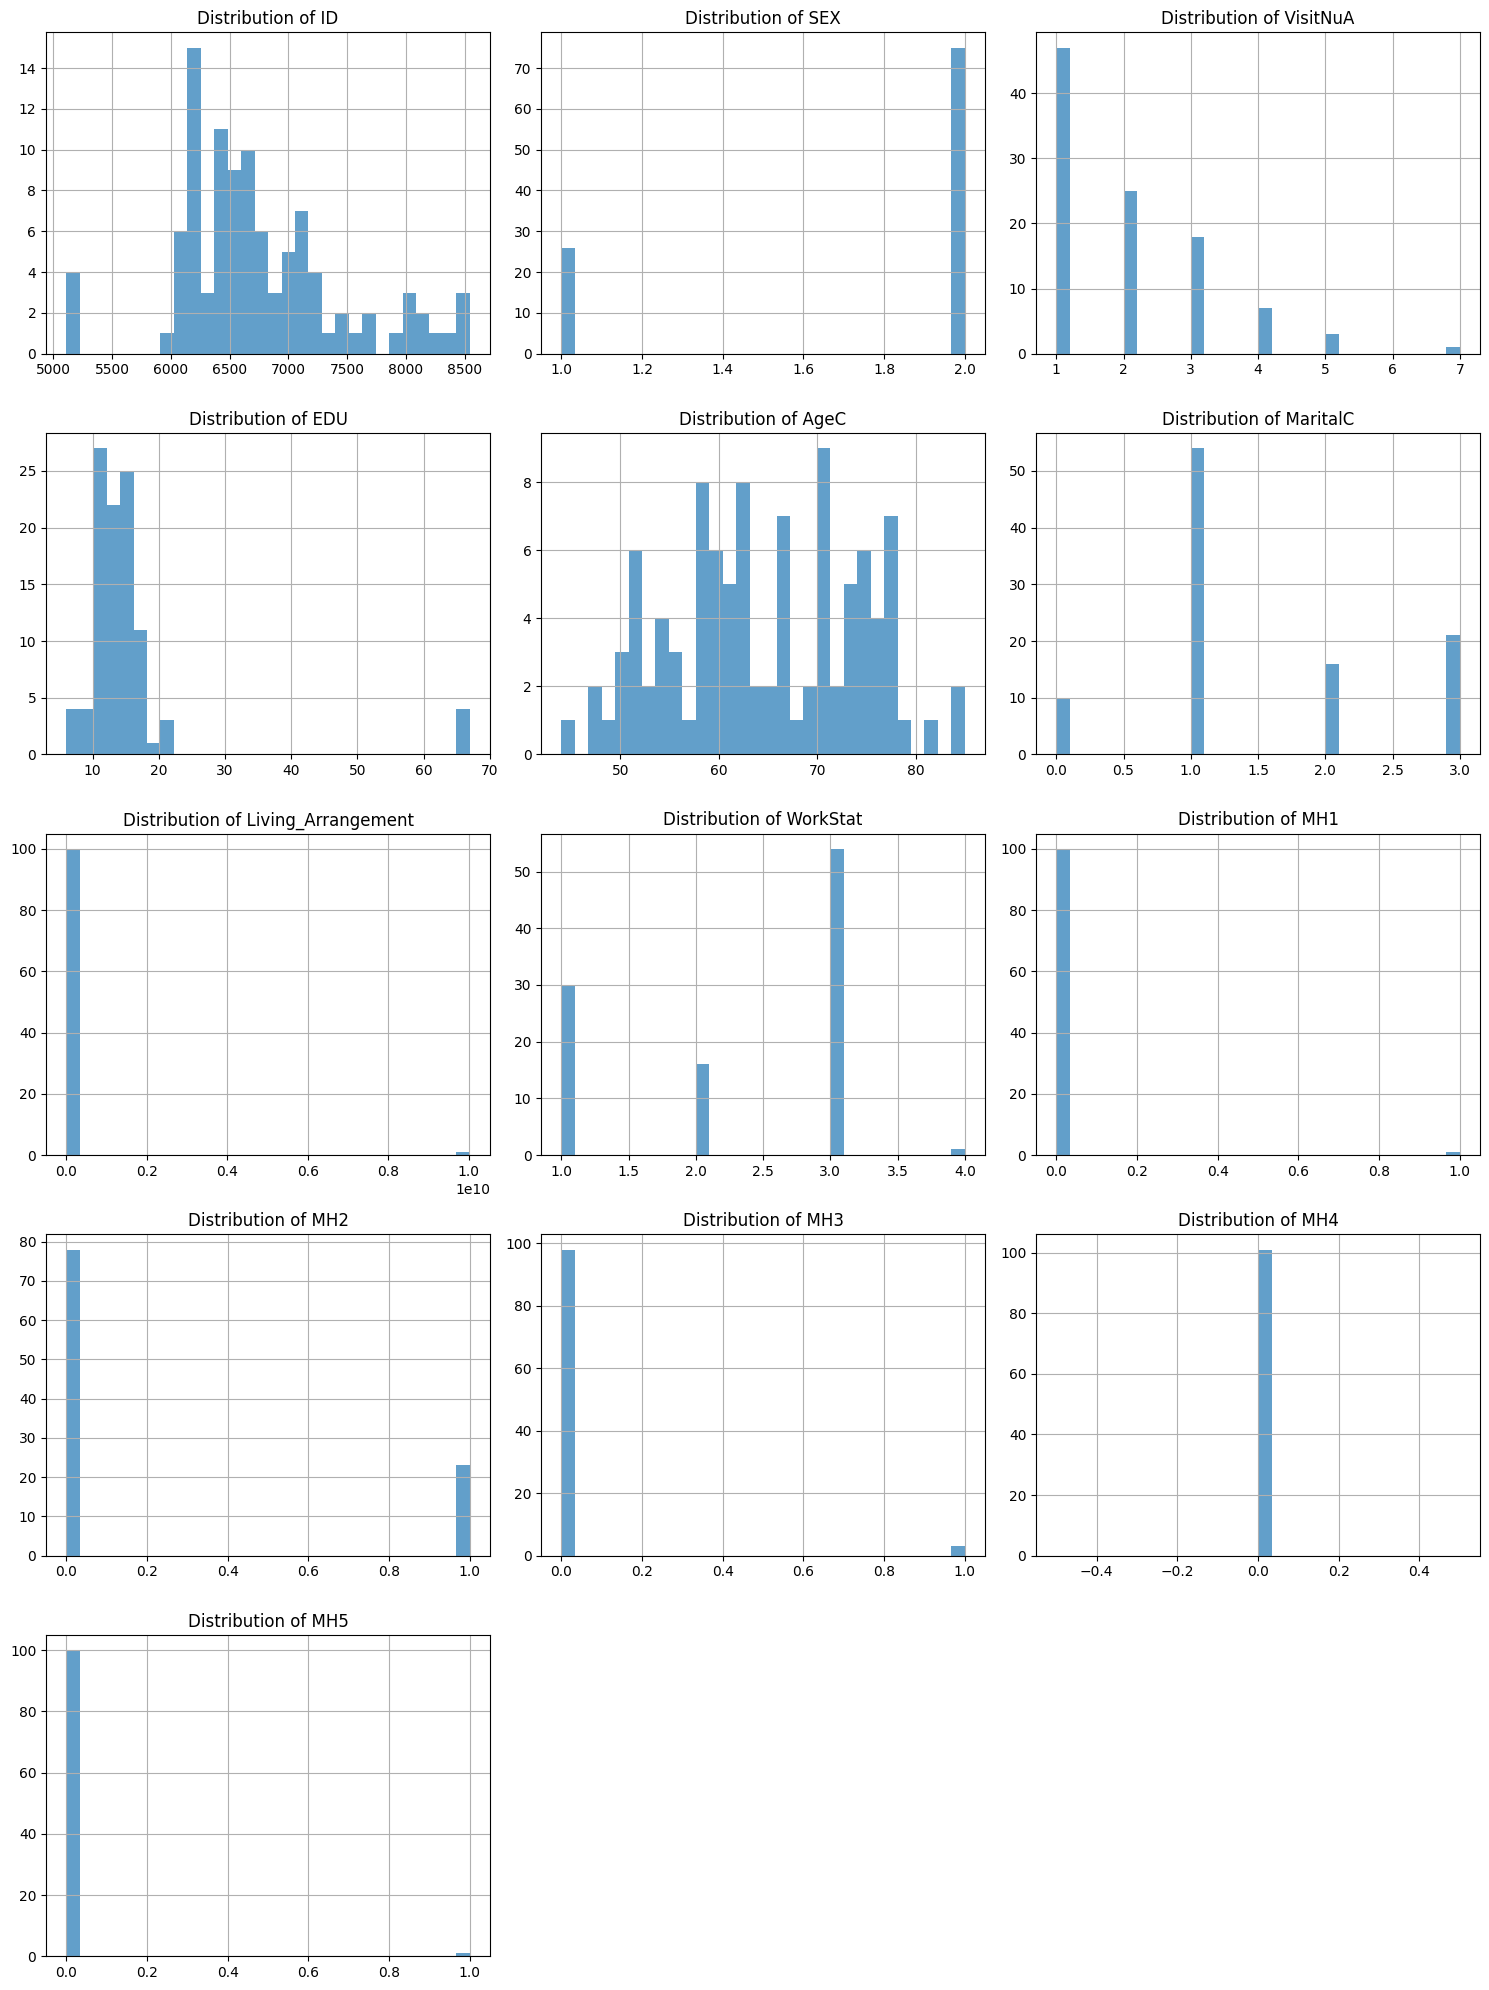

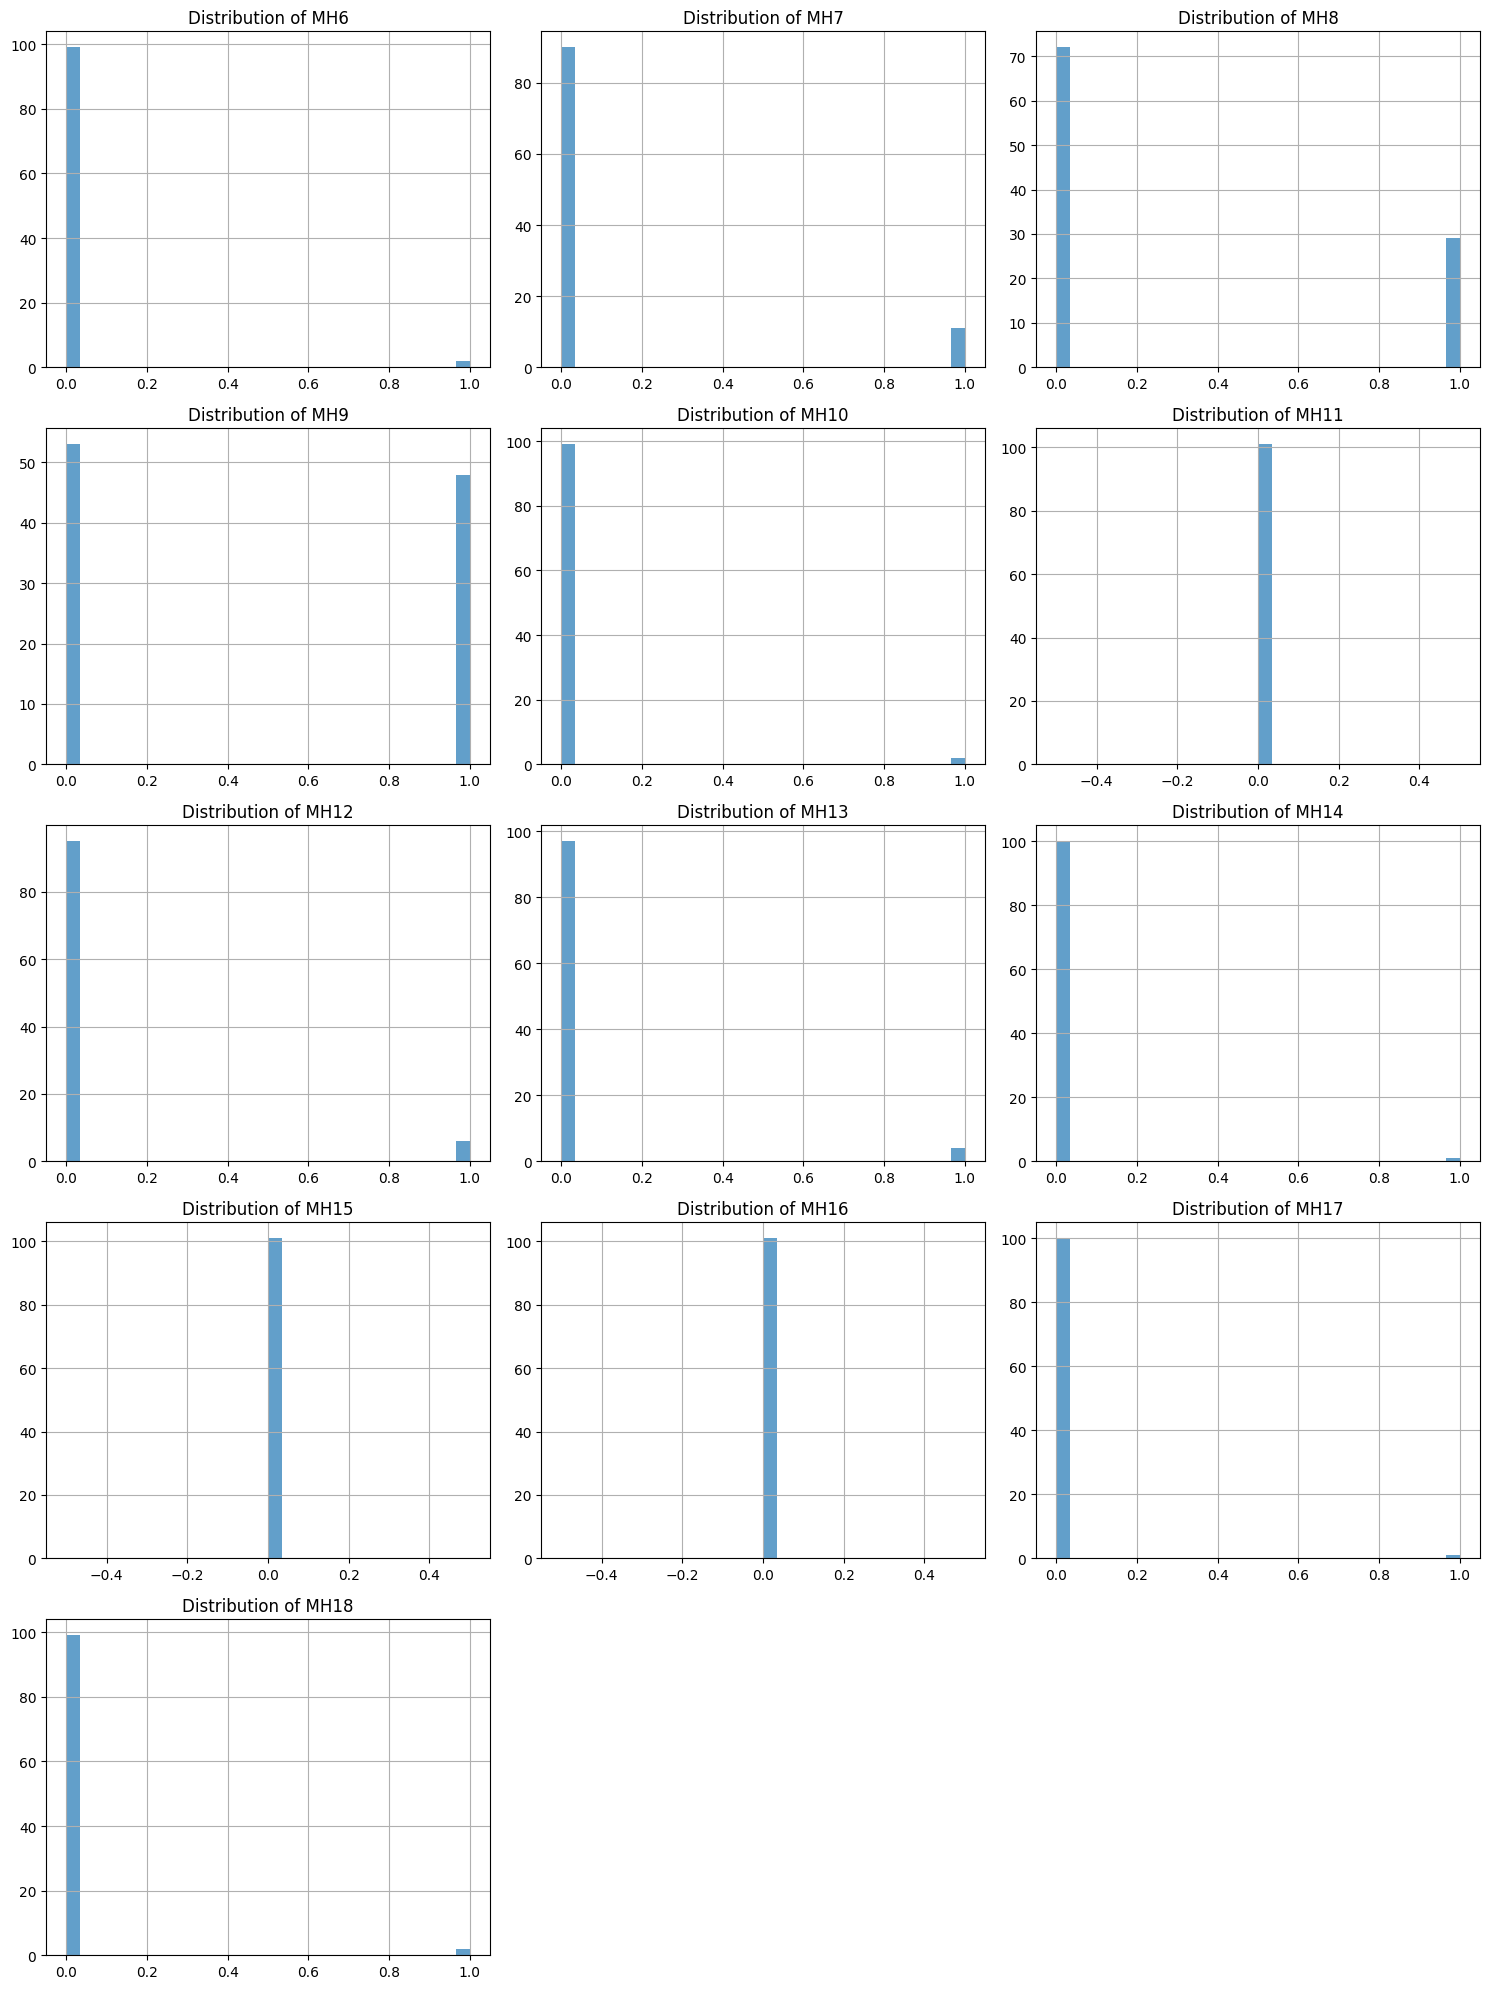

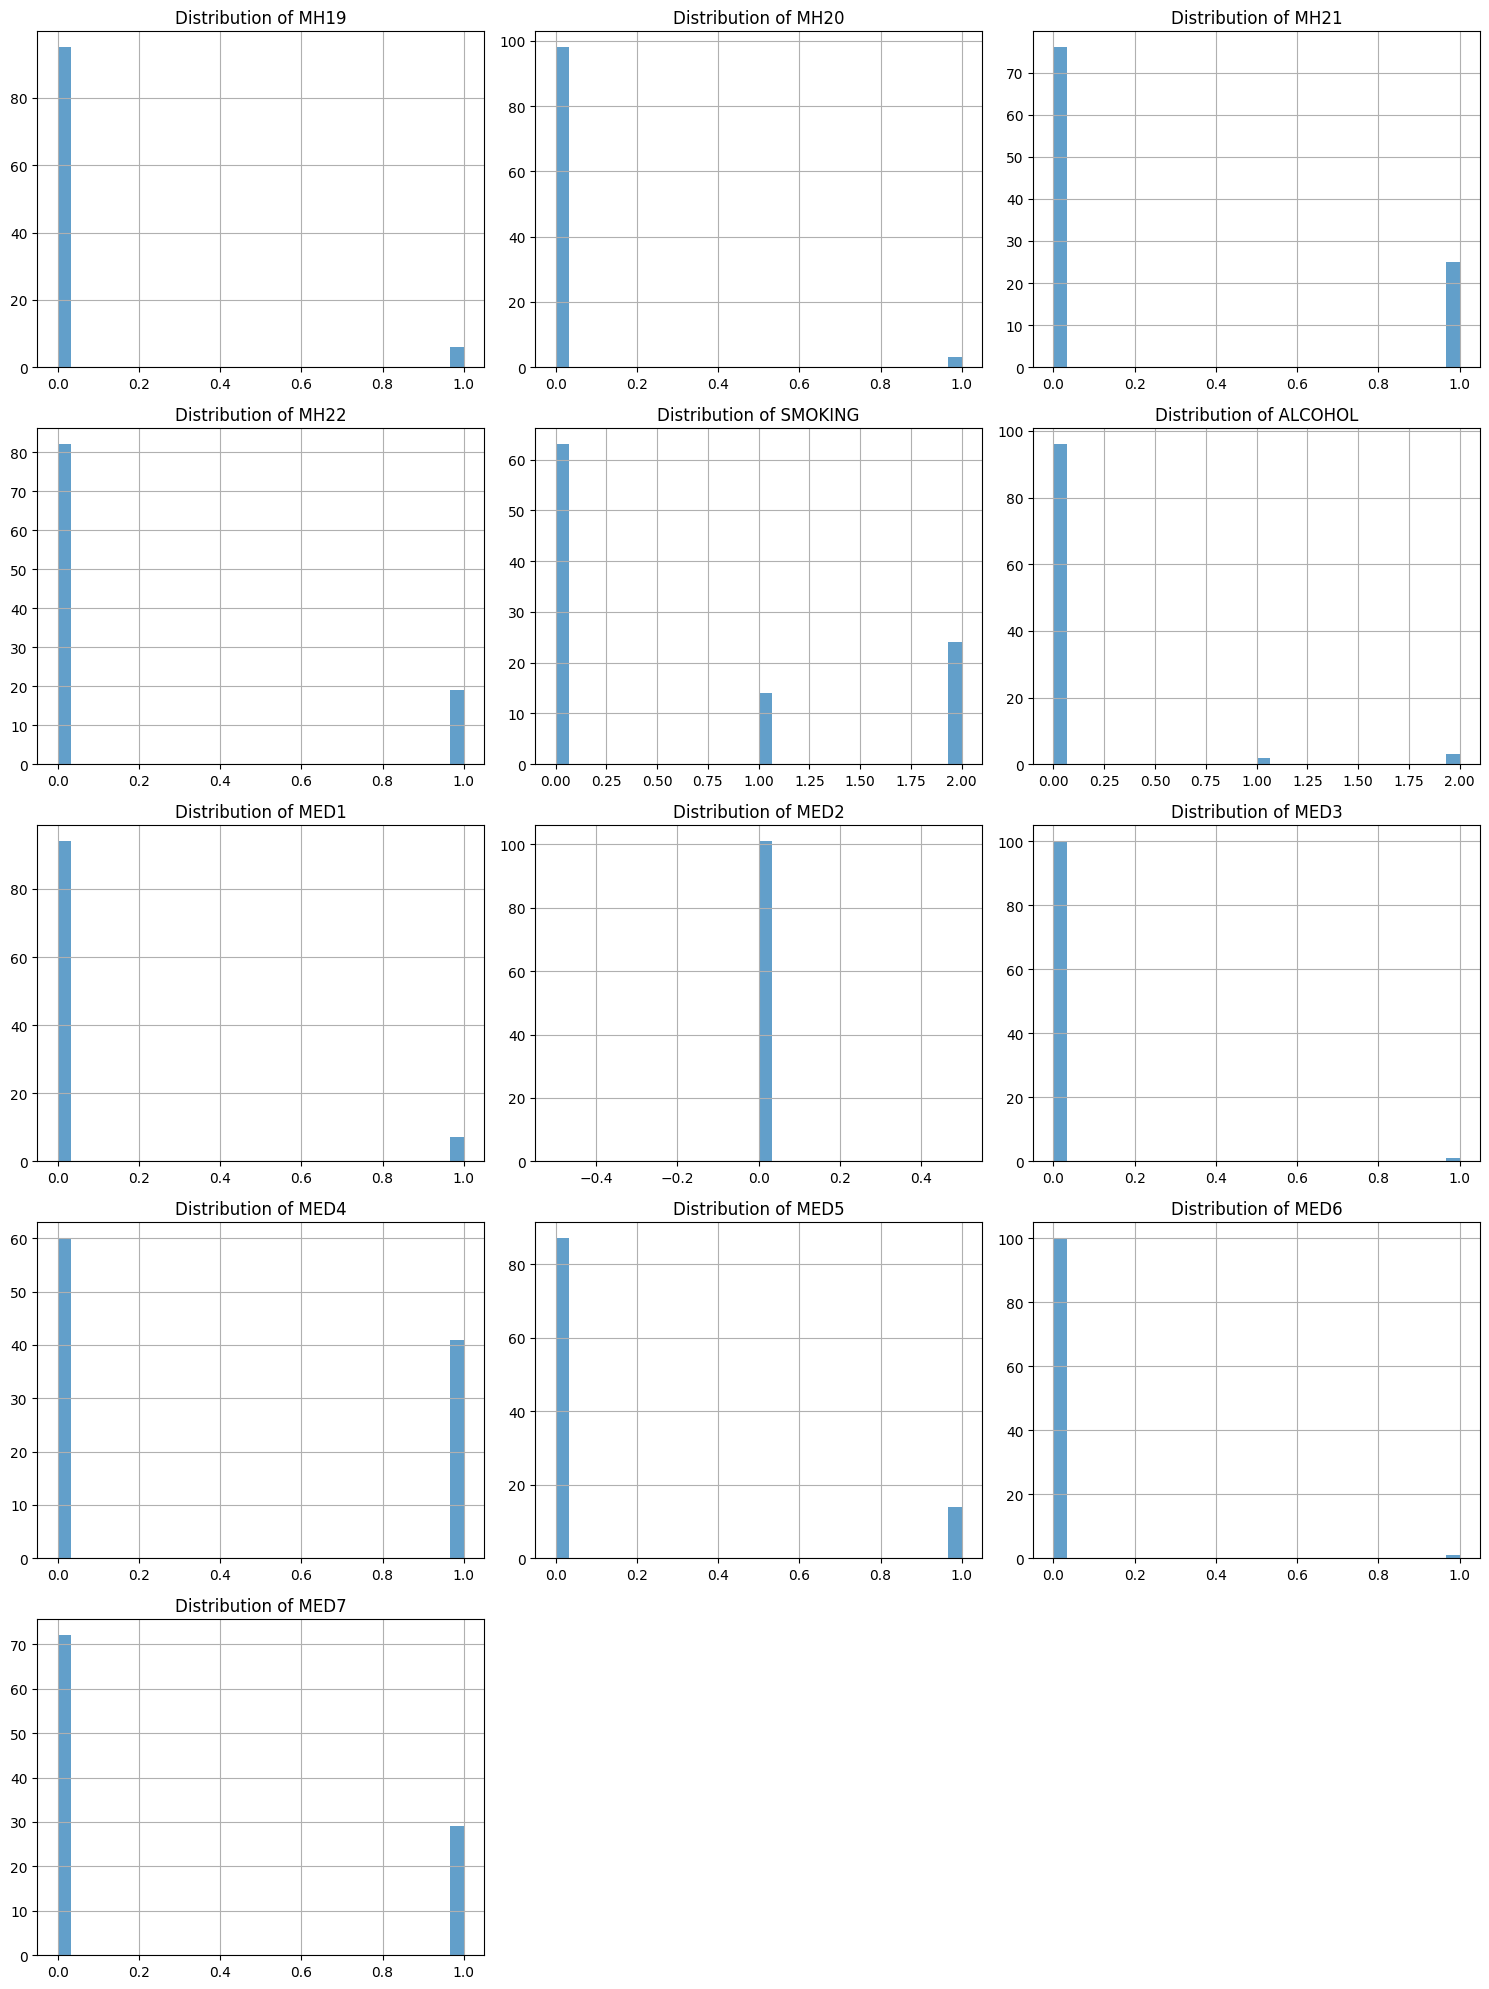

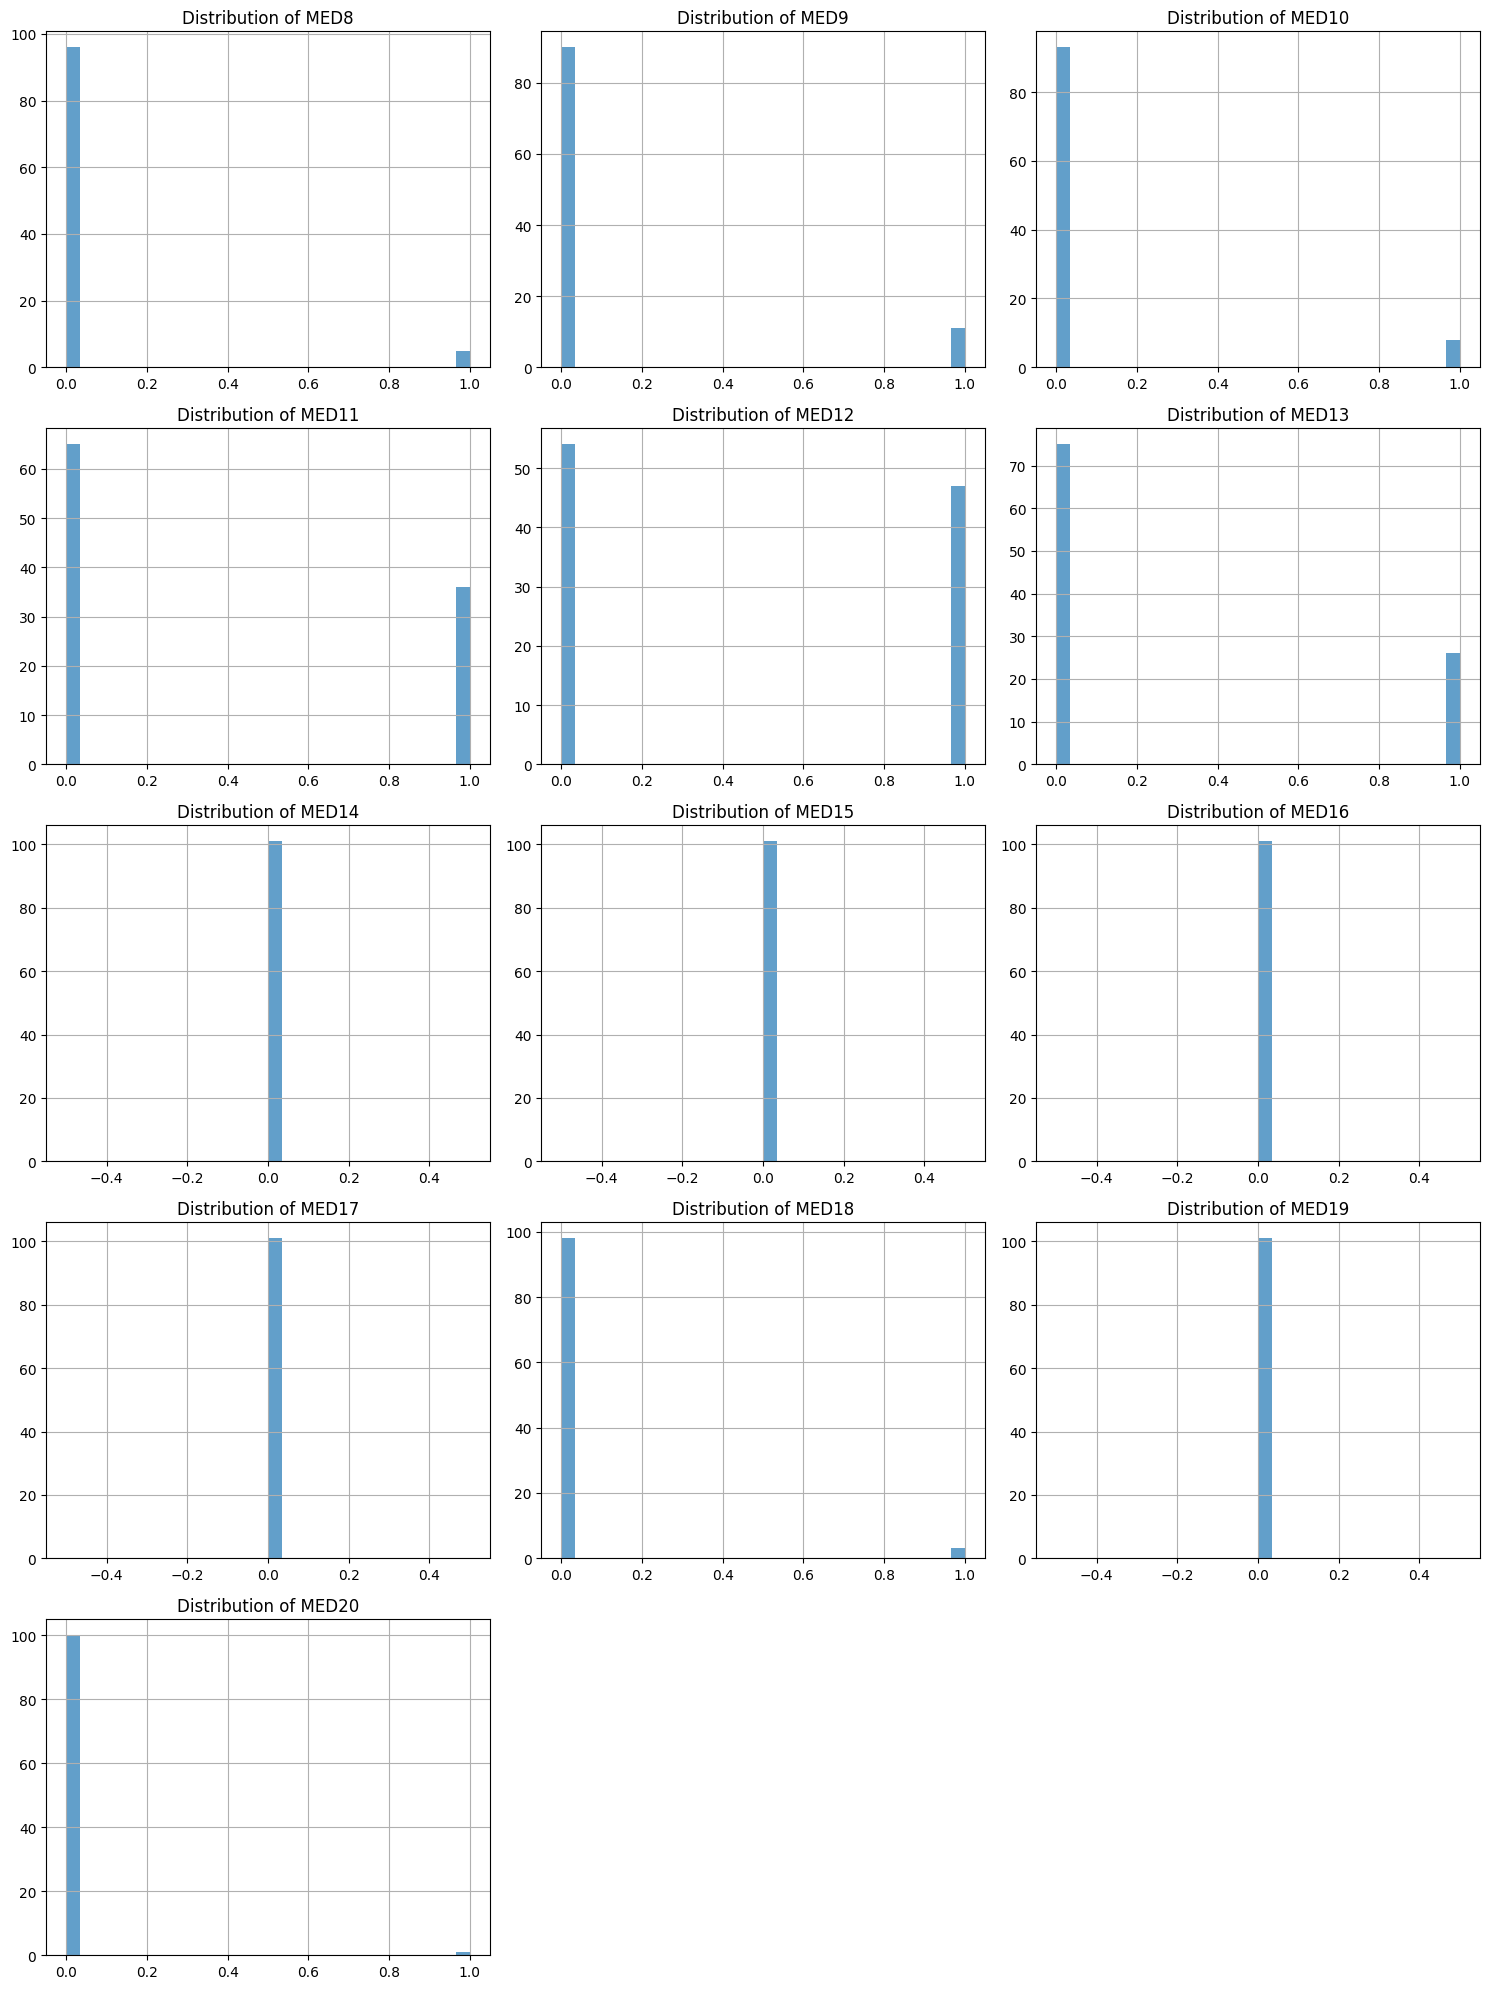

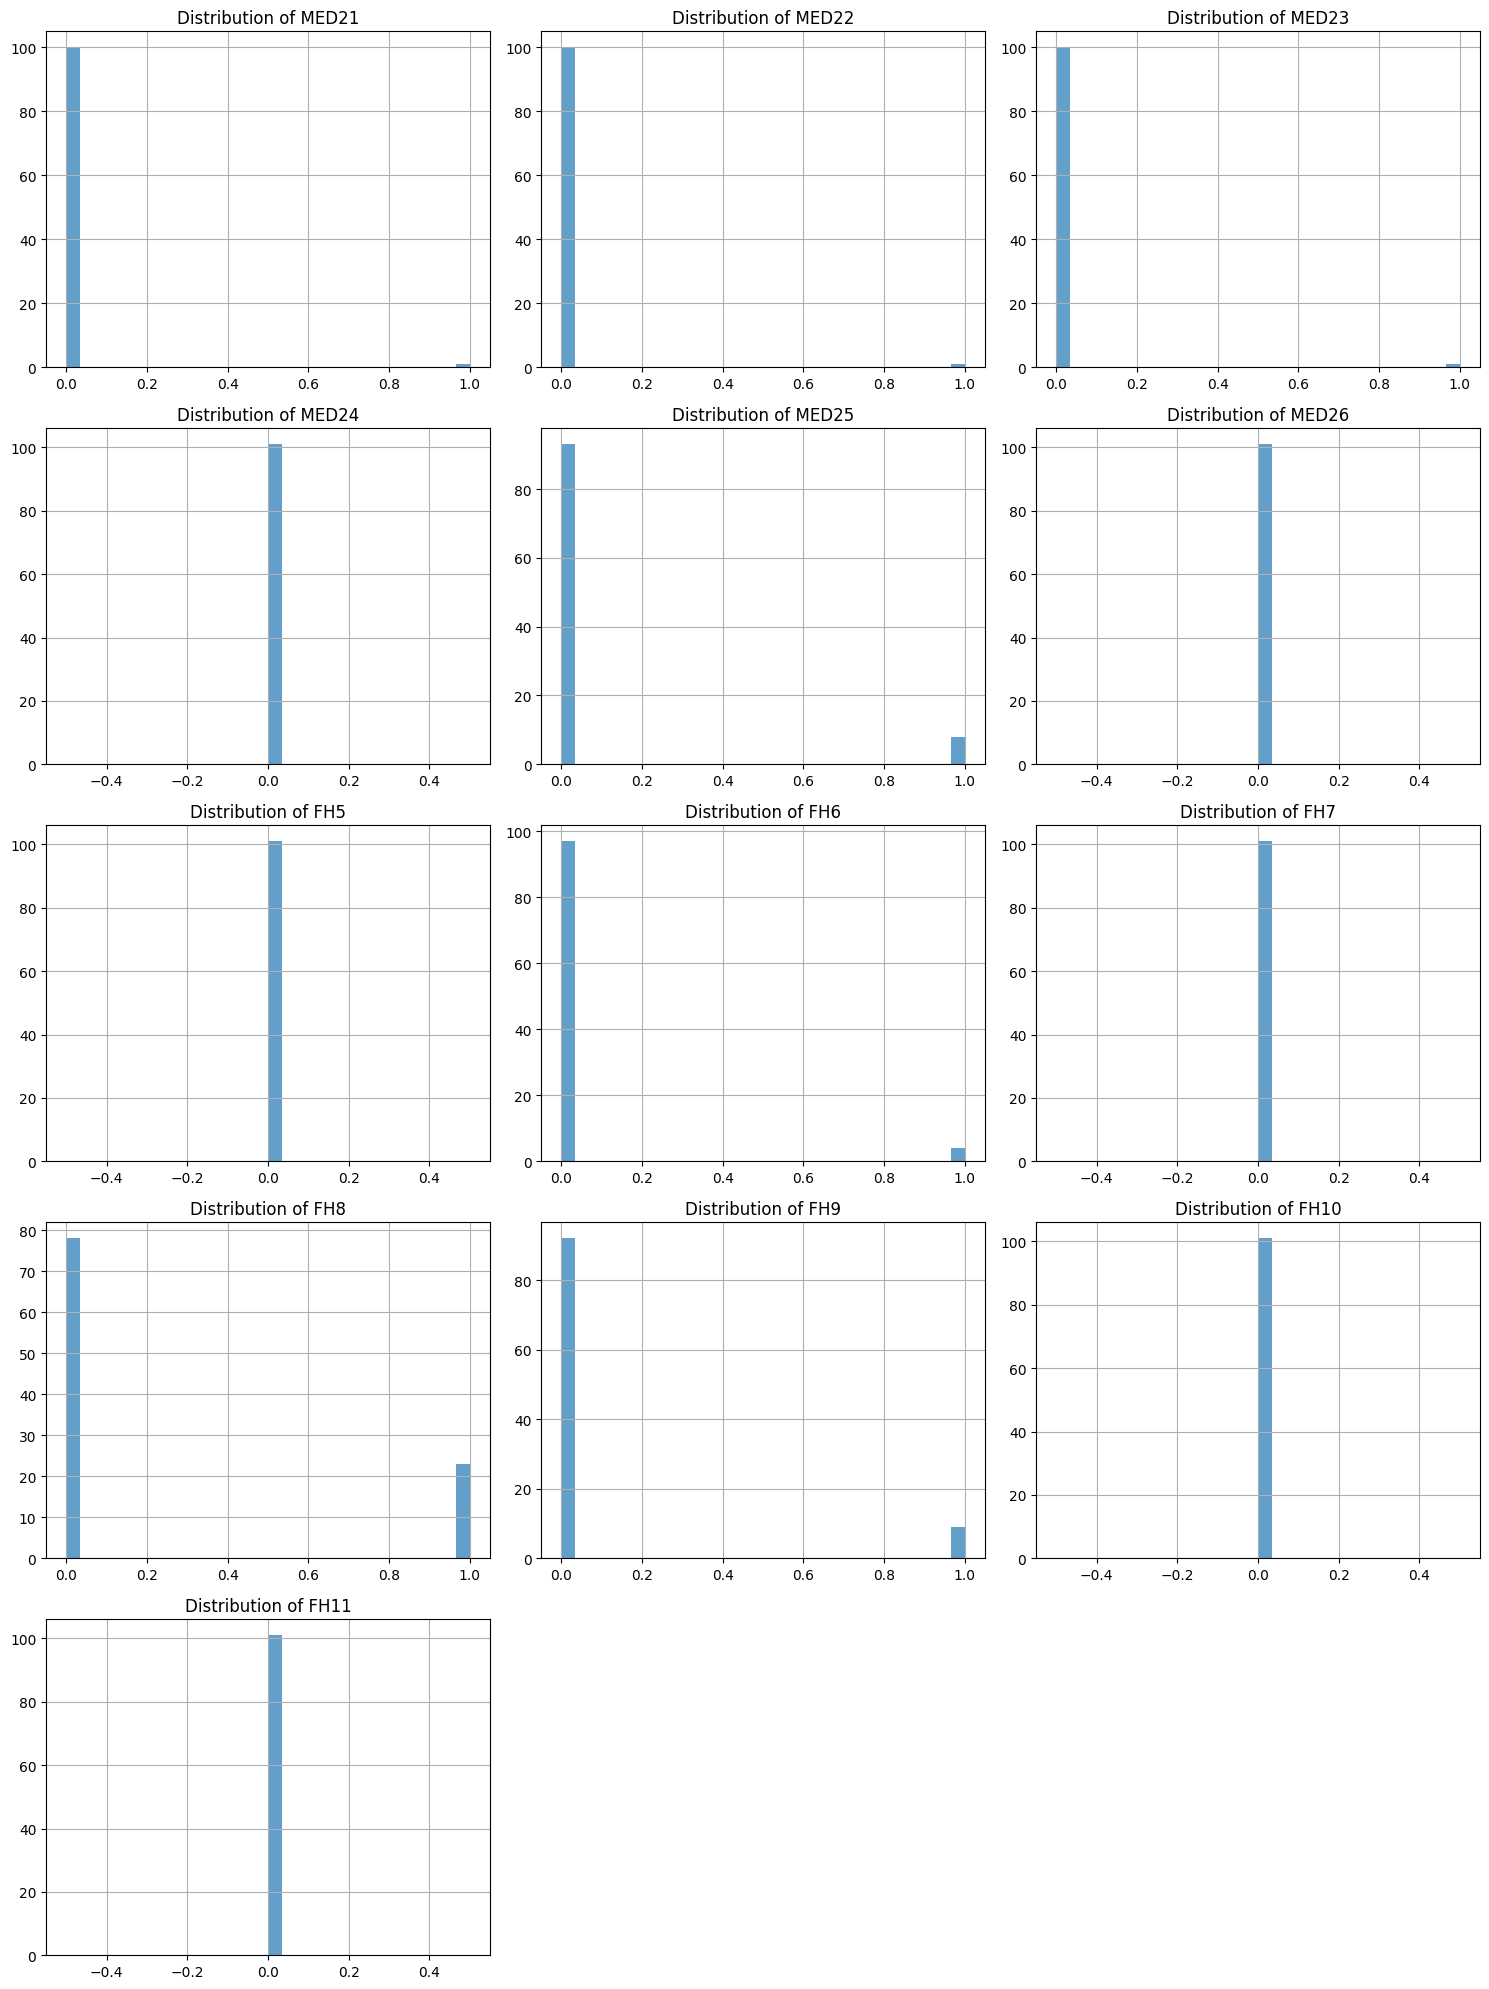

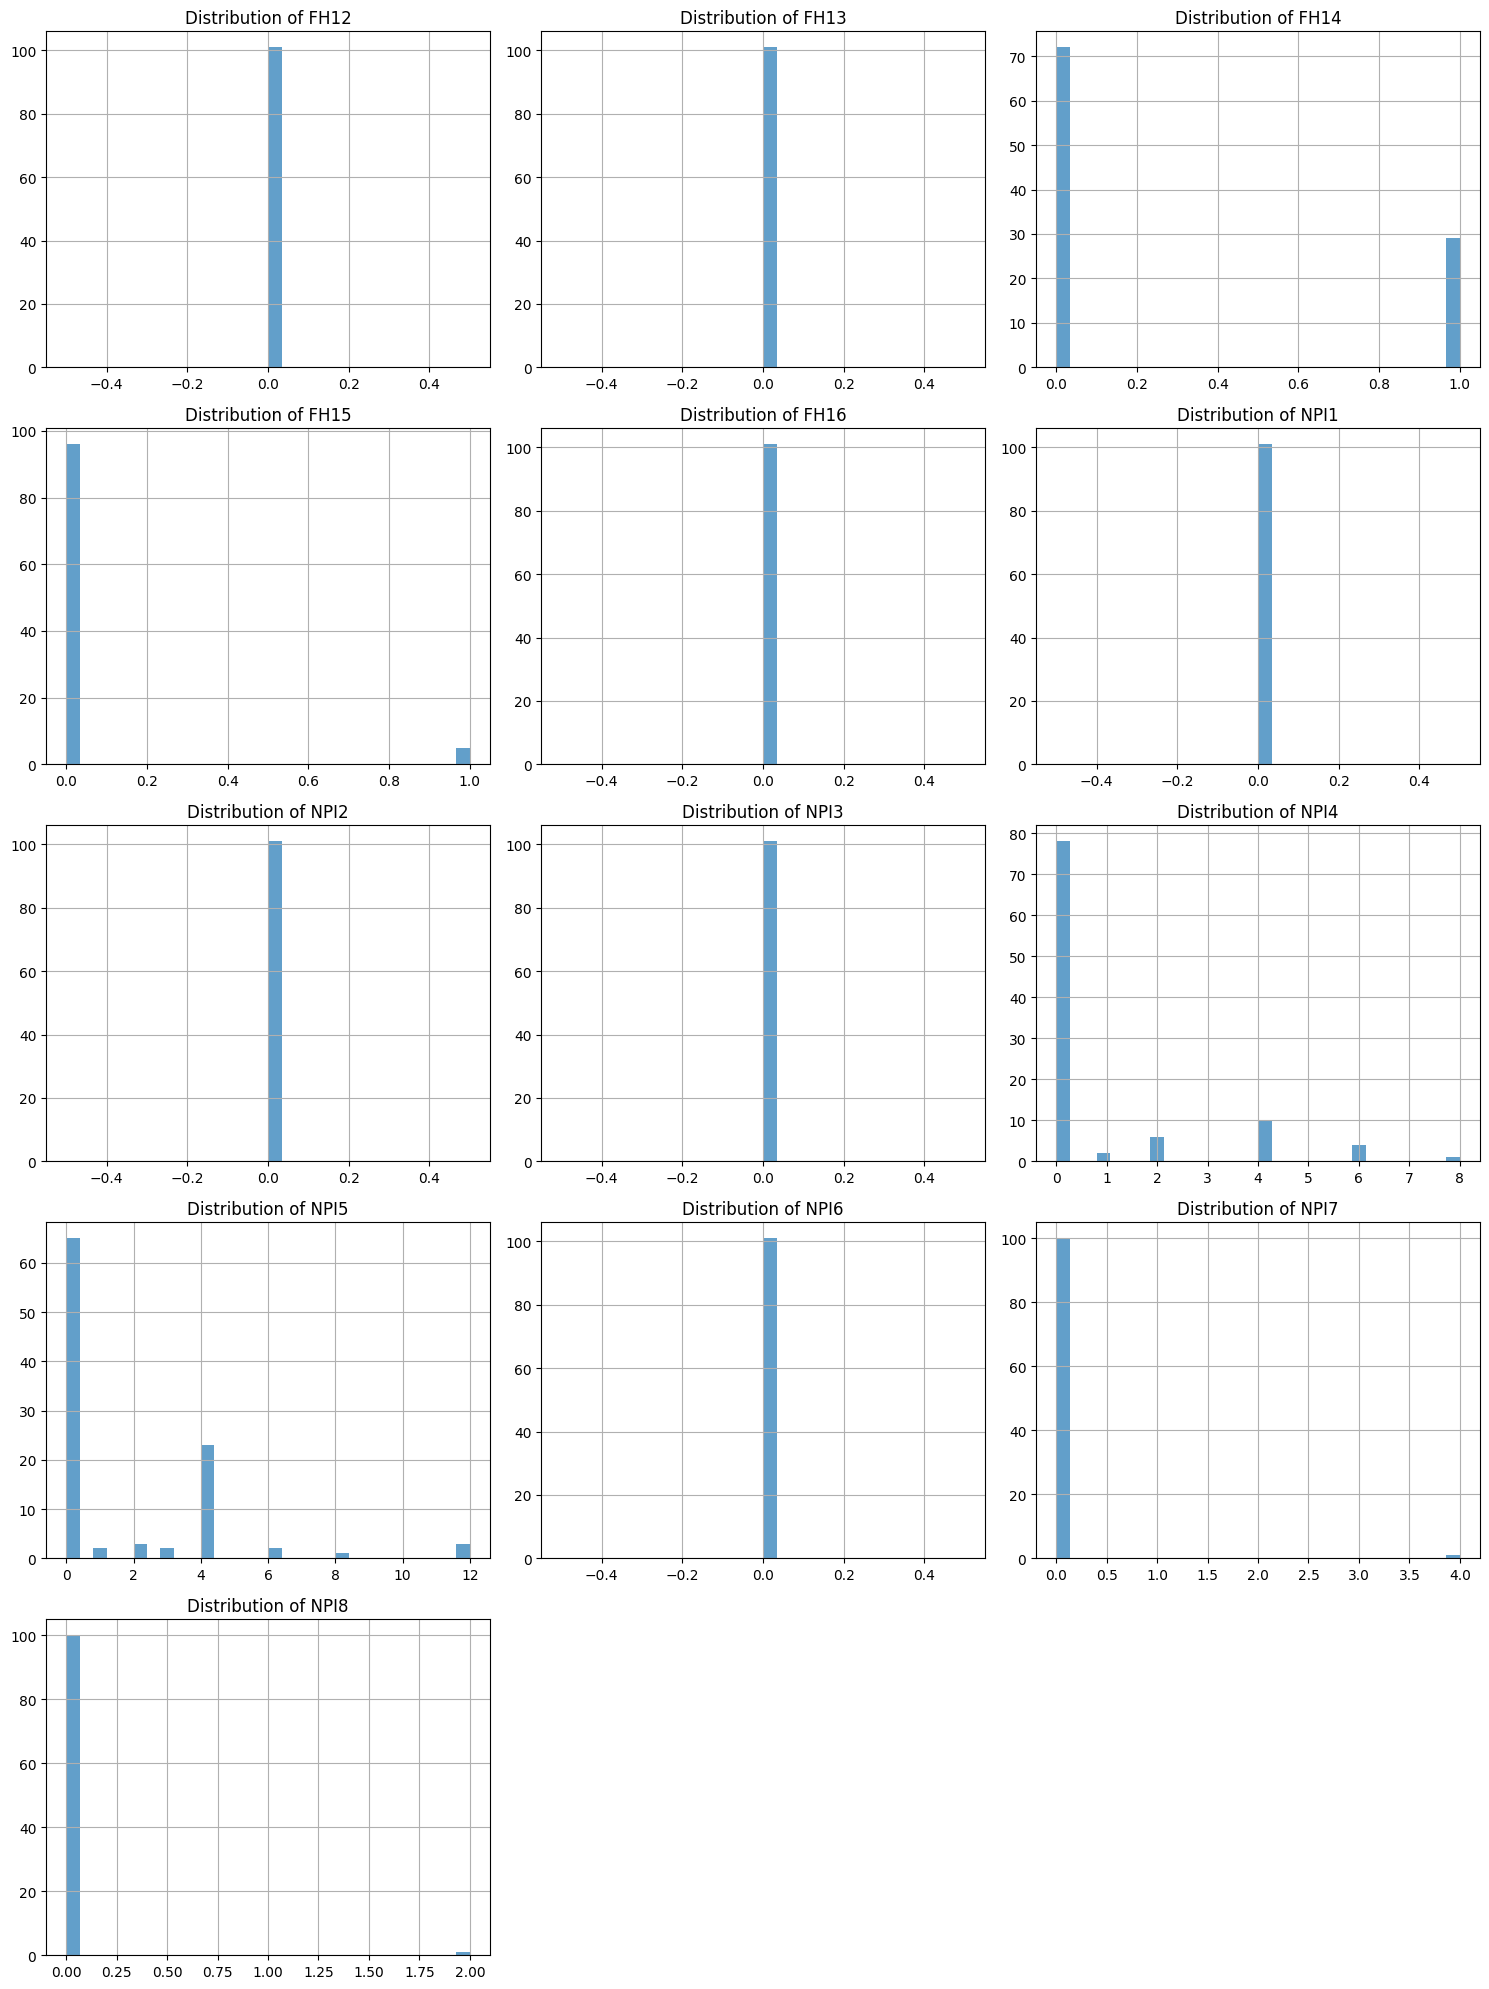

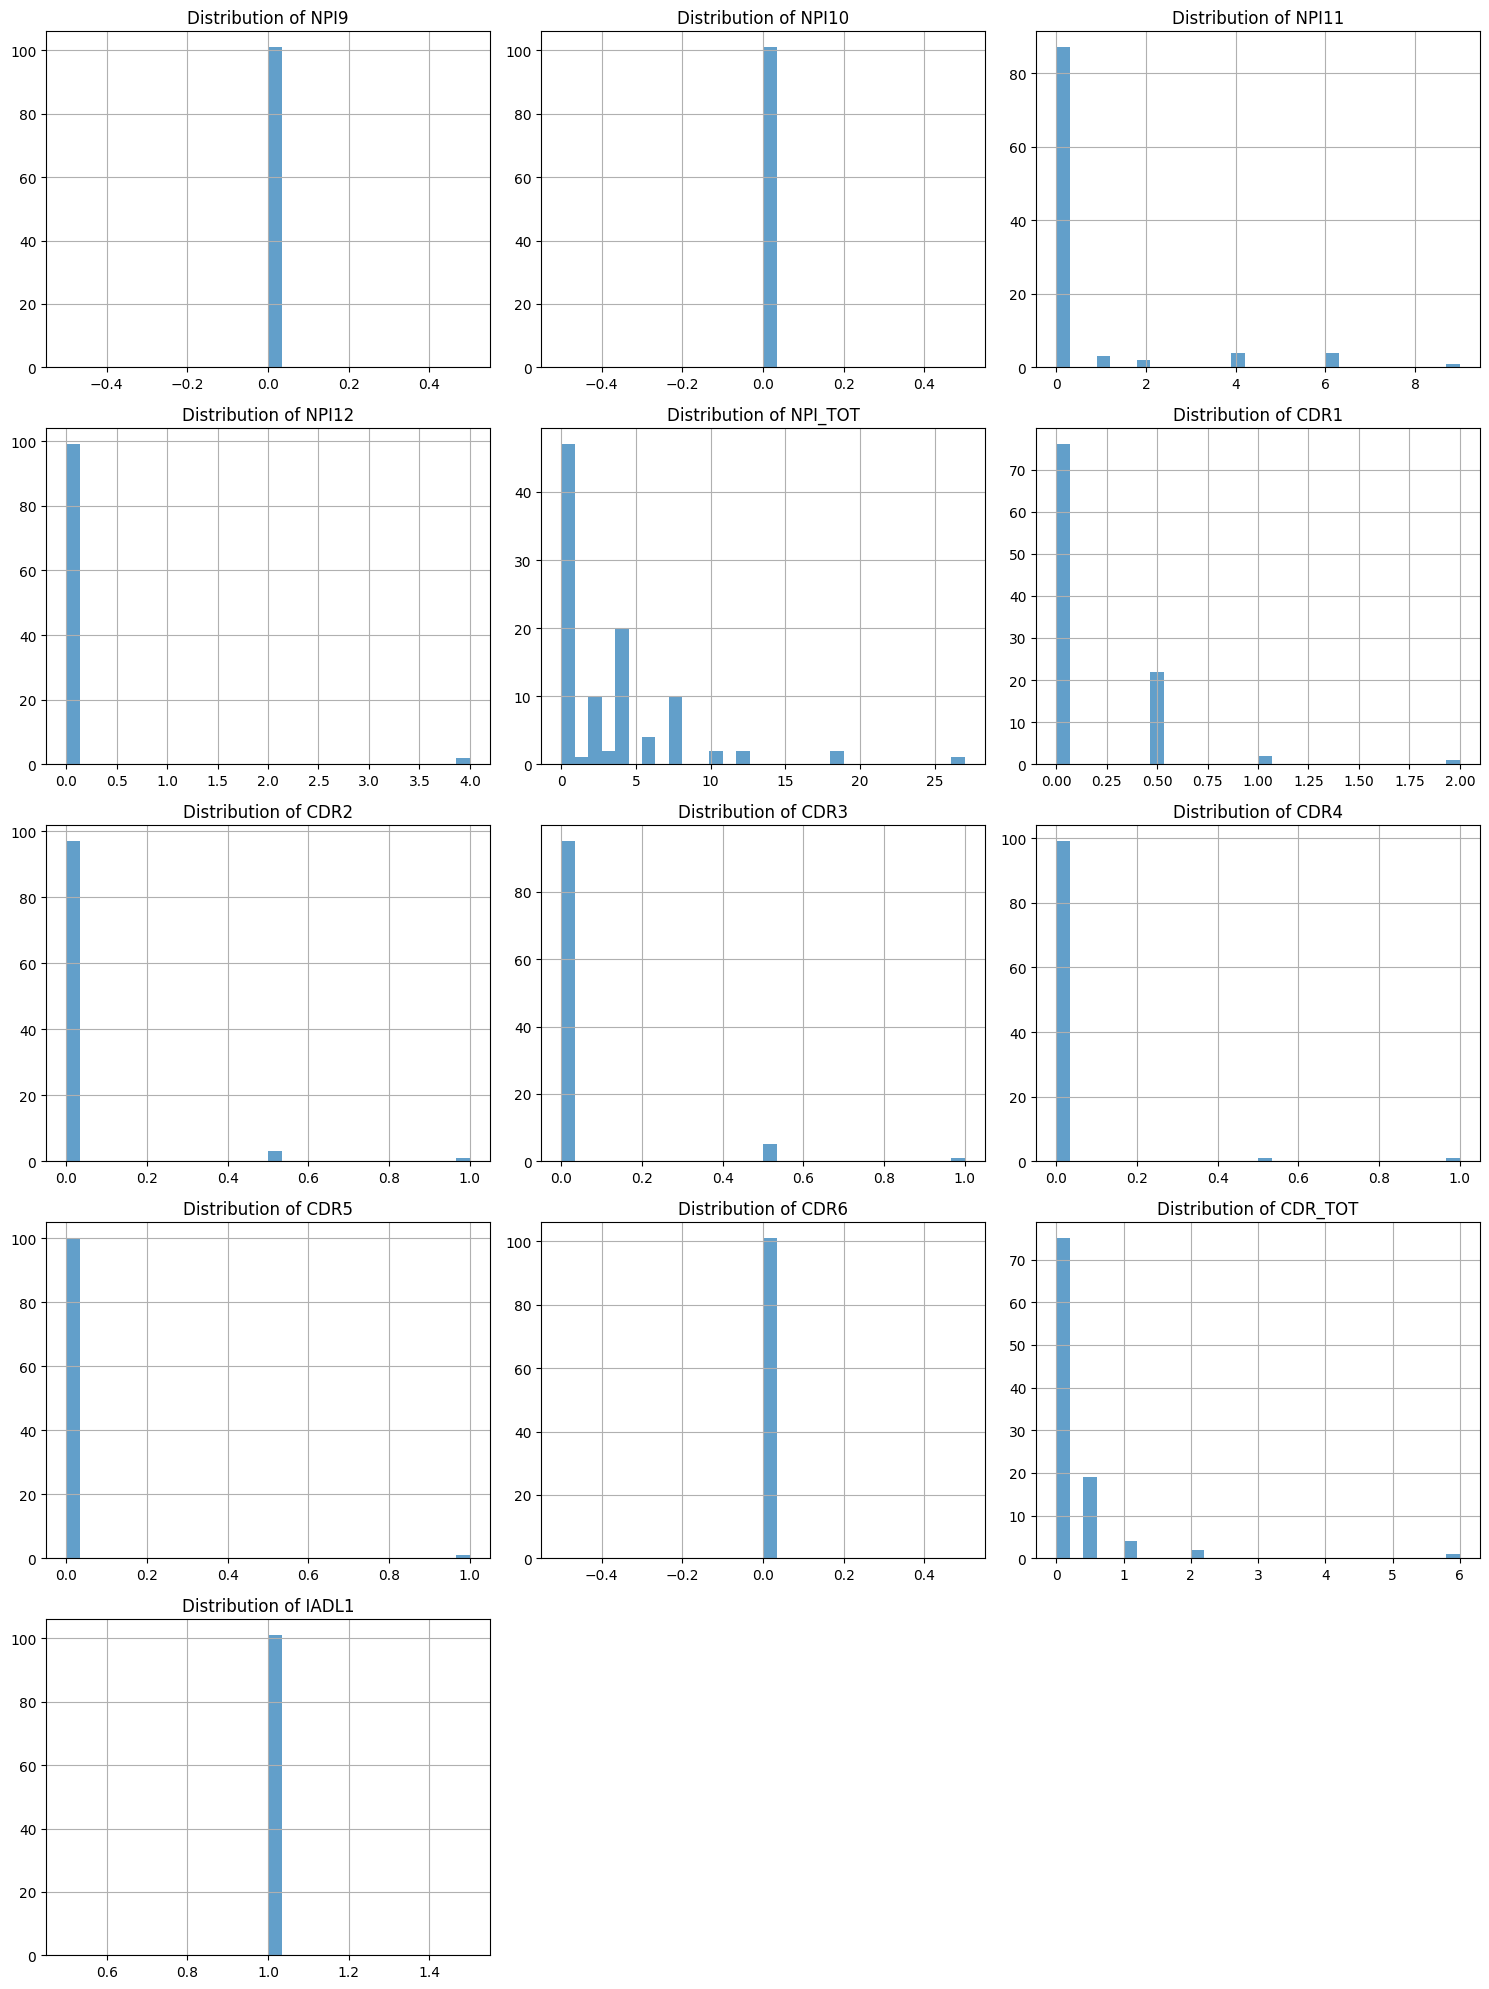

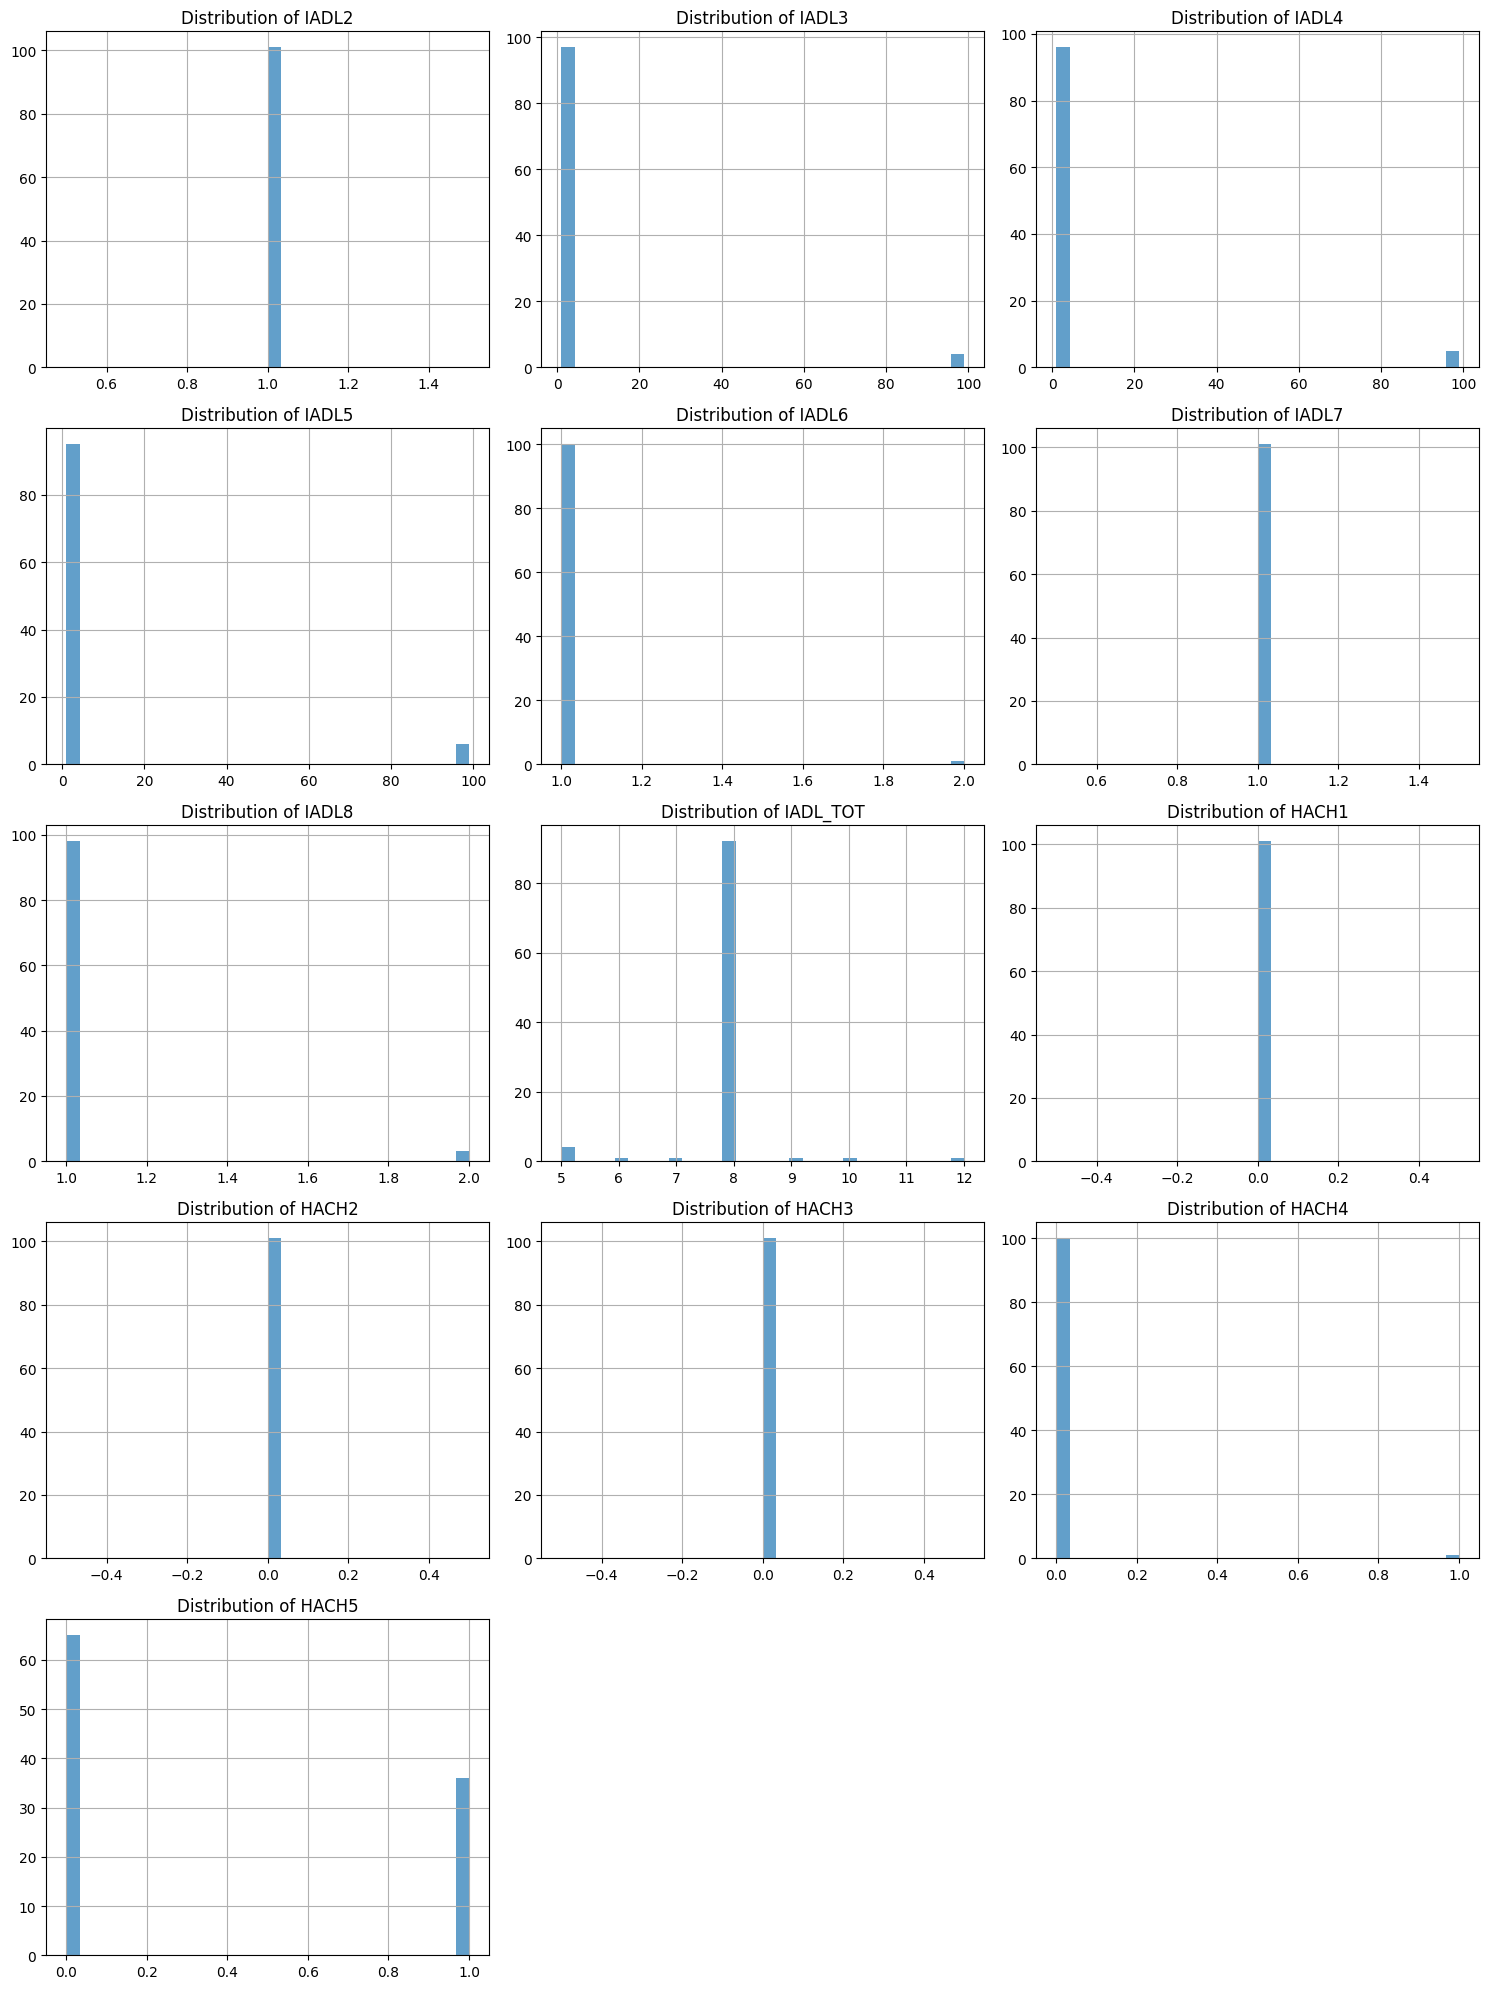

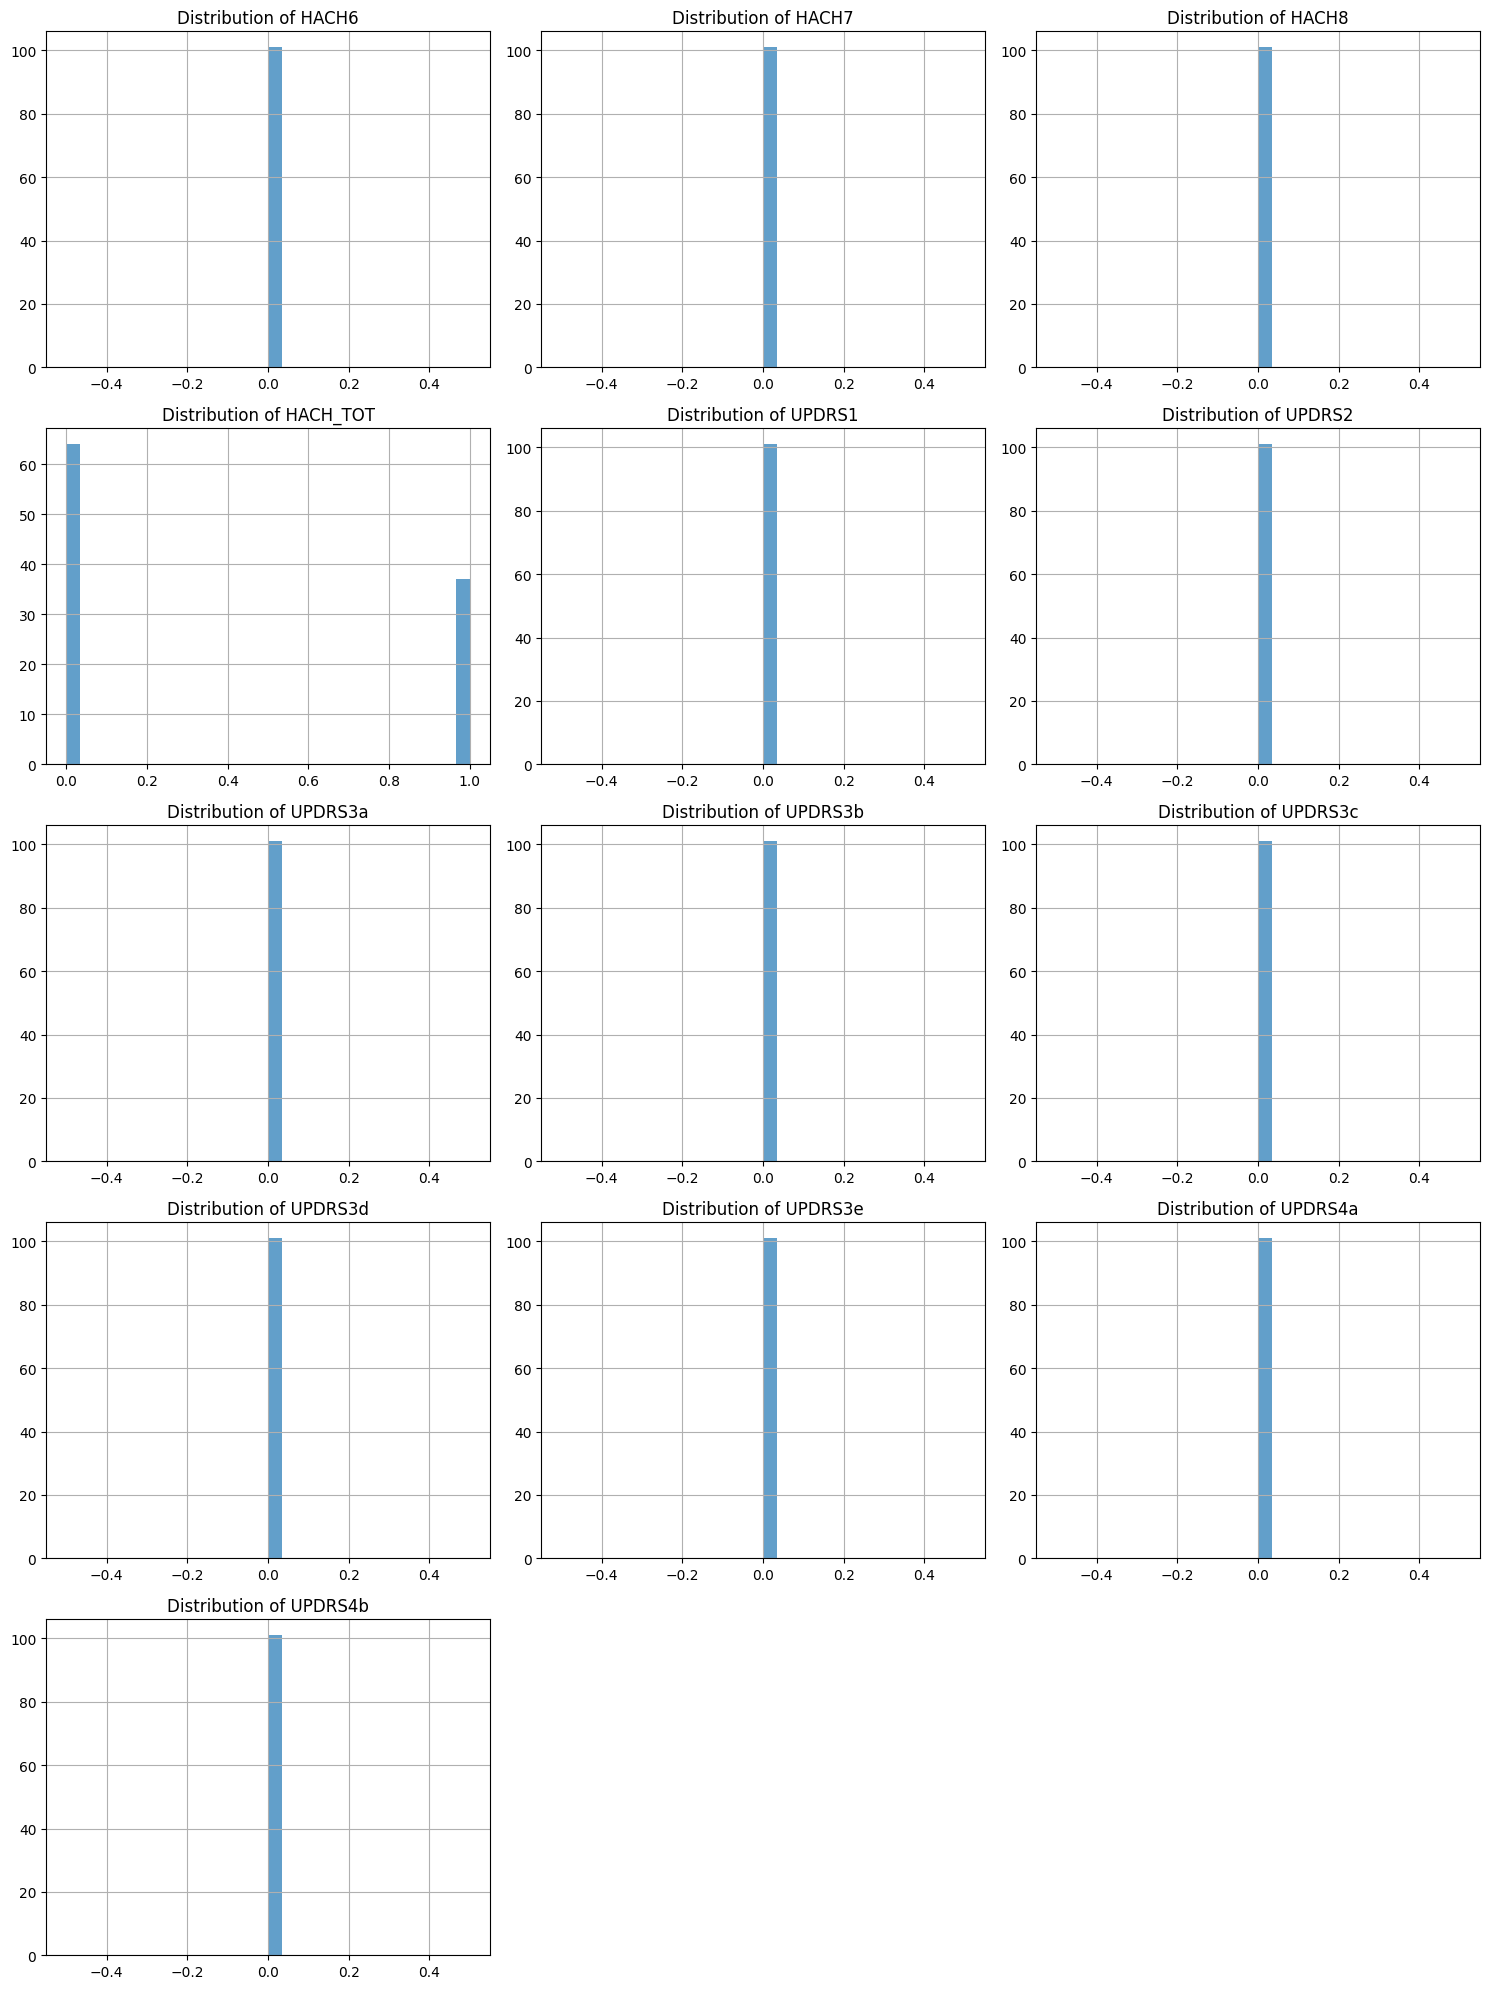

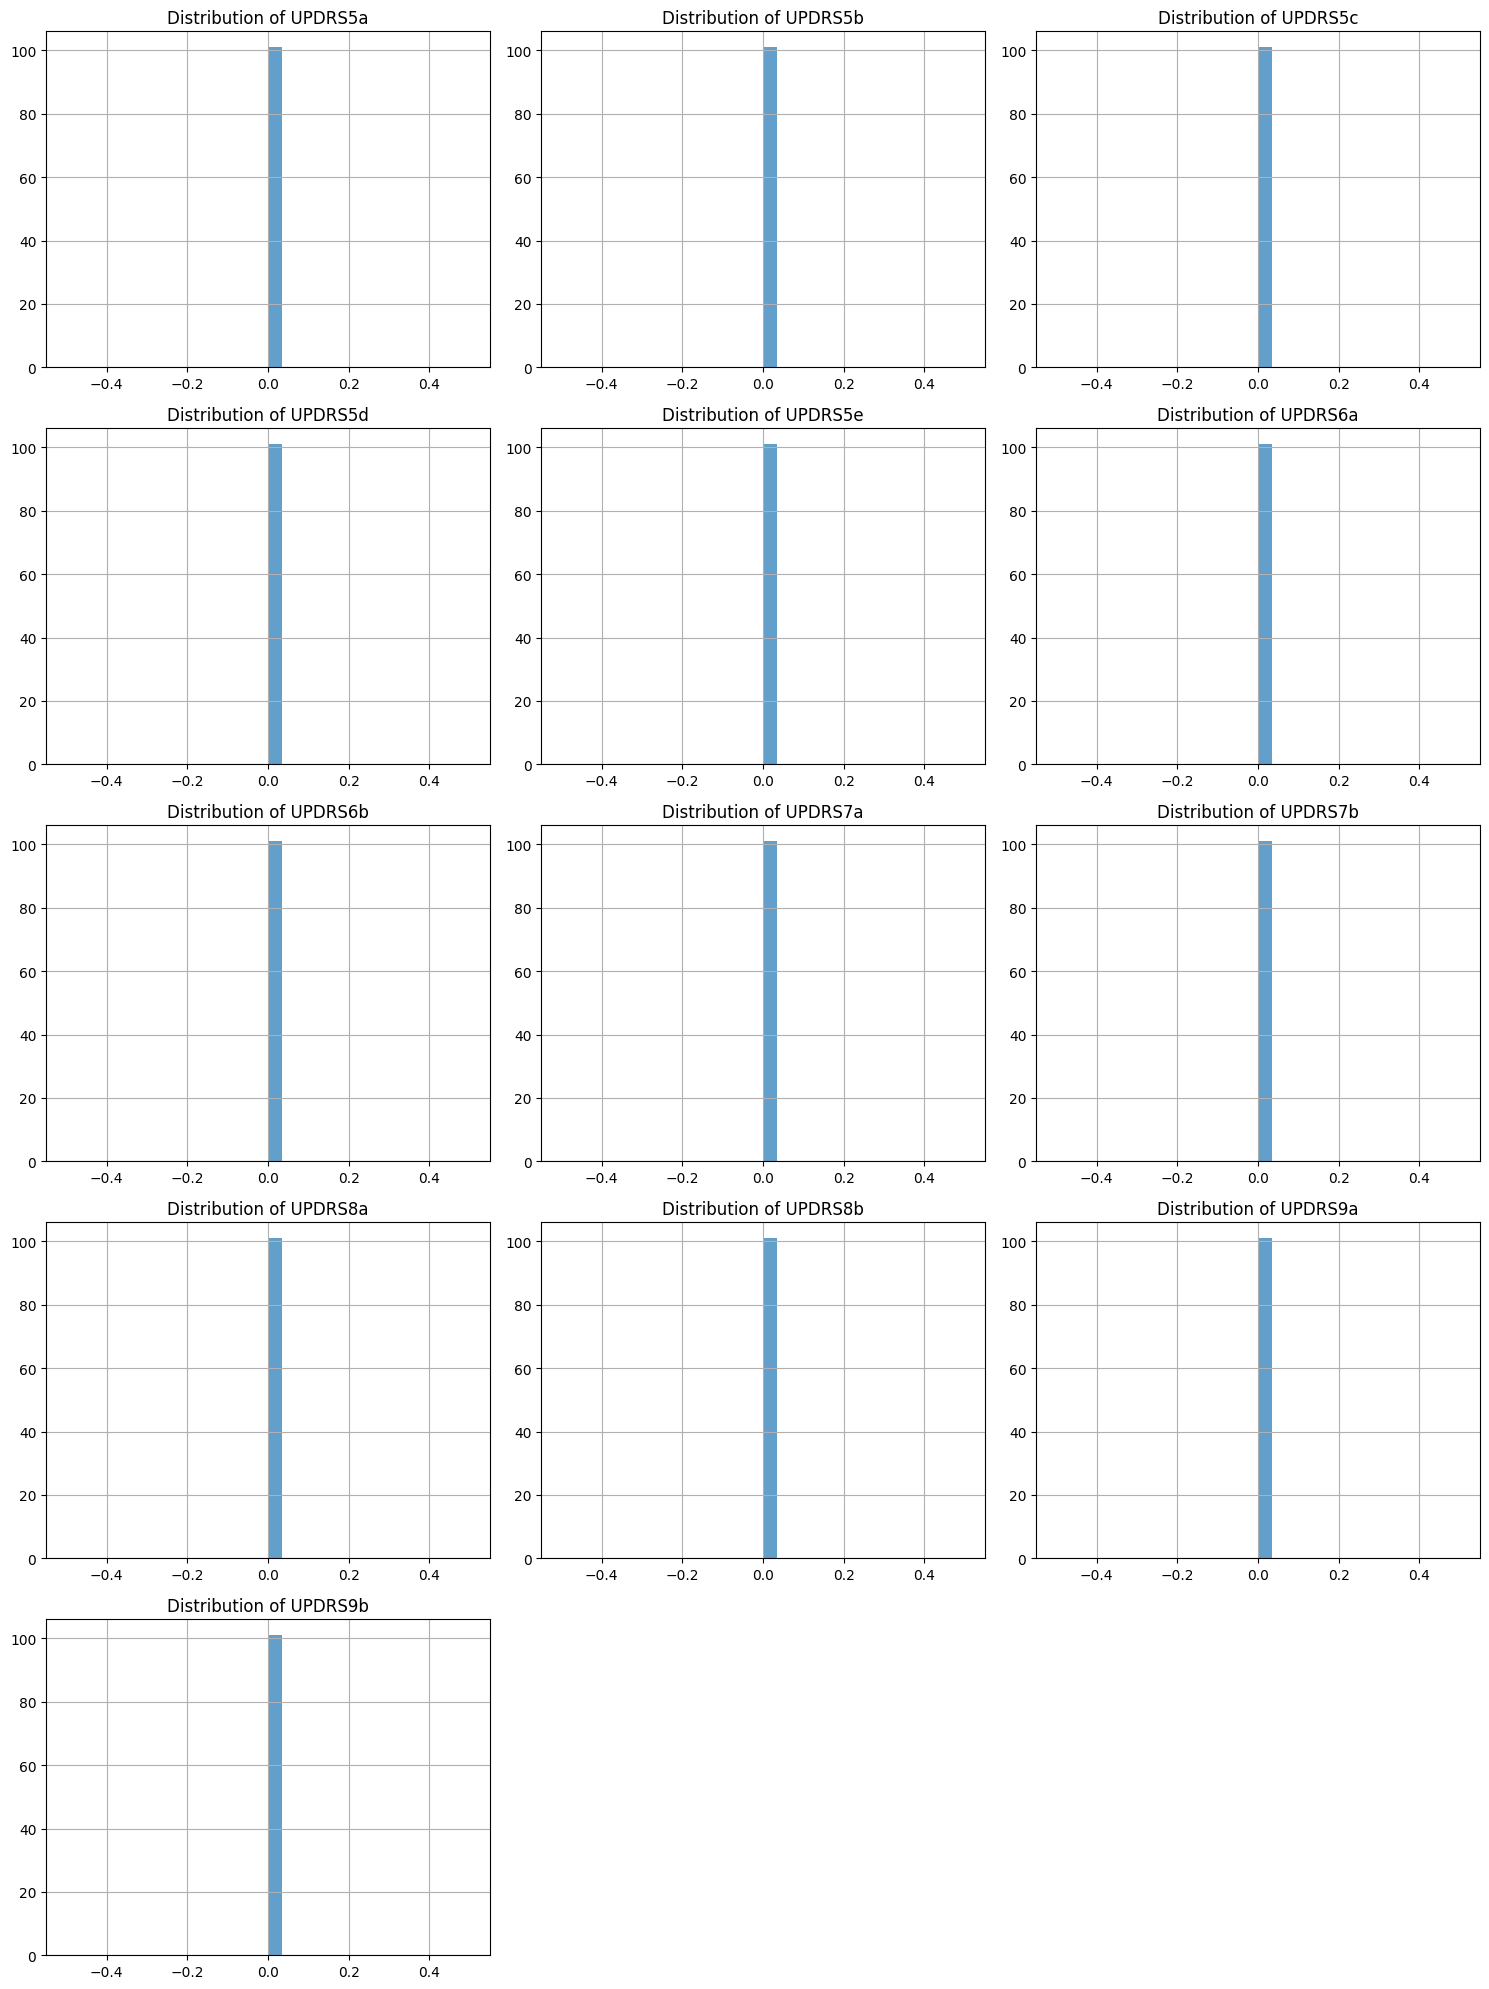

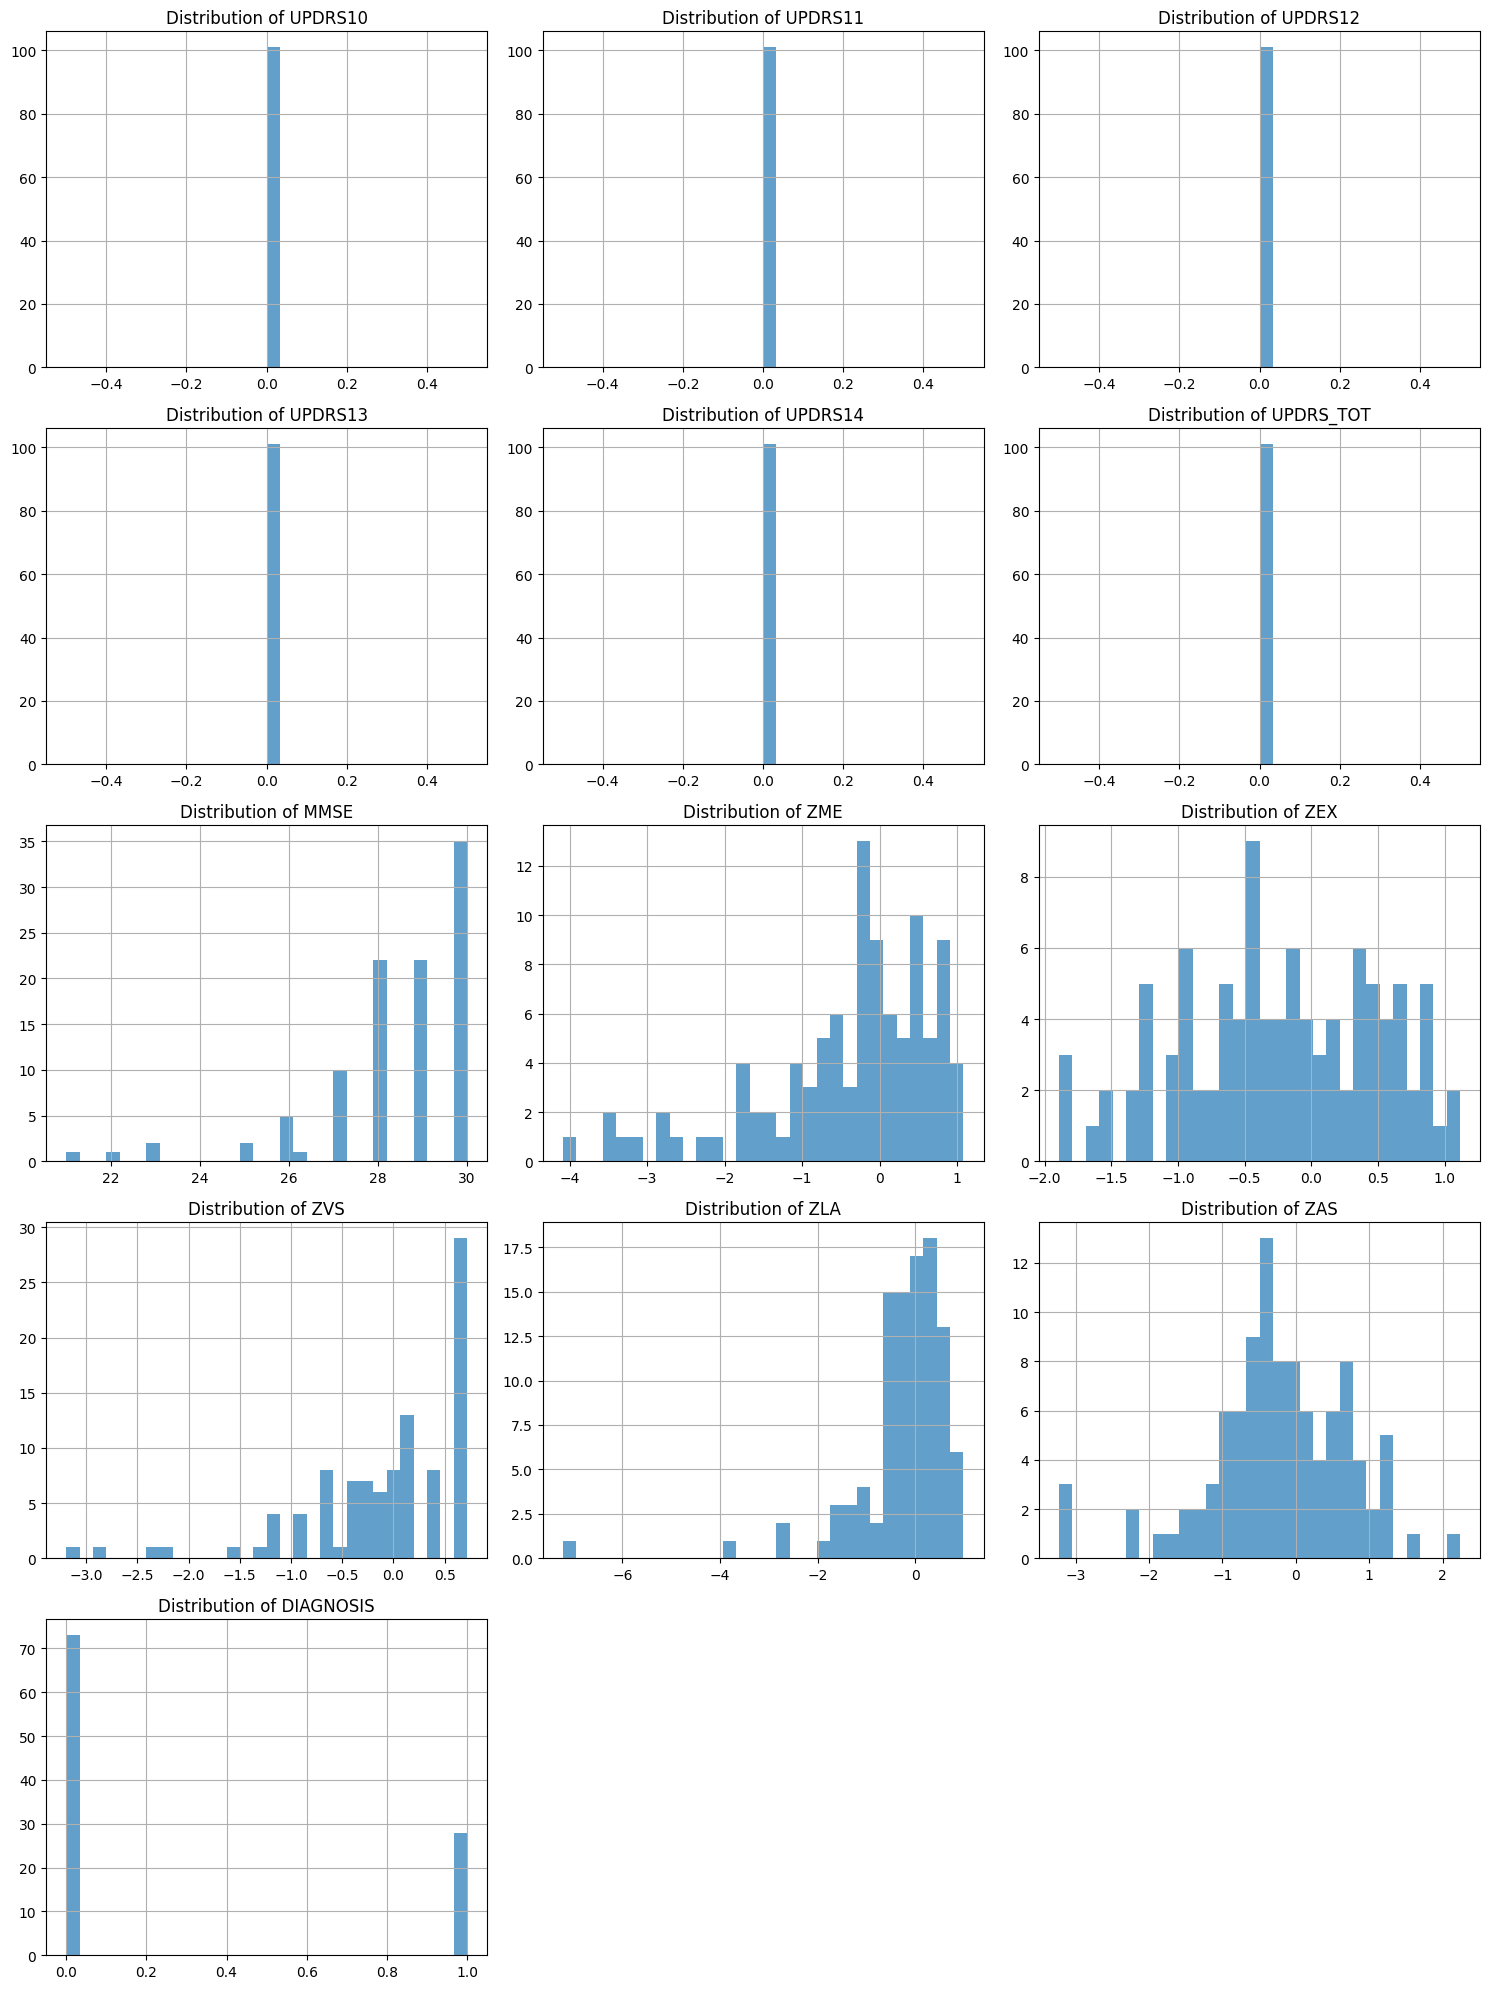

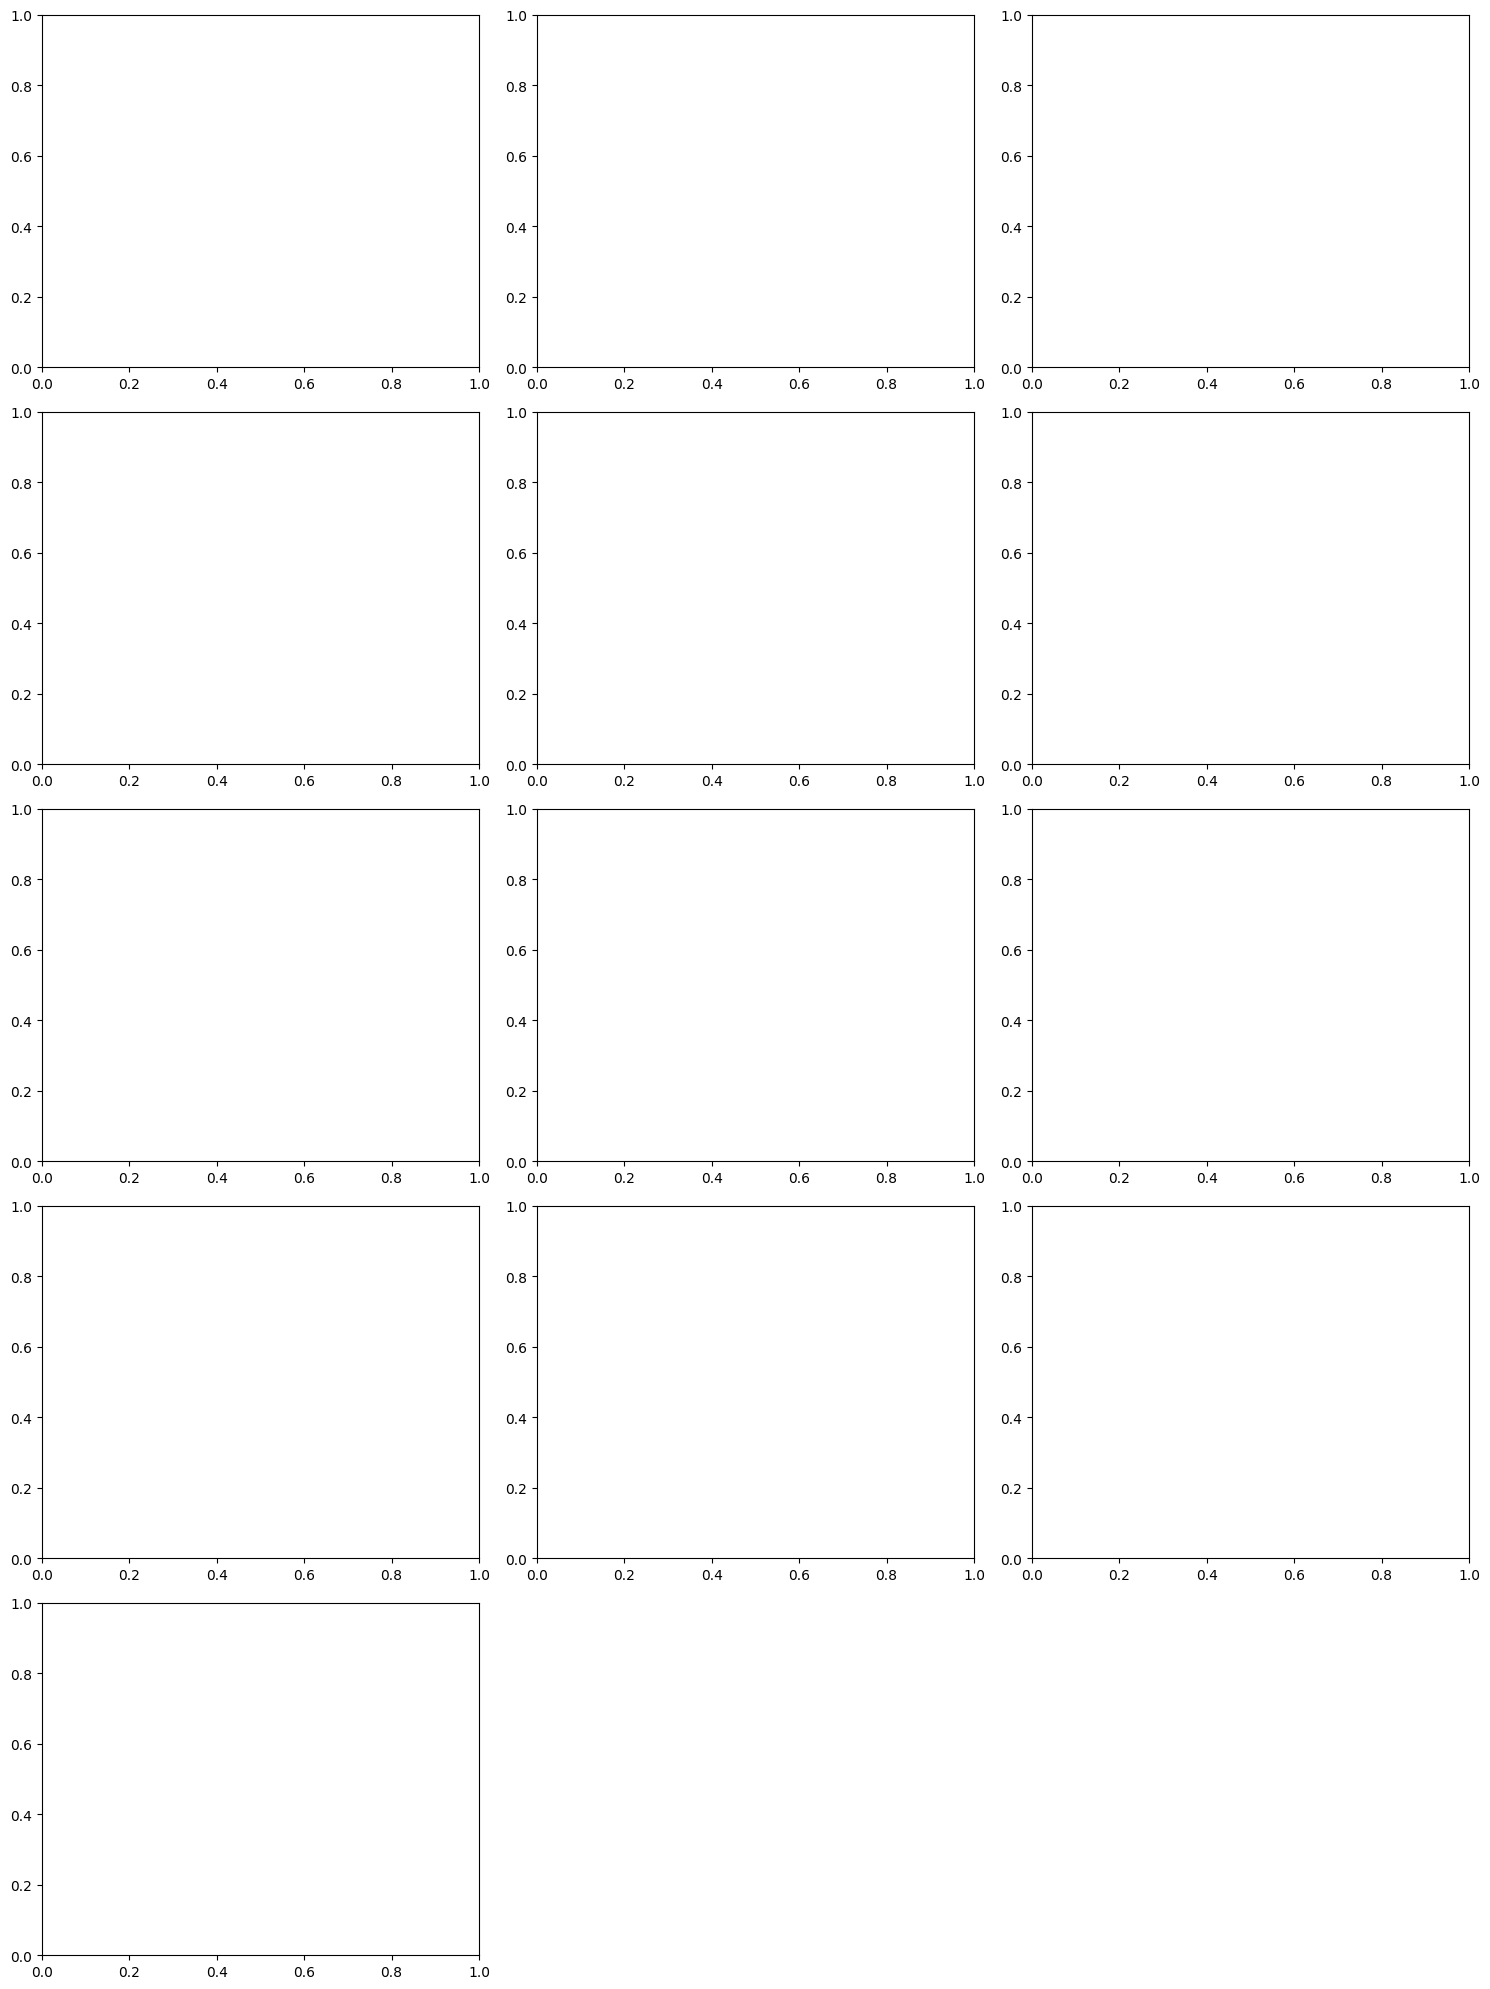

In [22]:
# Set the number of features per figure to 13
features_per_plot = 13
num_features = test_df.shape[1]
num_chunks = (num_features // features_per_plot) + 1

# Loop through features in chunks
for chunk in range(num_chunks):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows and 3 columns for 13 plots (1 will be empty)
    axes = axes.ravel()

    start_idx = chunk * features_per_plot
    end_idx = min((chunk + 1) * features_per_plot, num_features)

    for i, feature in enumerate(test_df.columns[start_idx:end_idx]):
        test_df[feature].hist(ax=axes[i], bins=30, alpha=0.7)
        axes[i].set_title(f'Distribution of {feature}')
    
    # Hide any extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

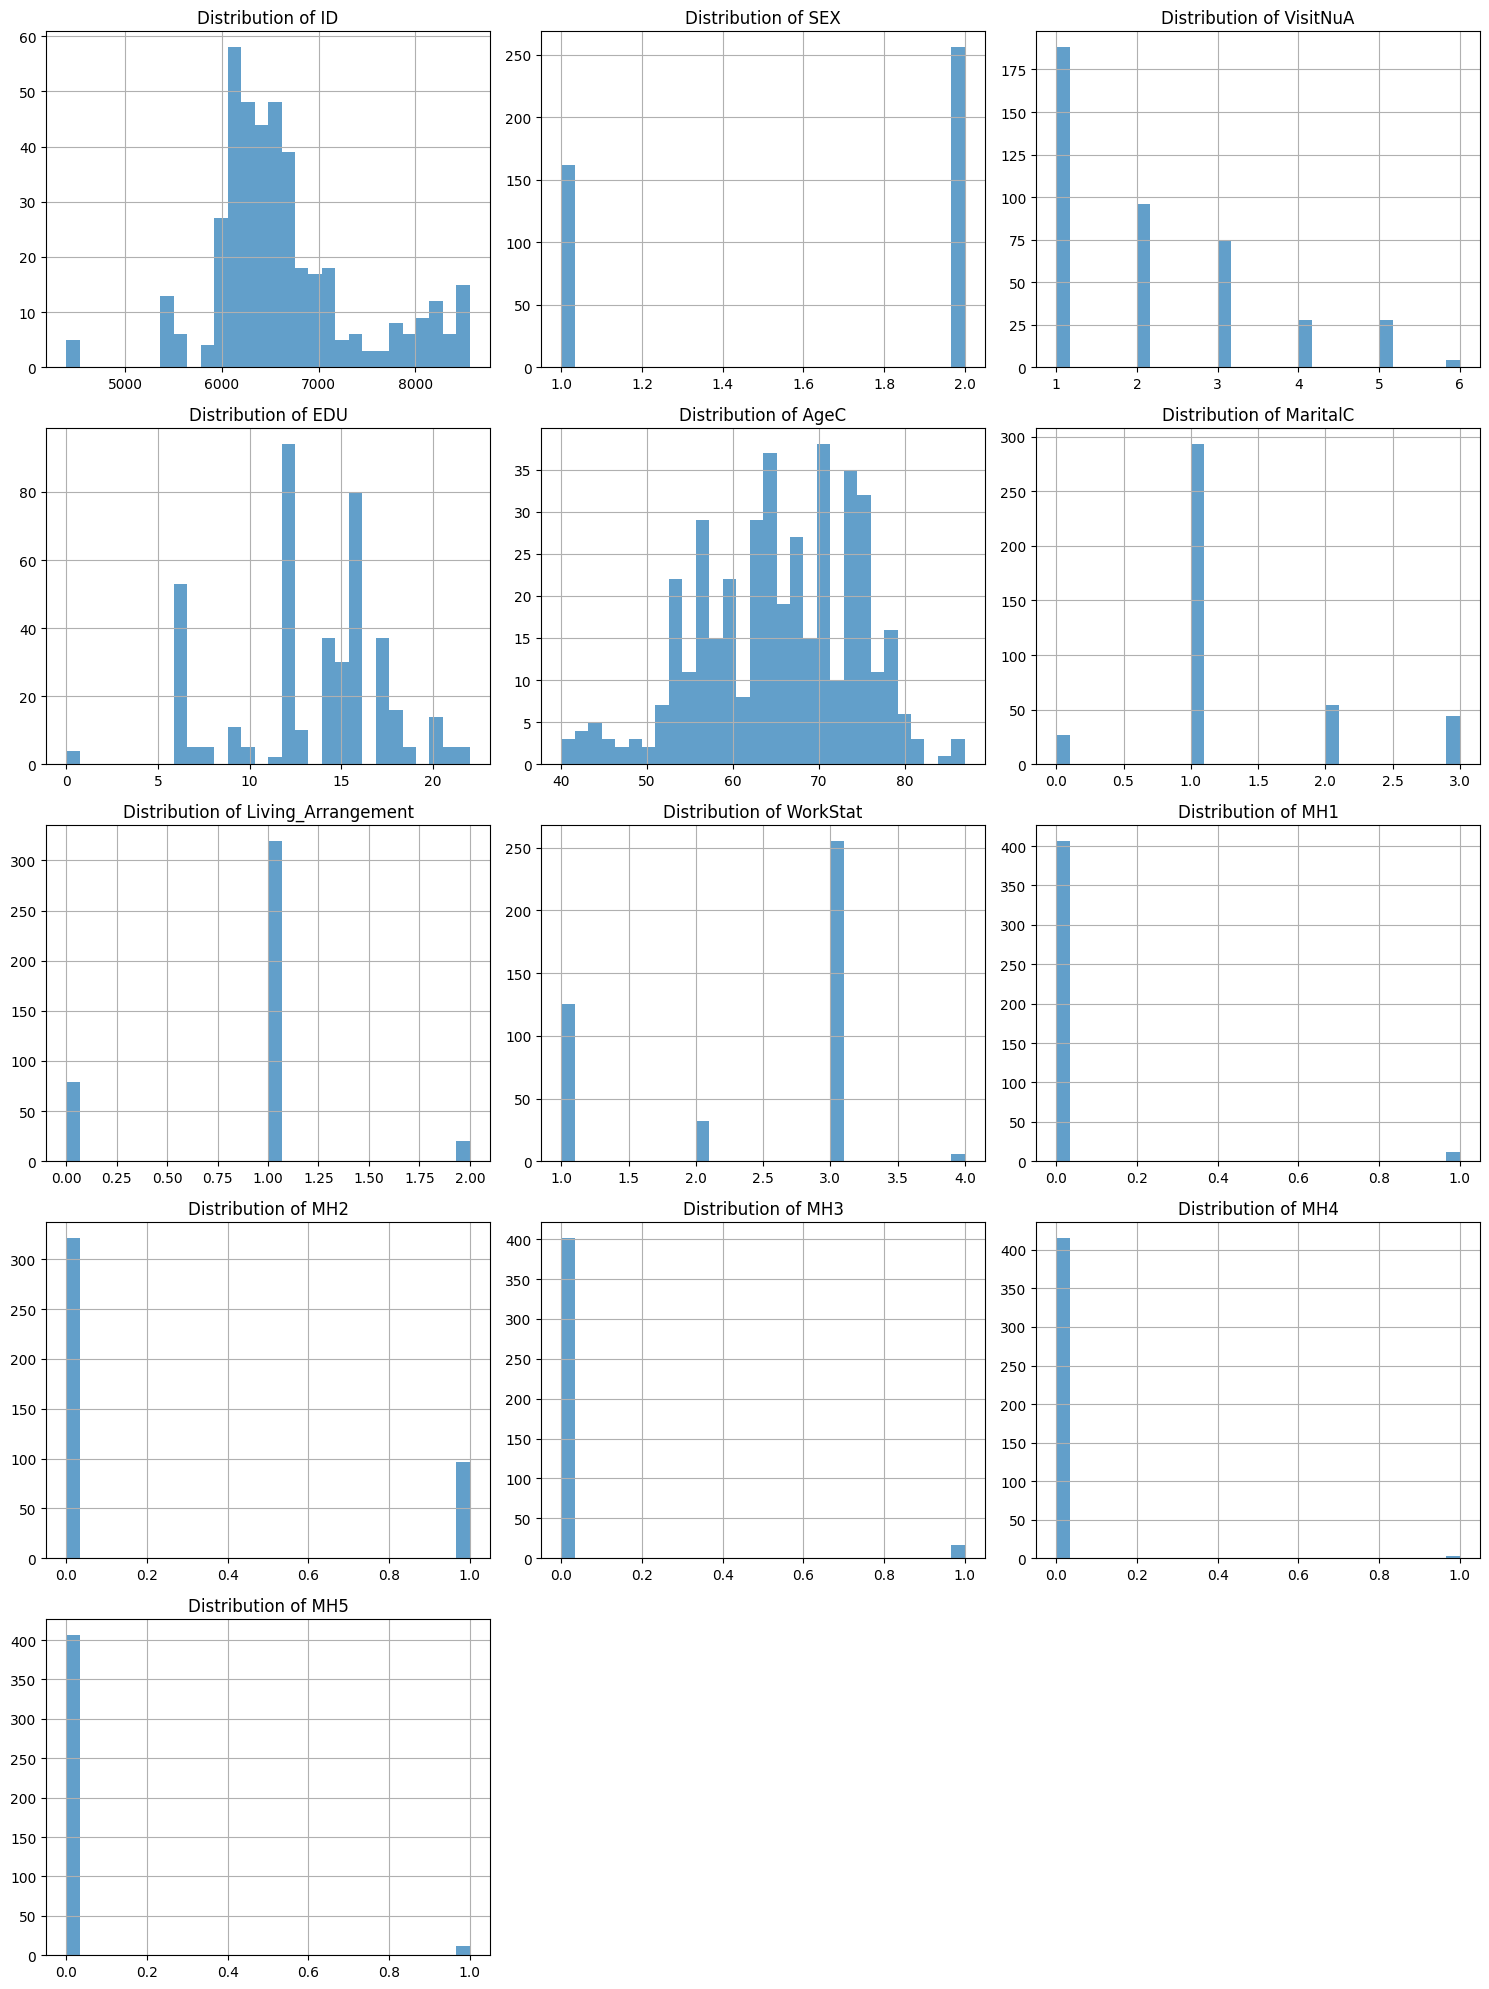

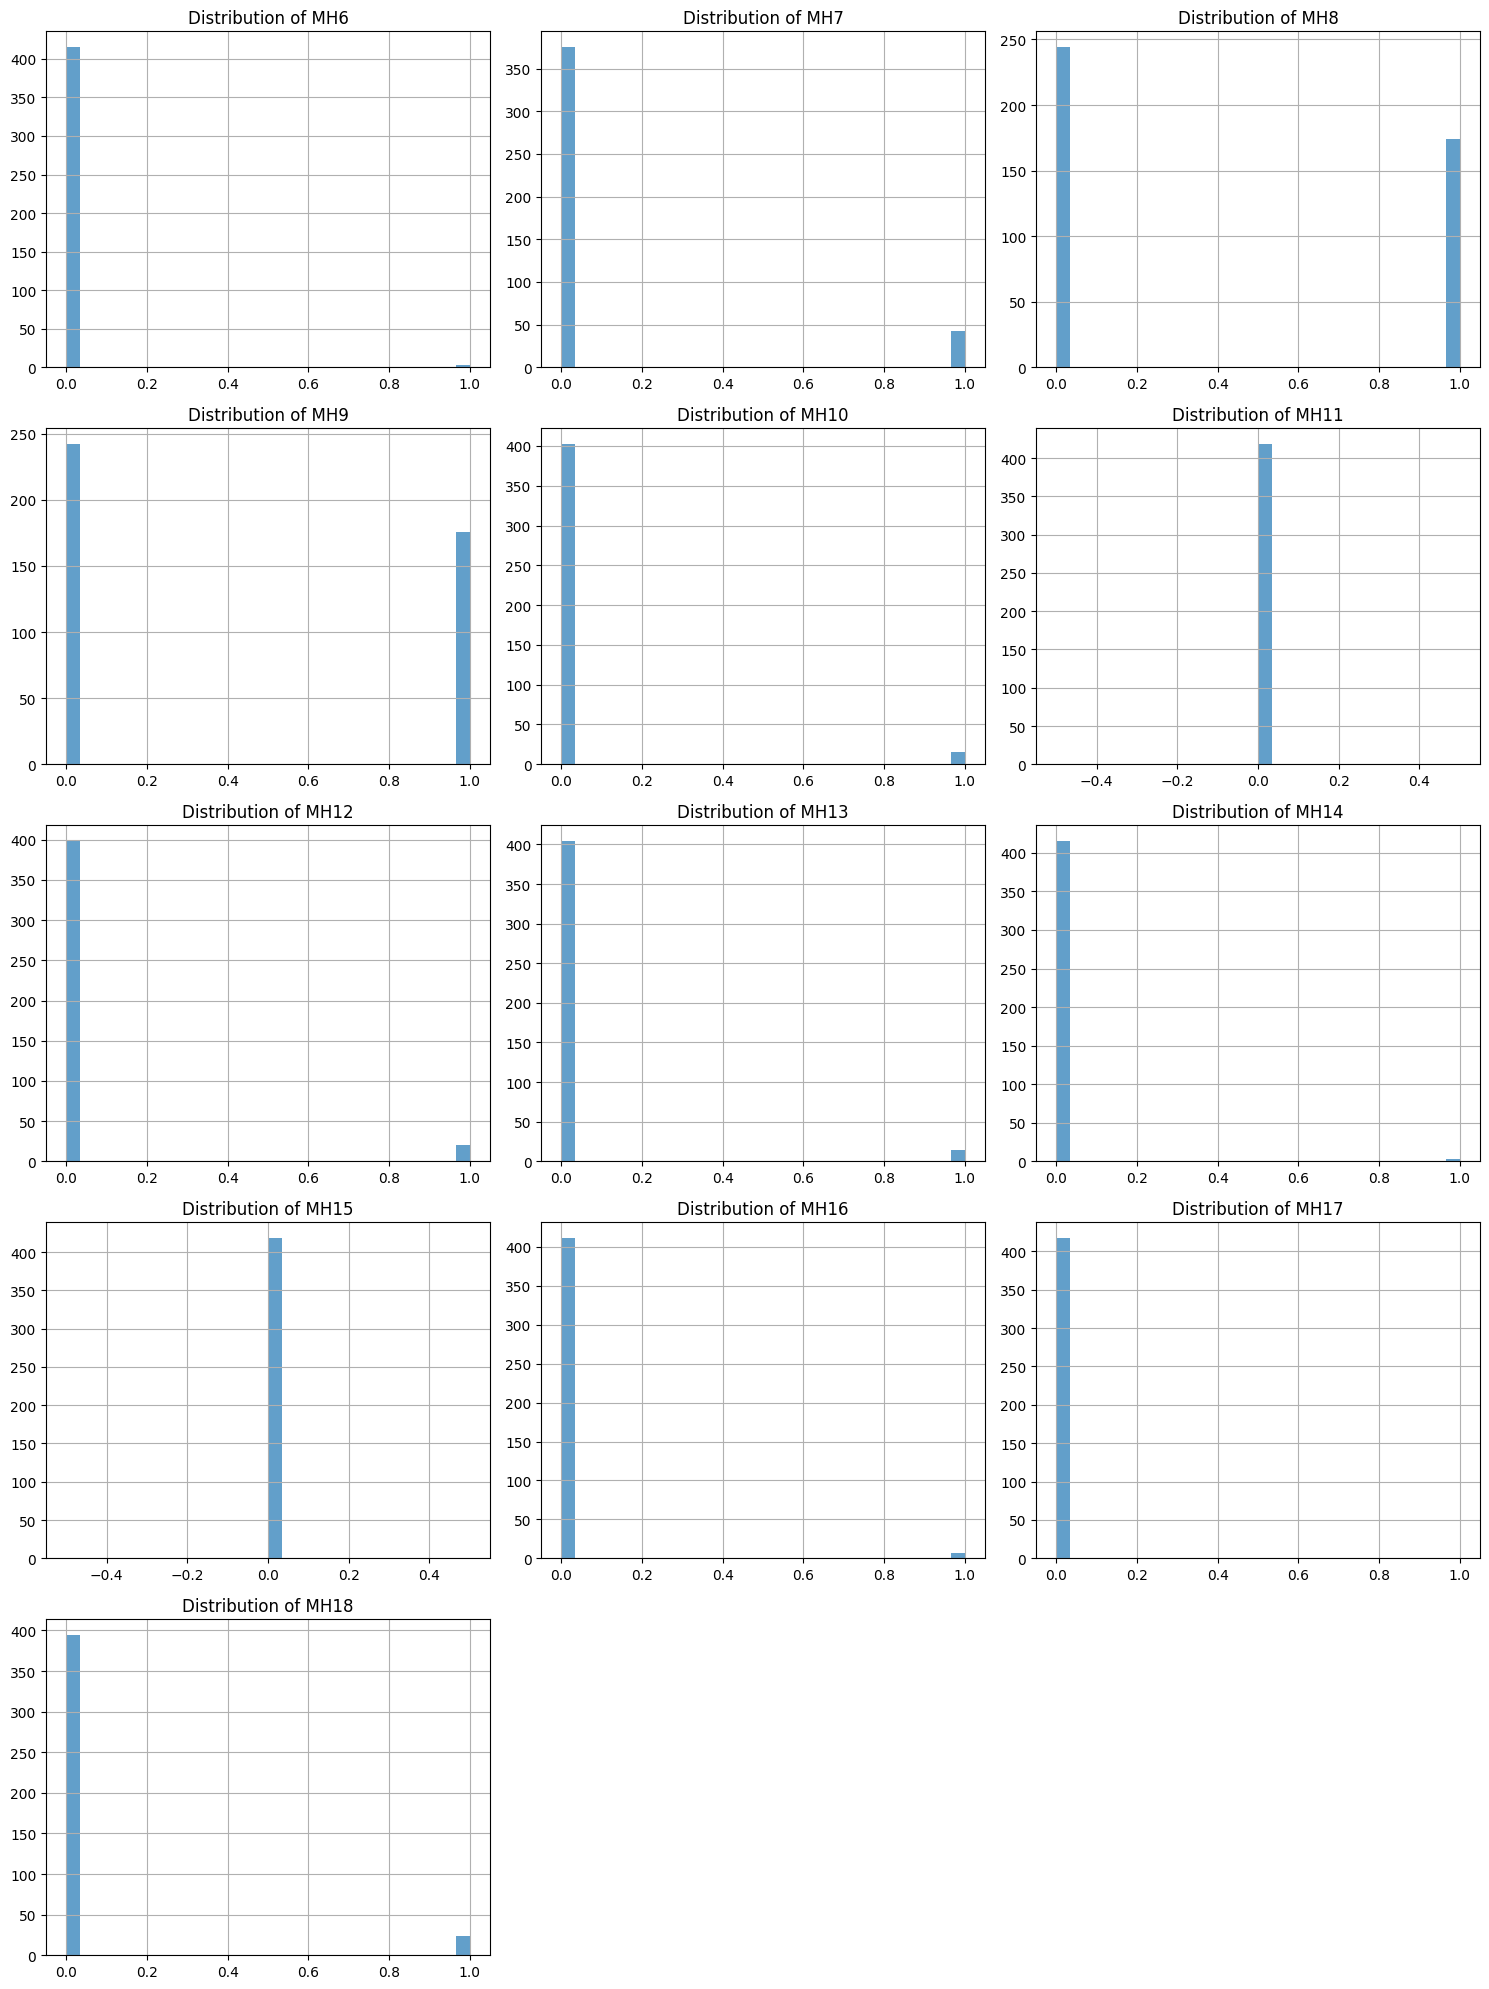

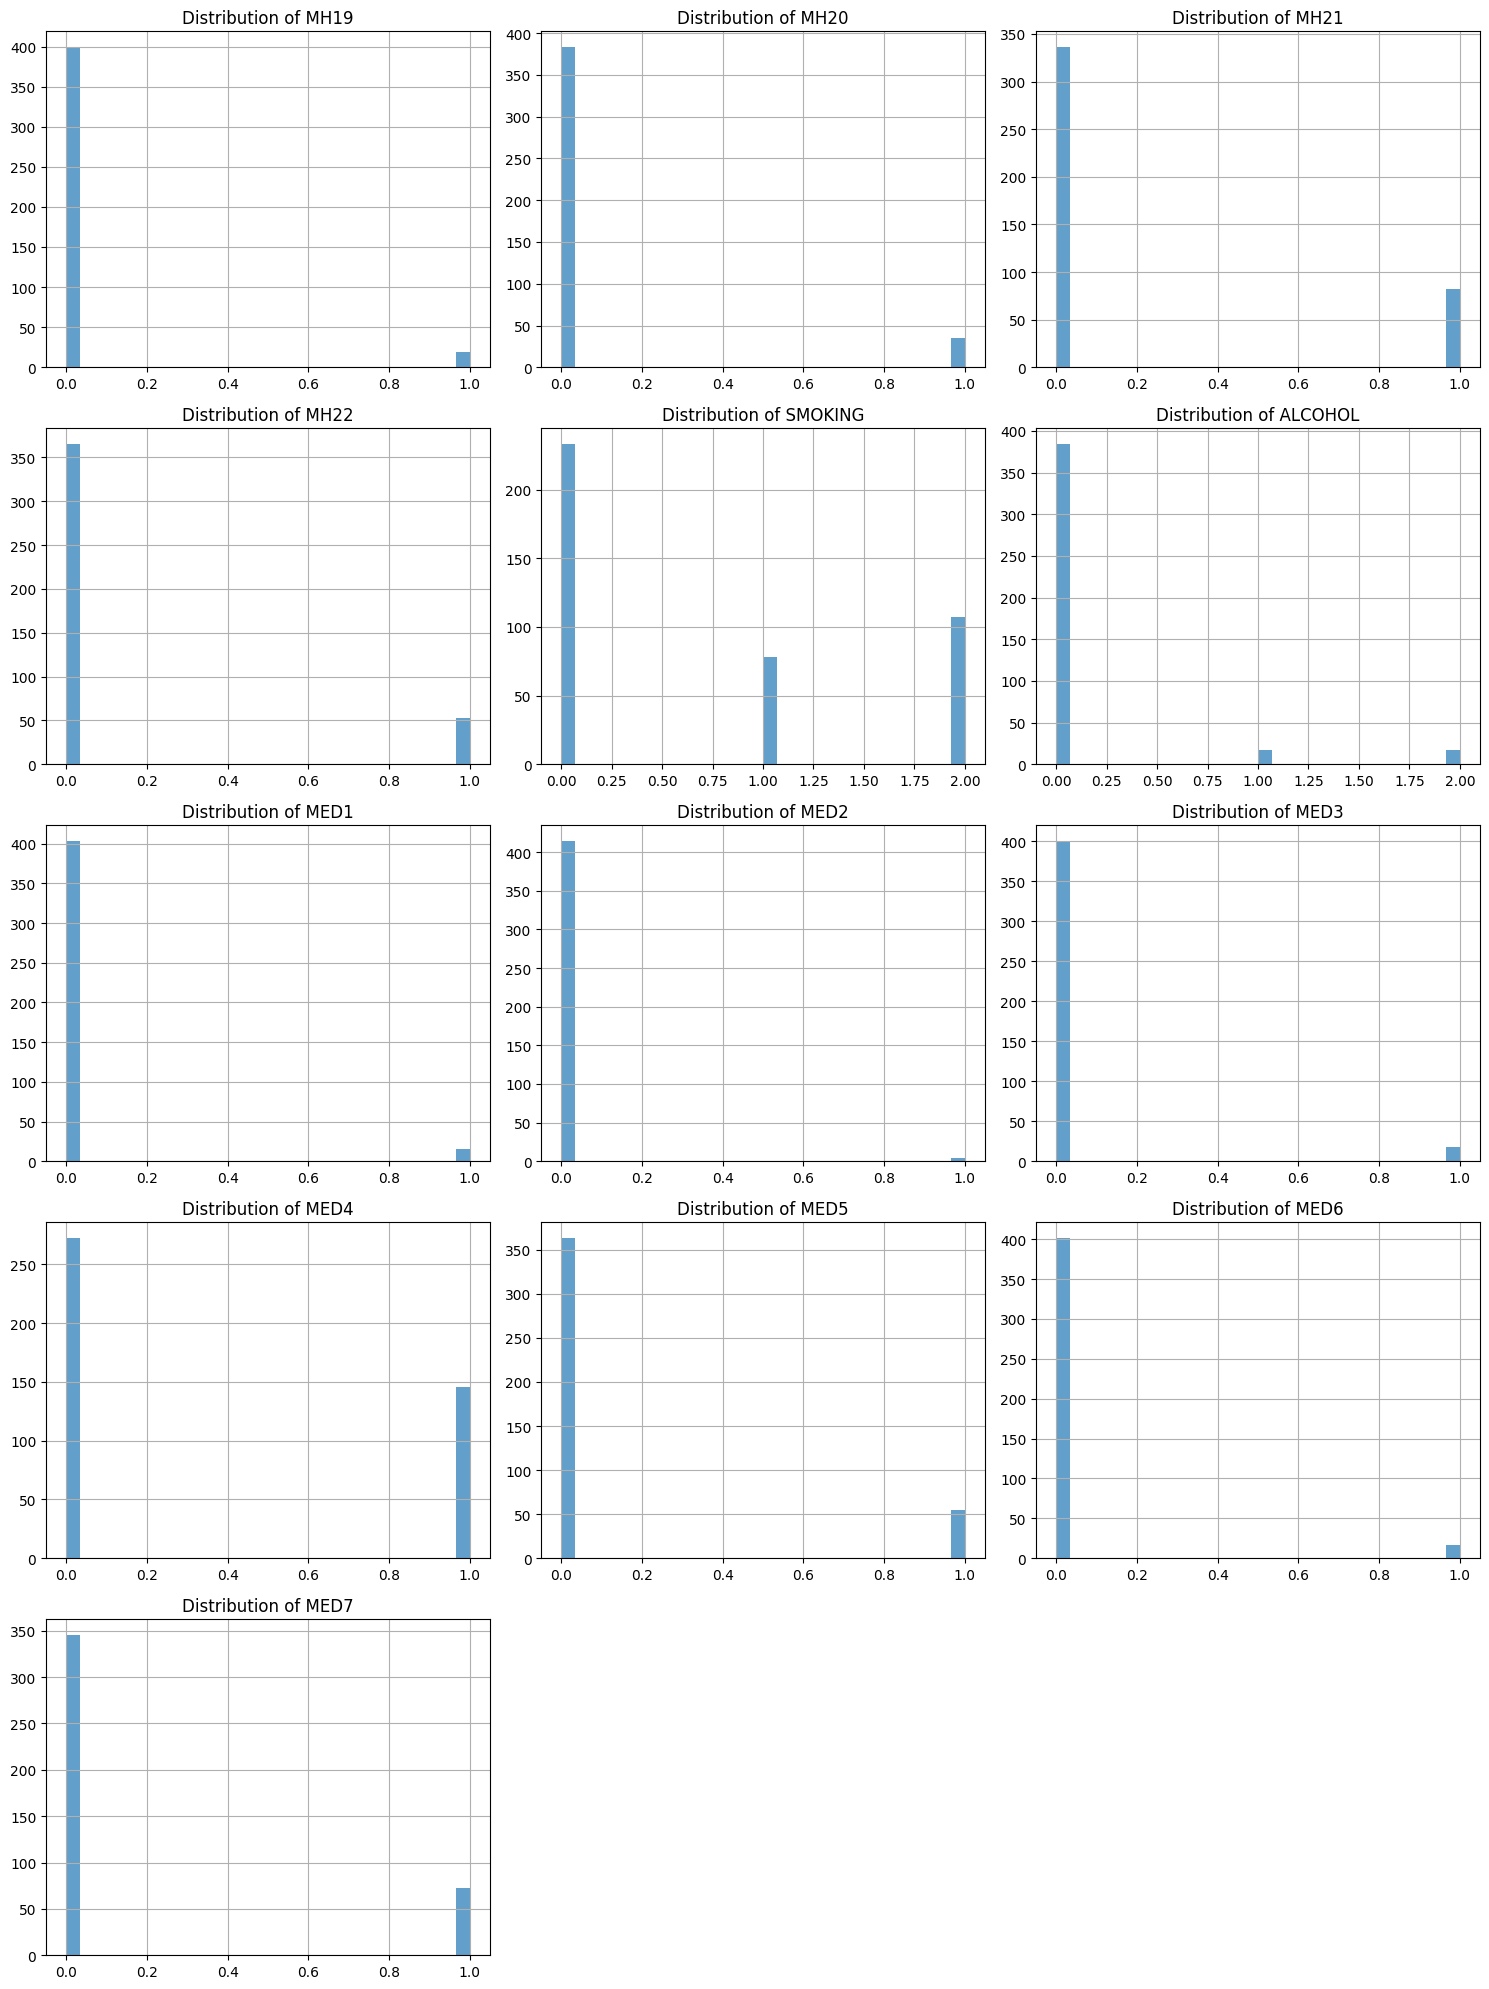

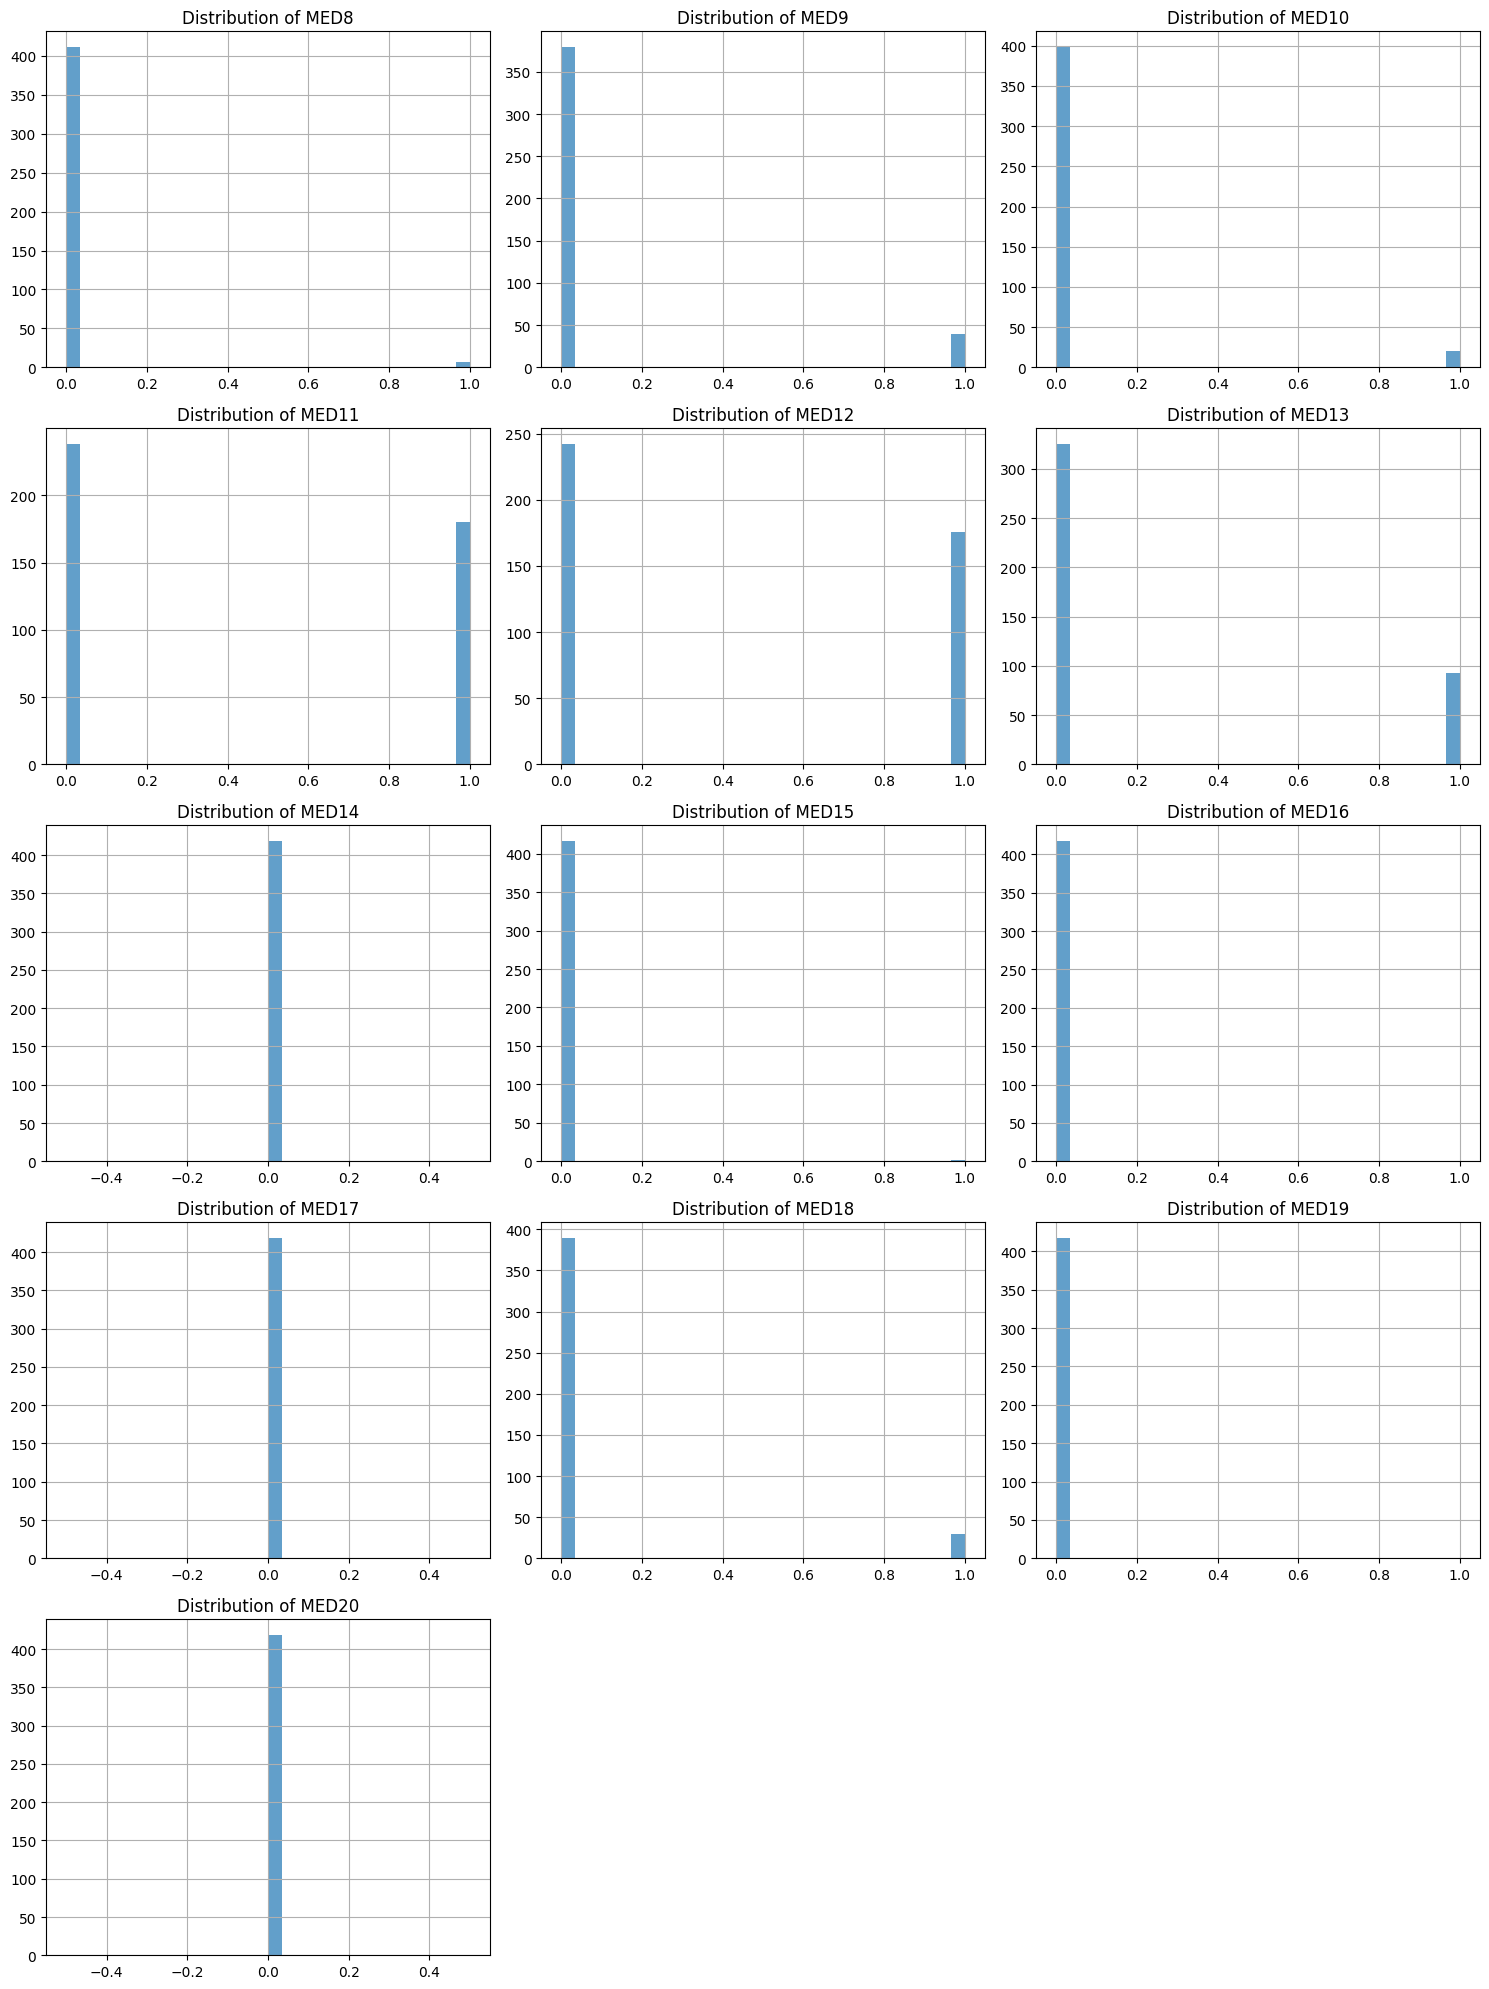

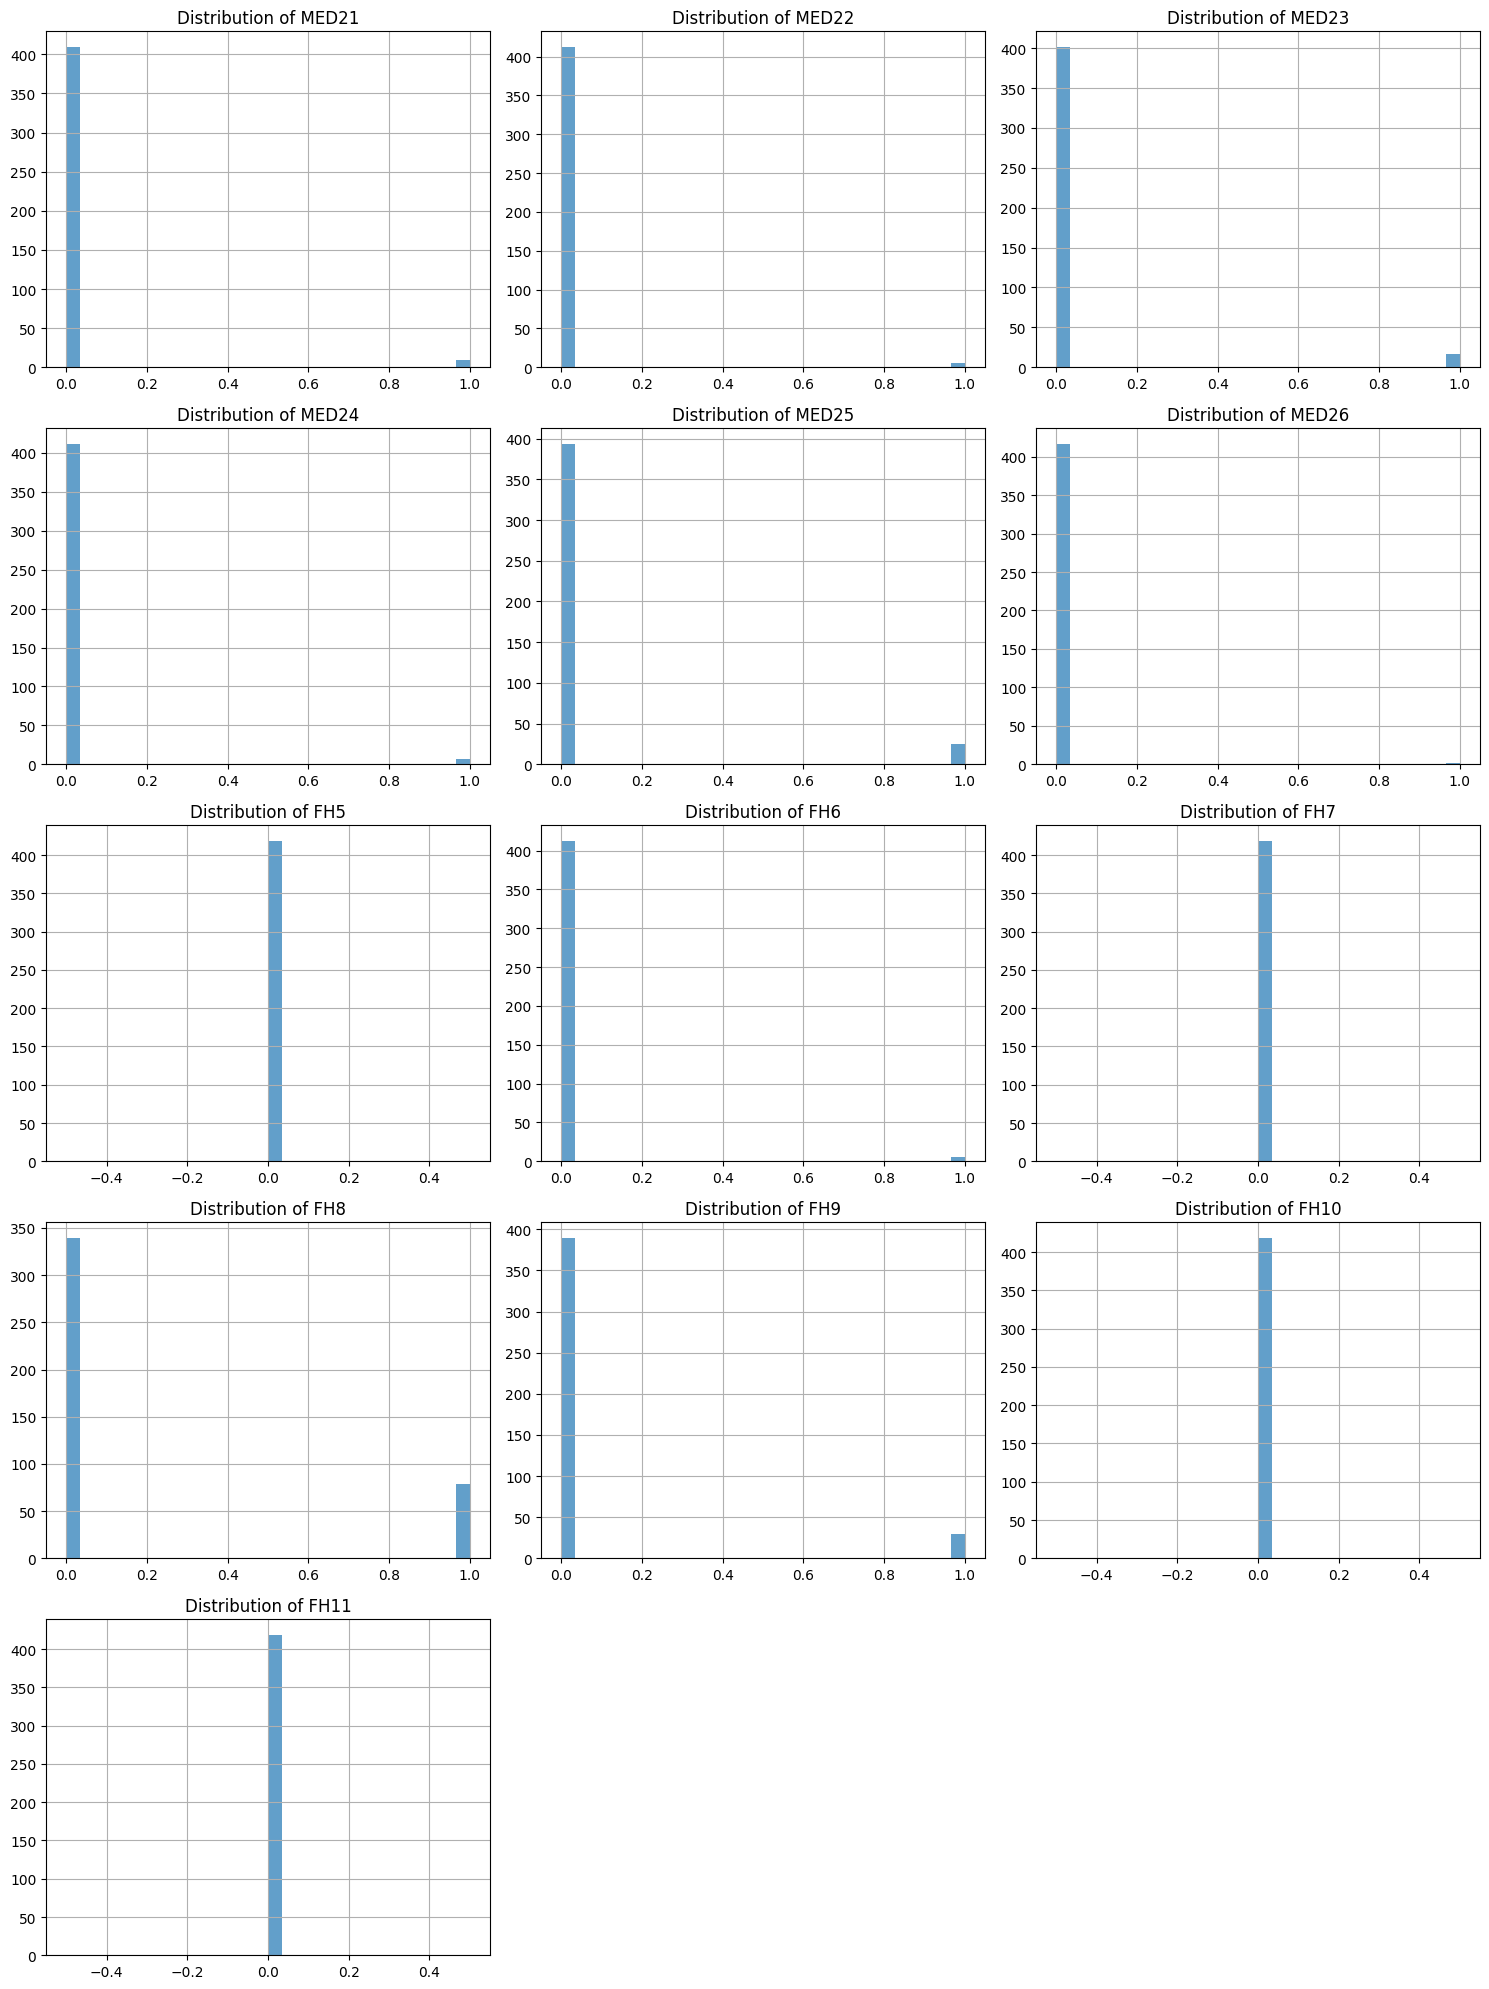

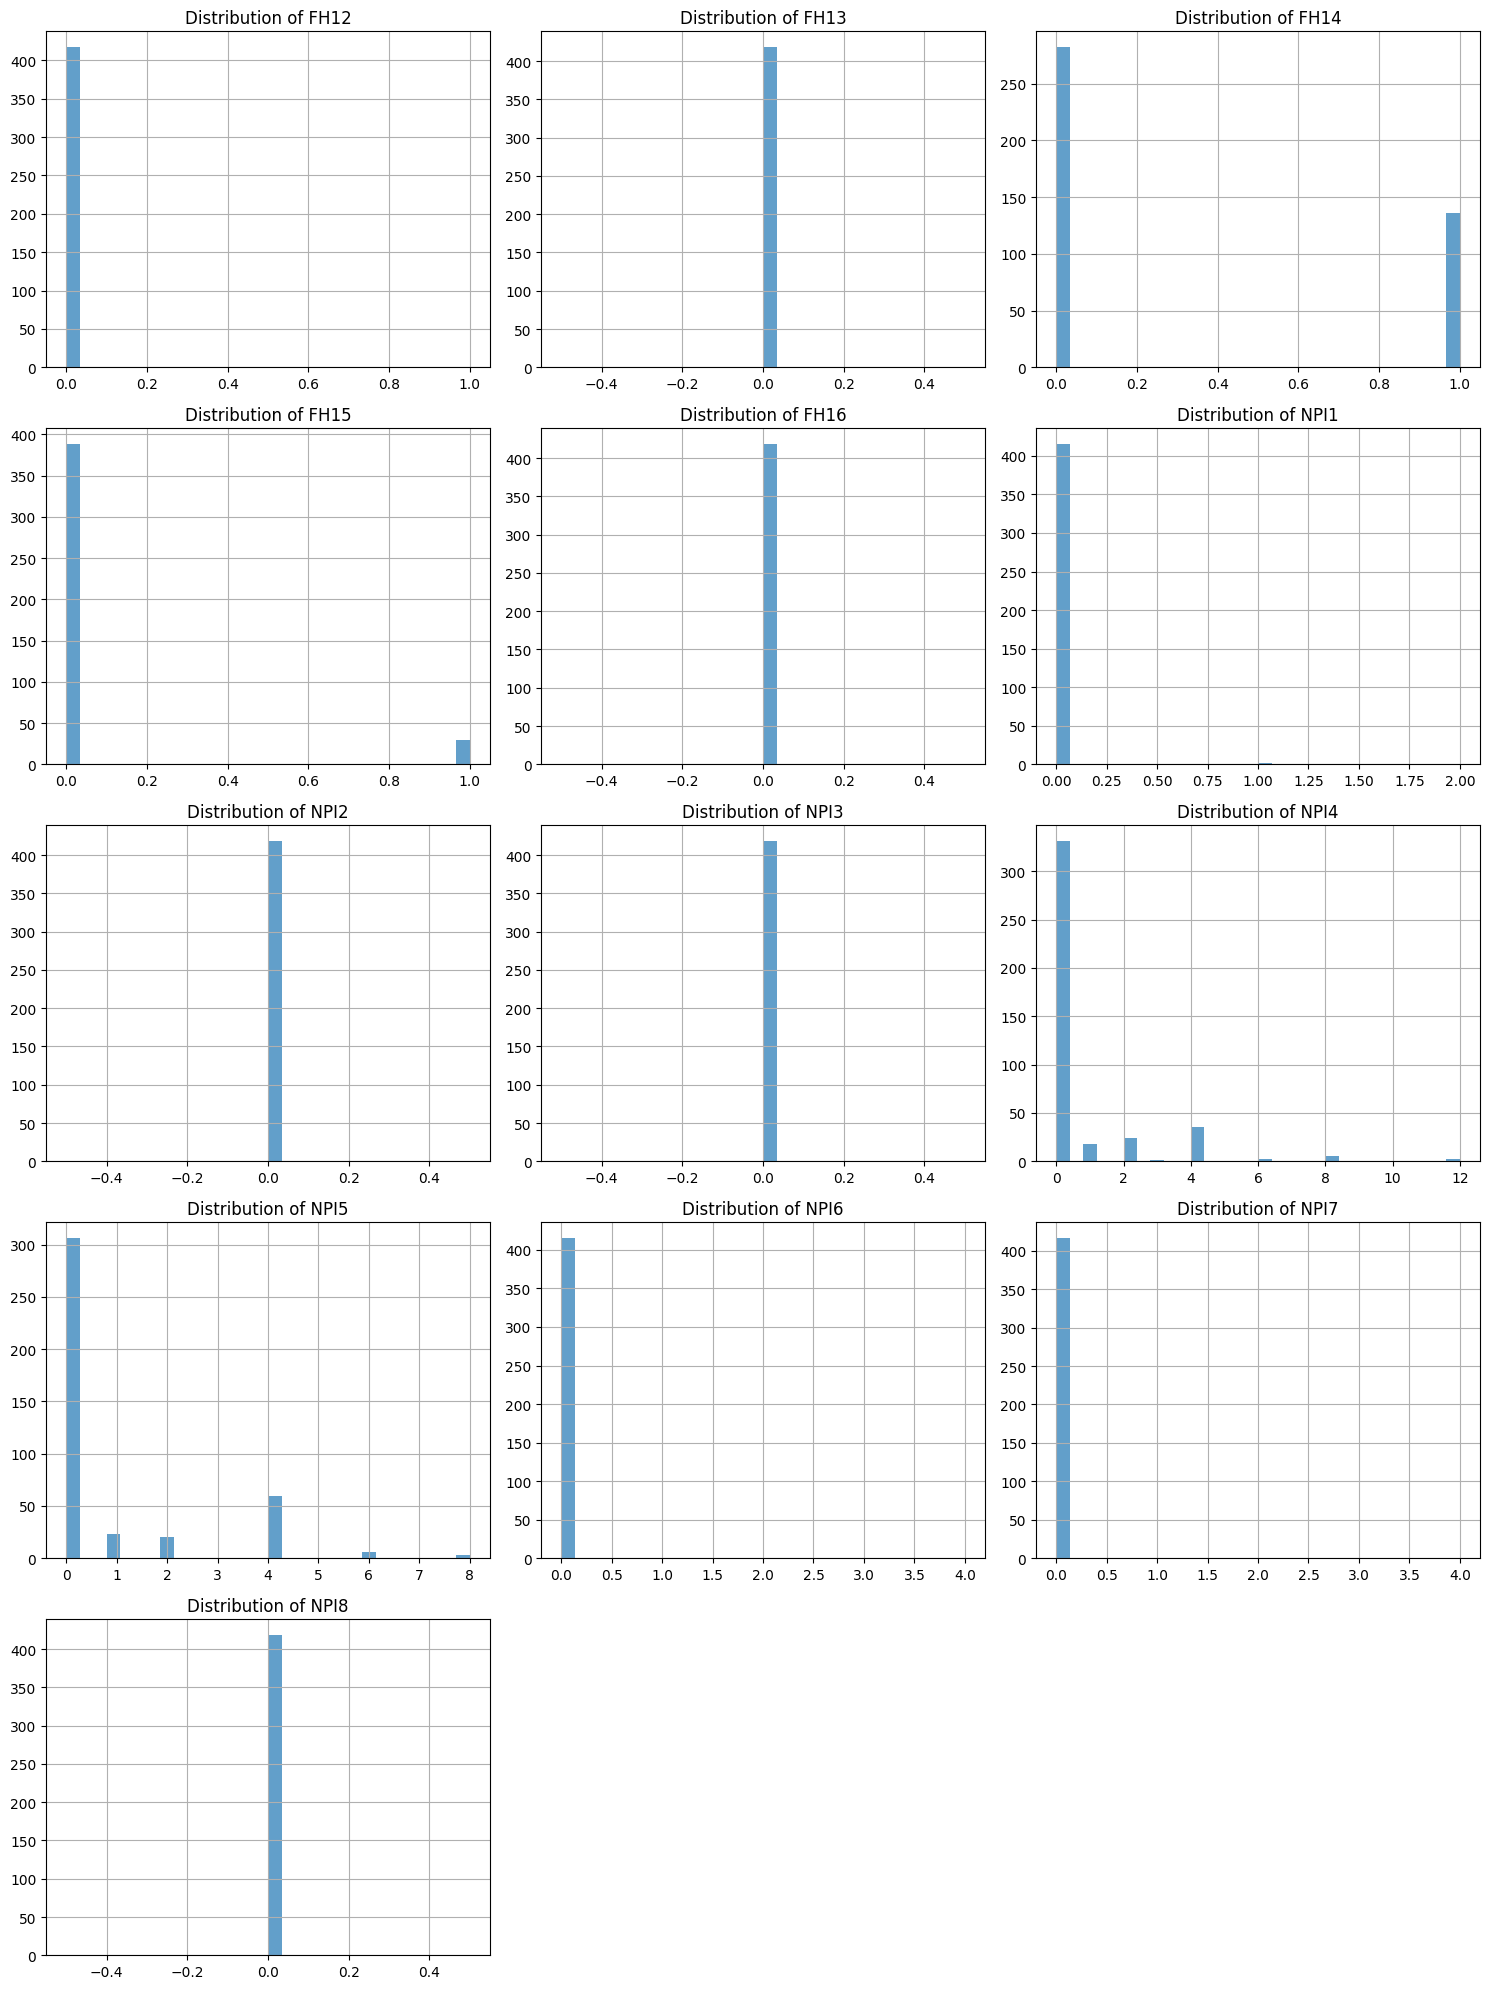

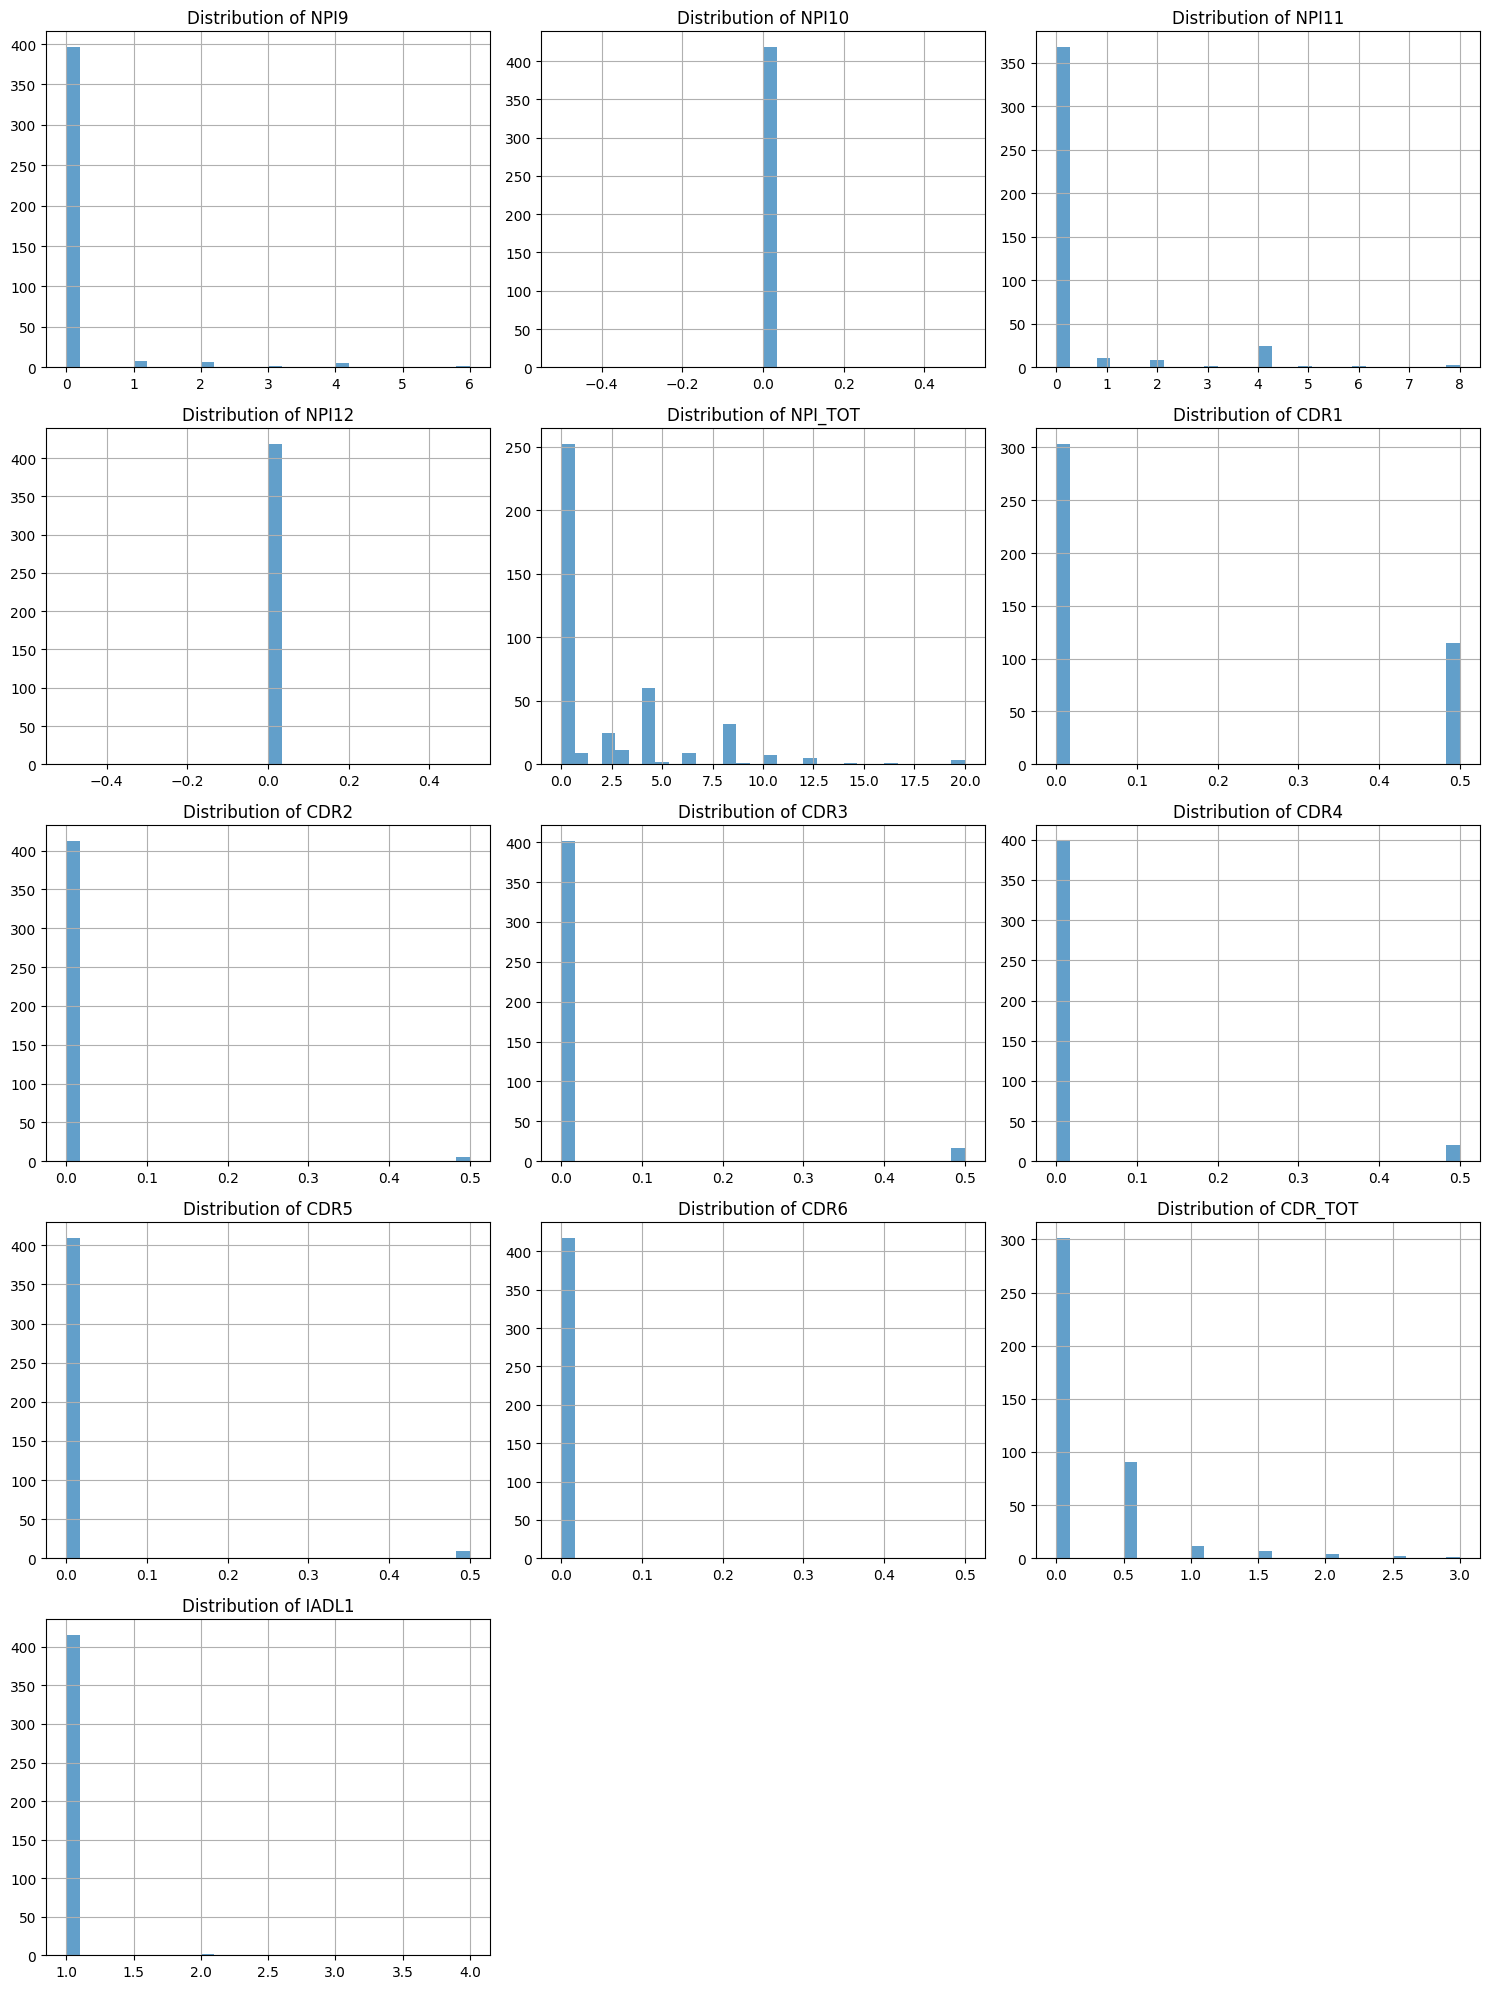

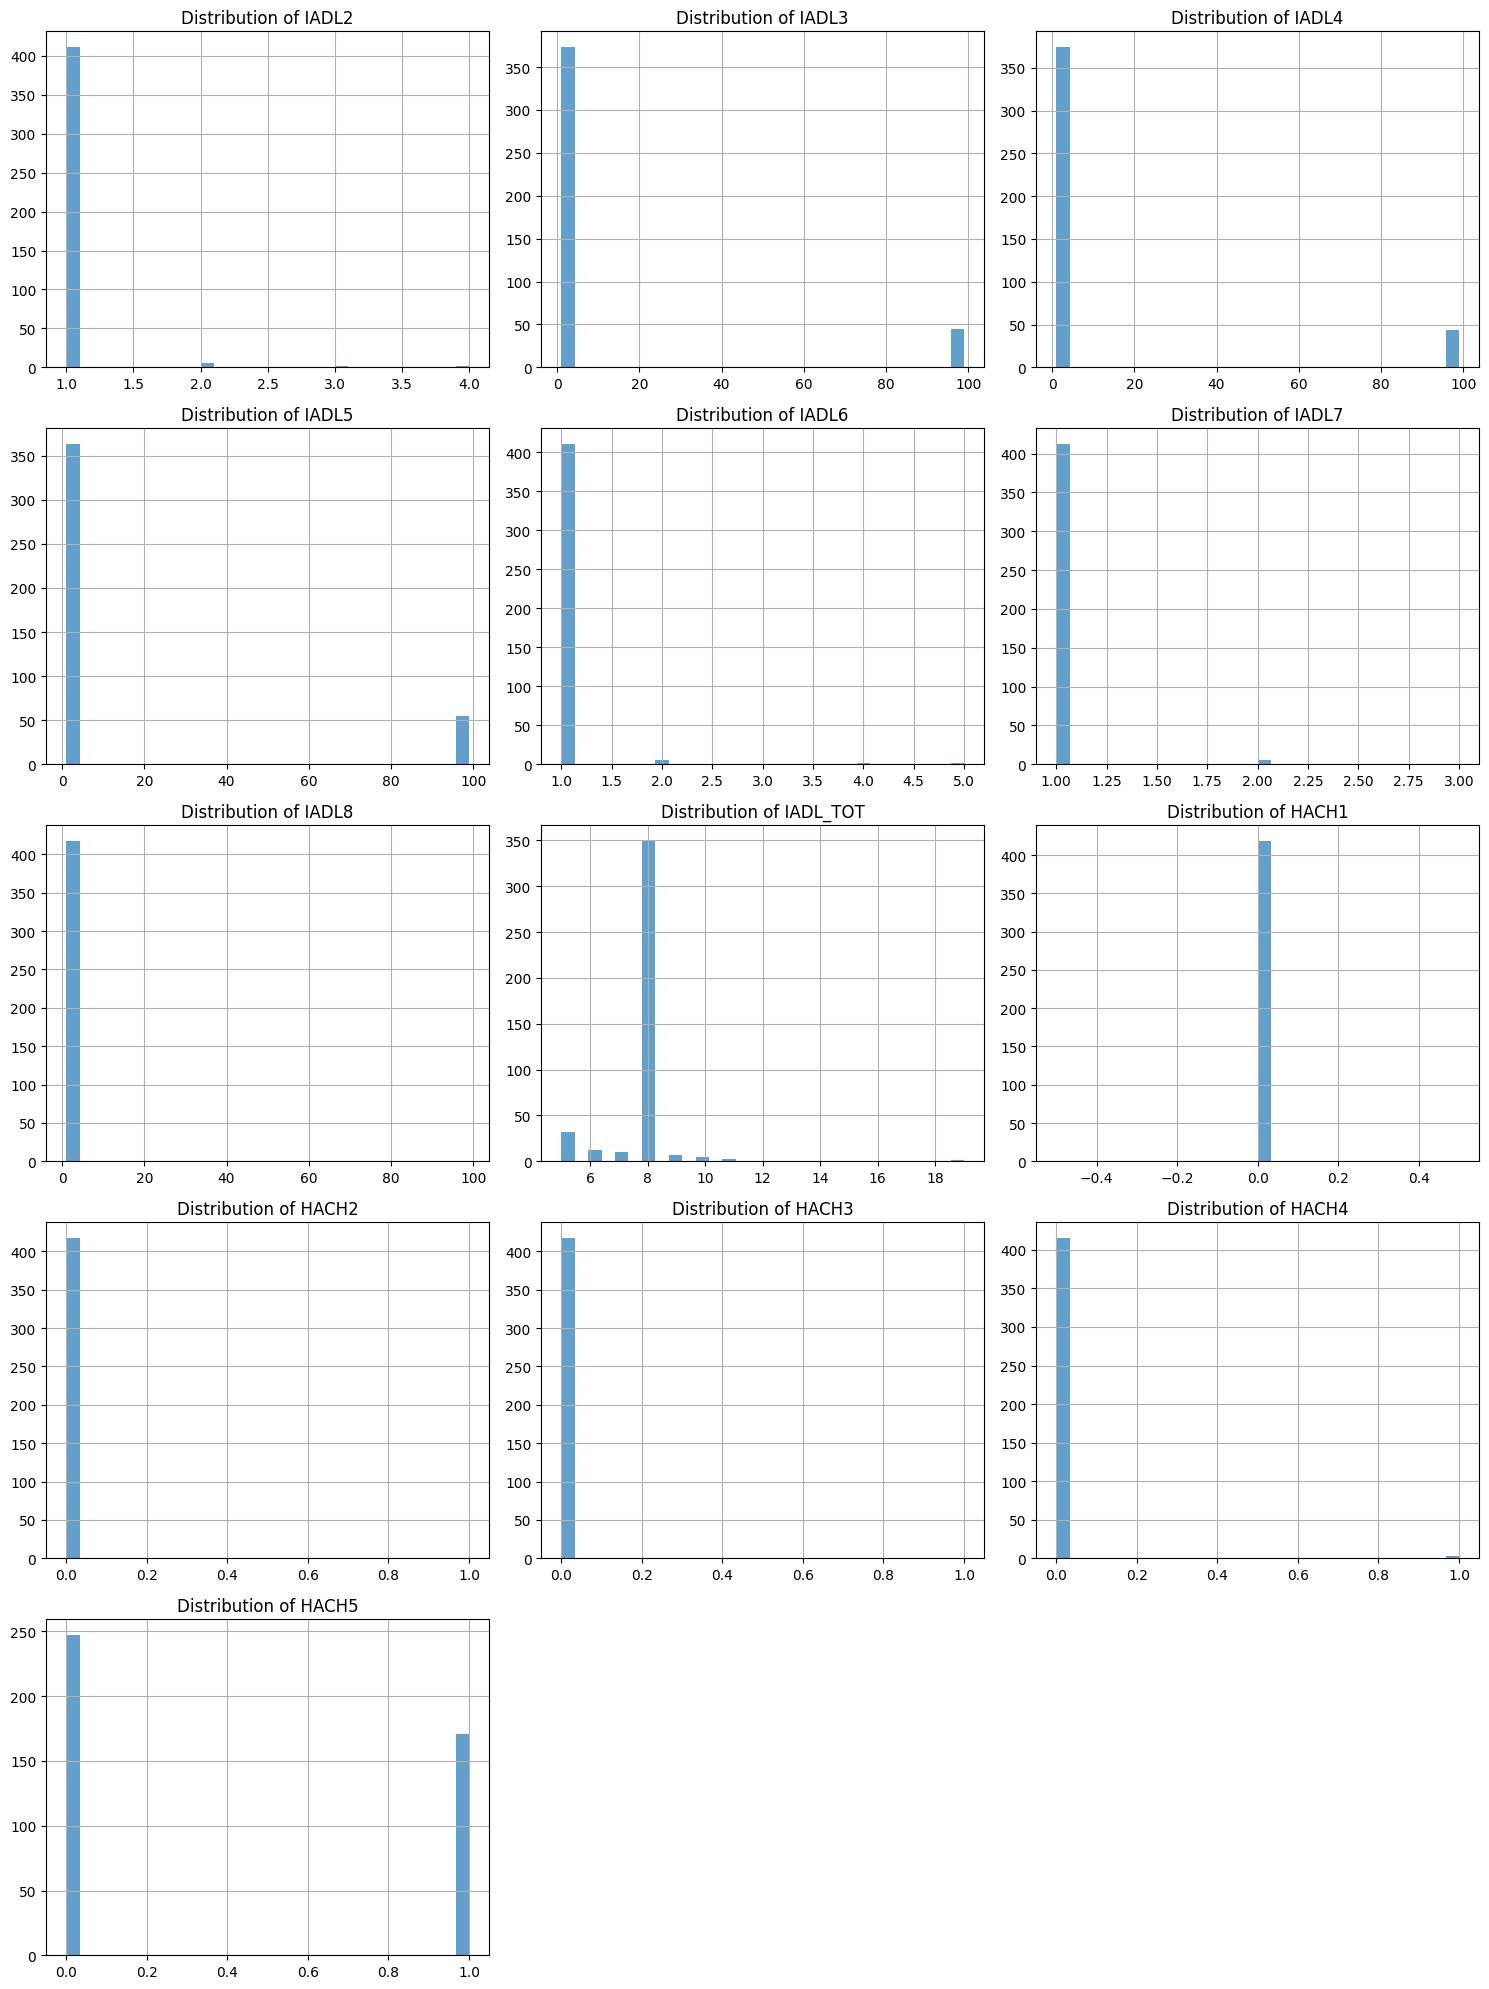

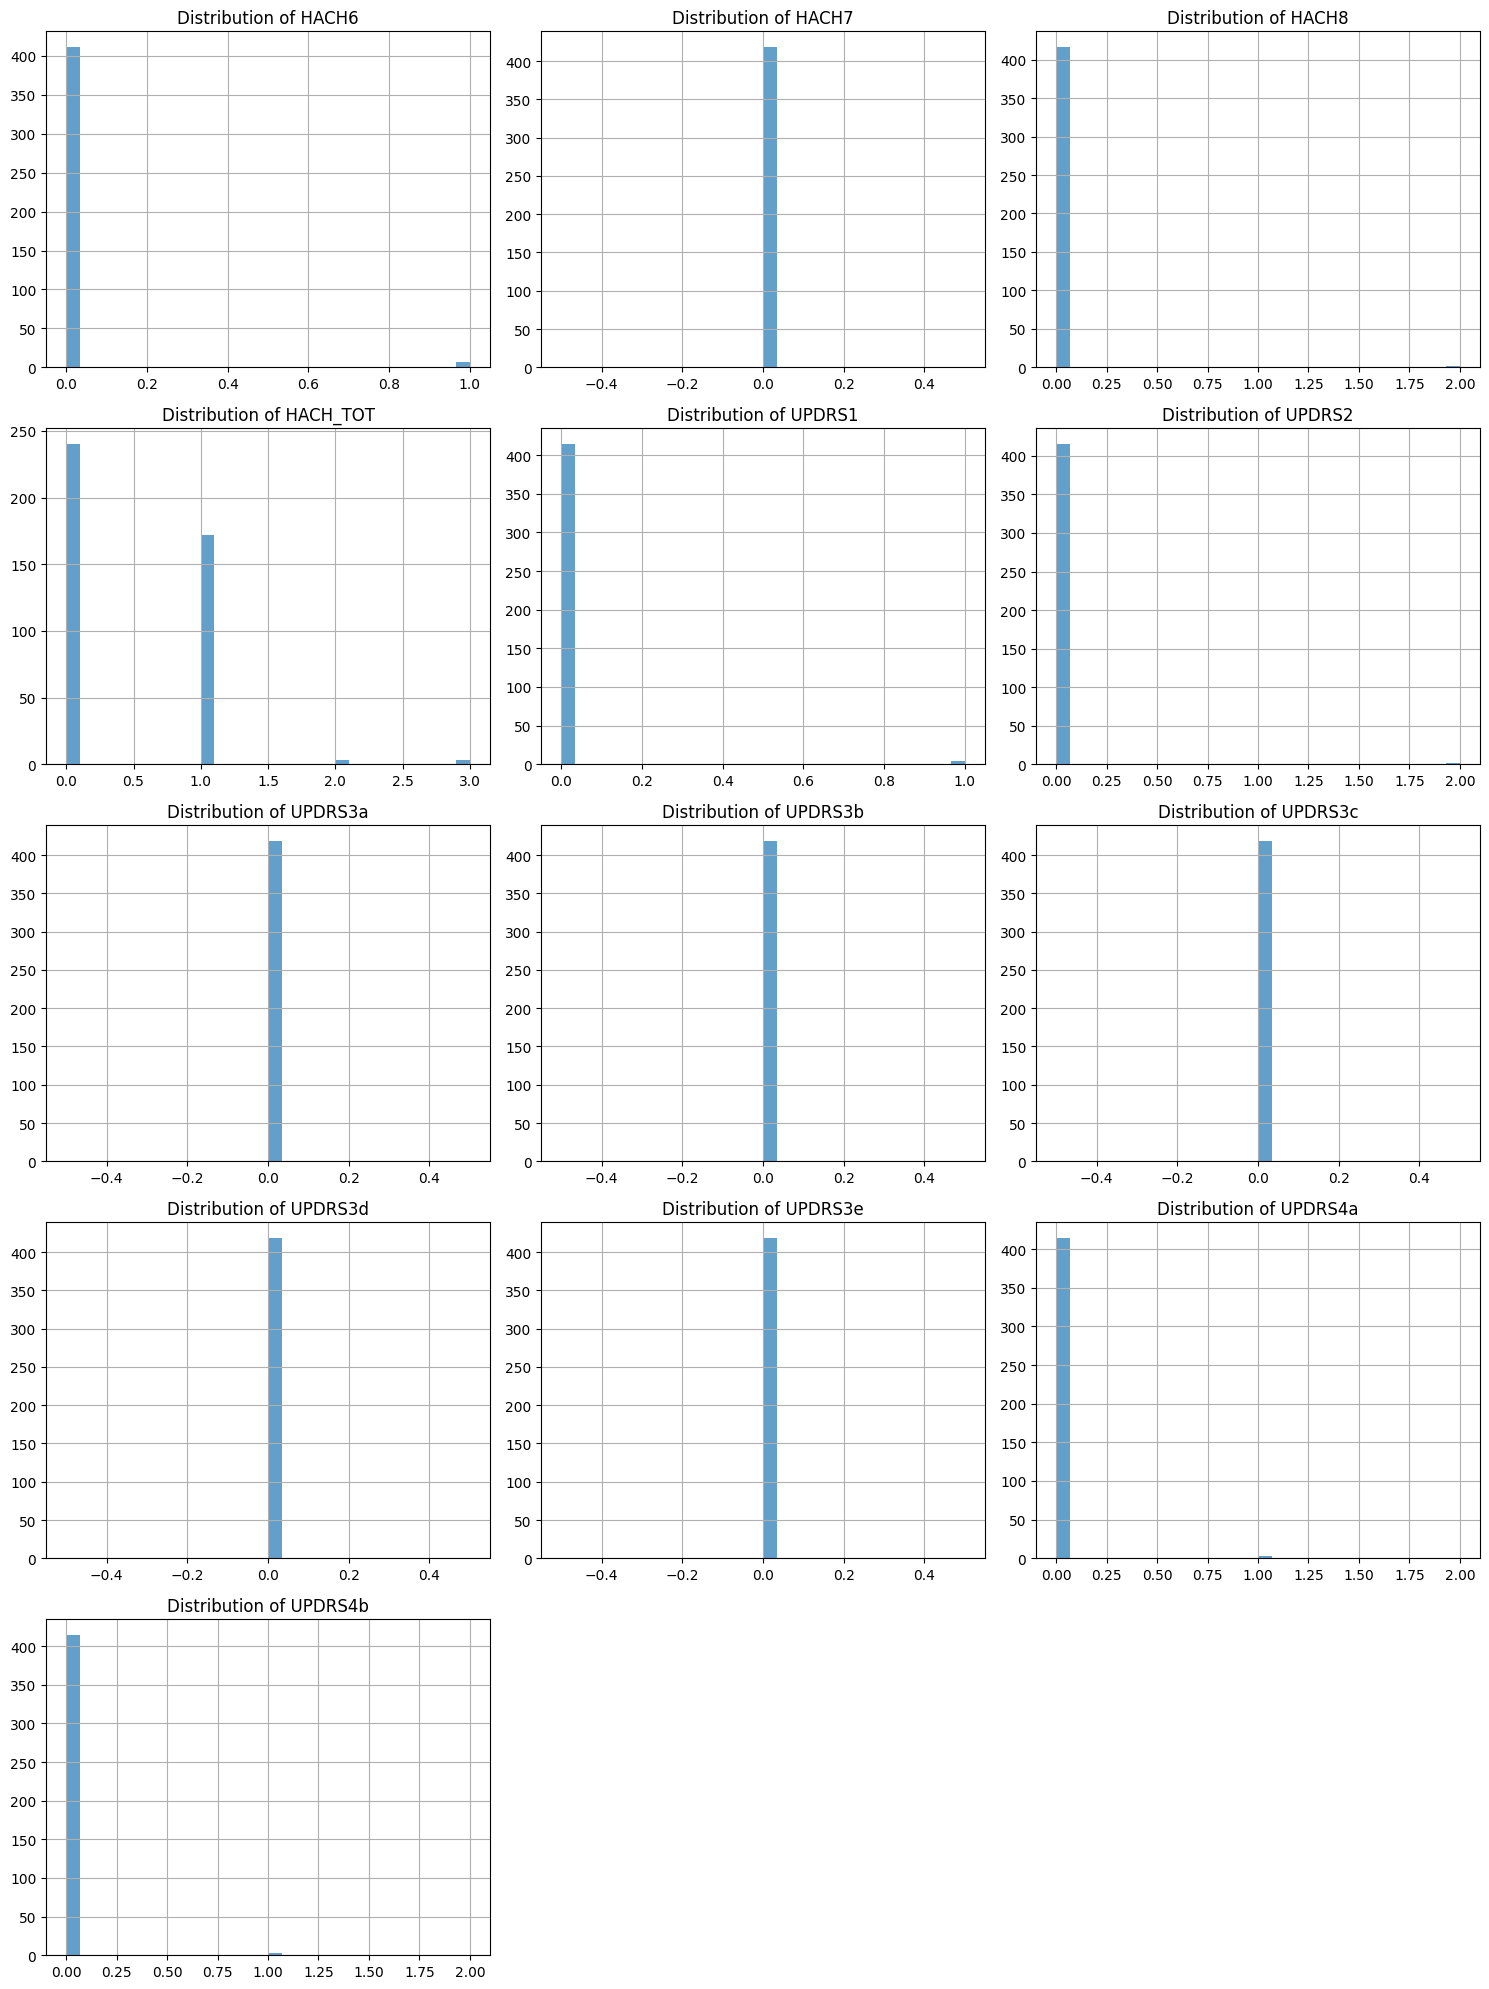

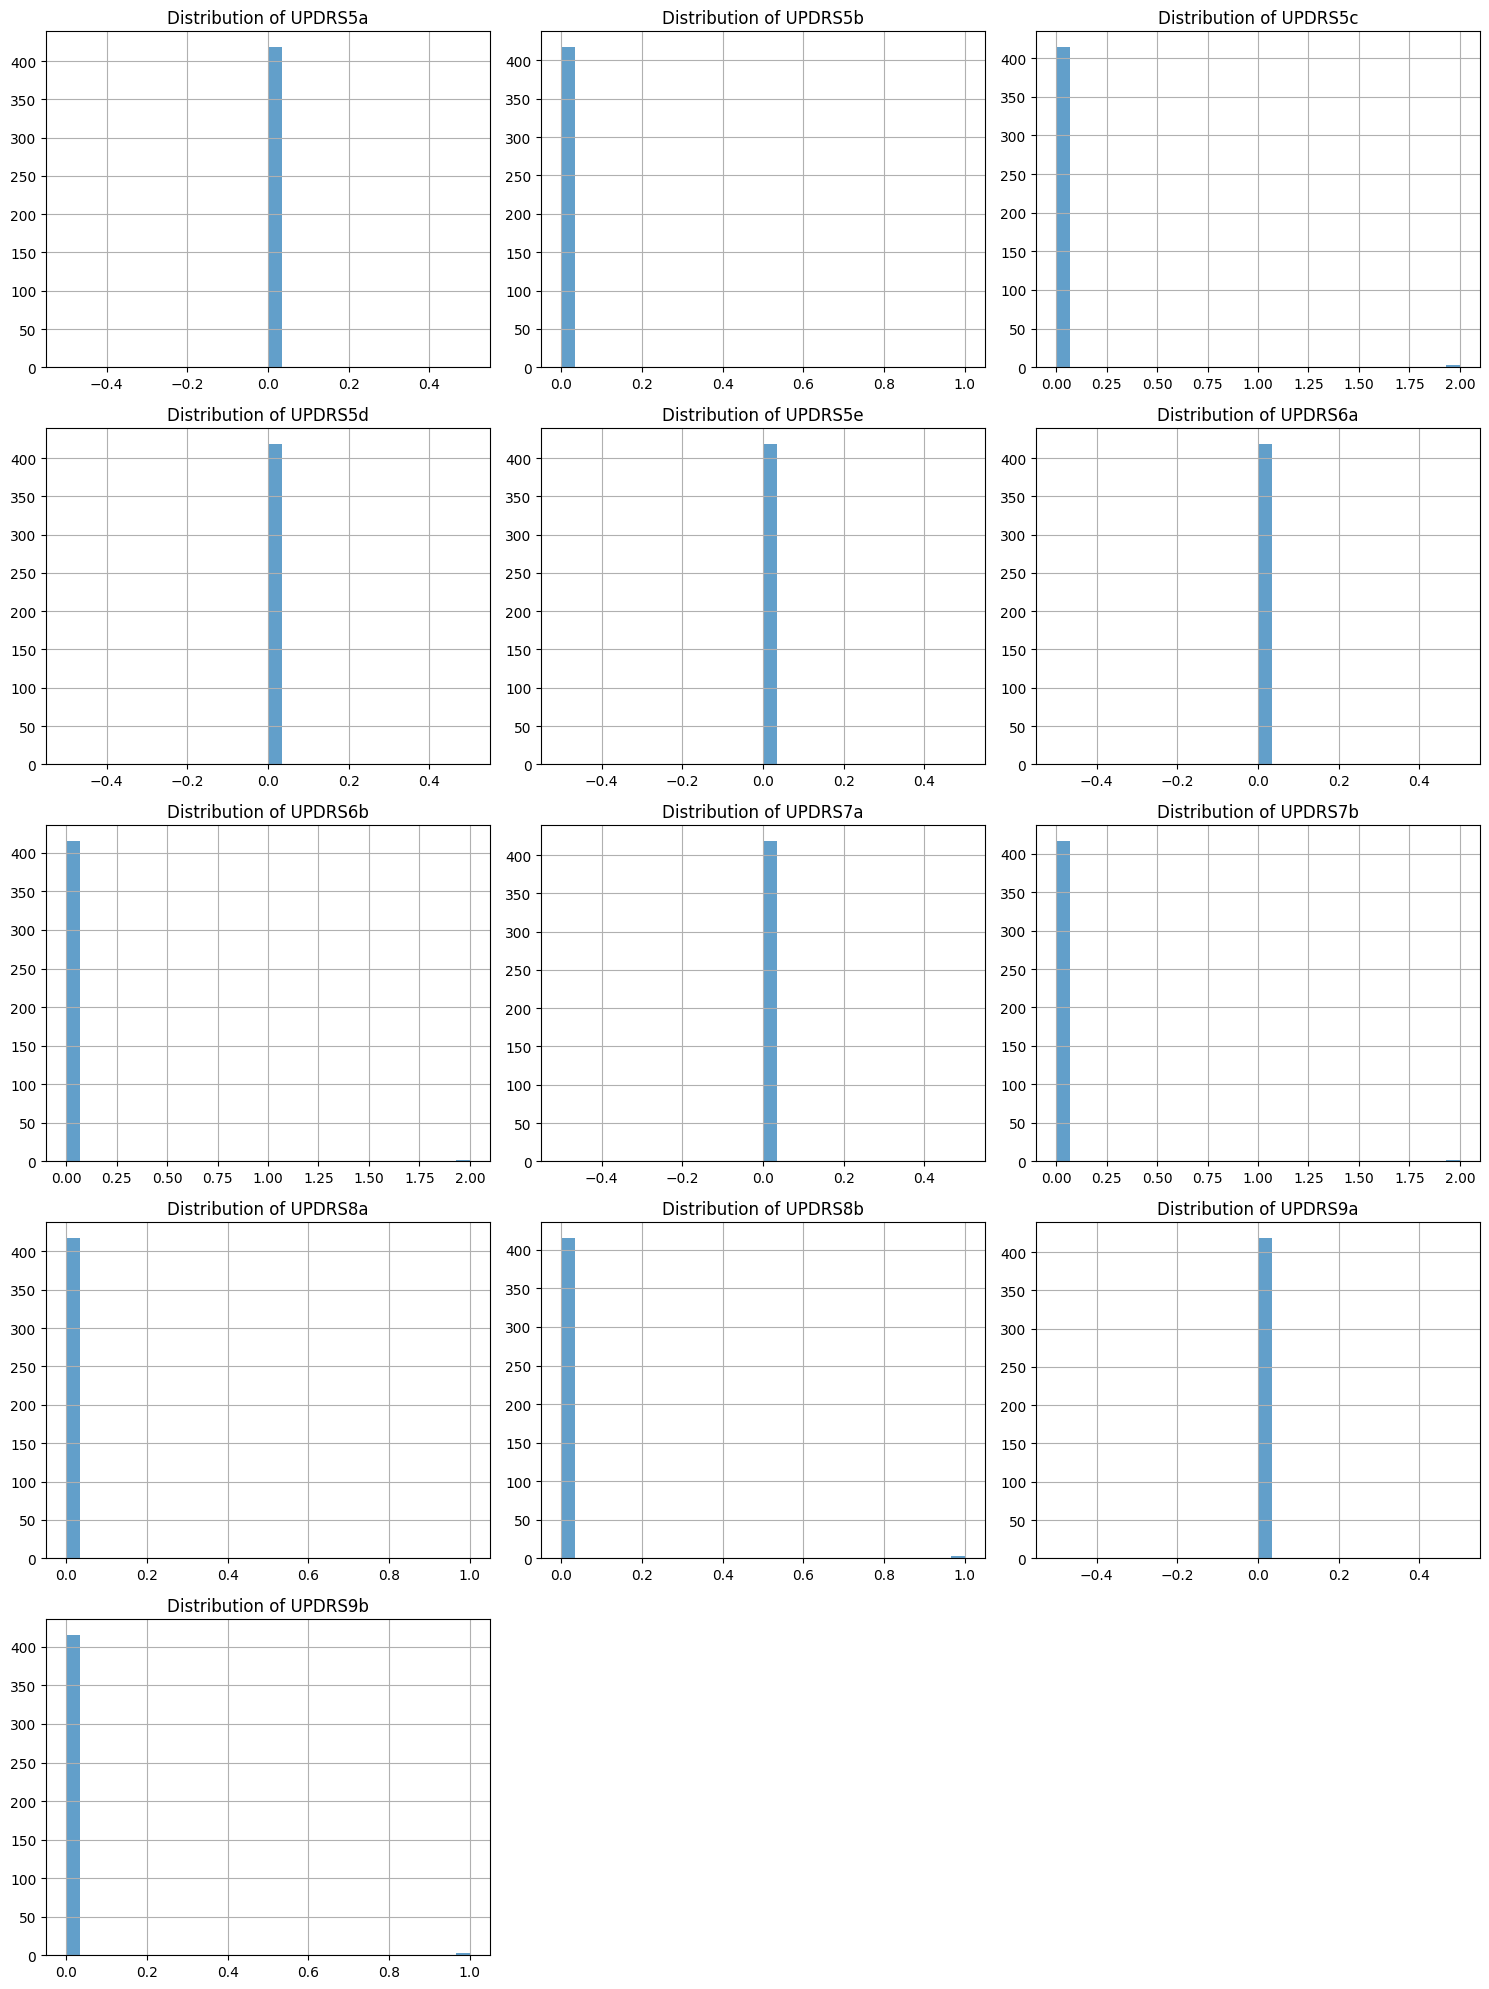

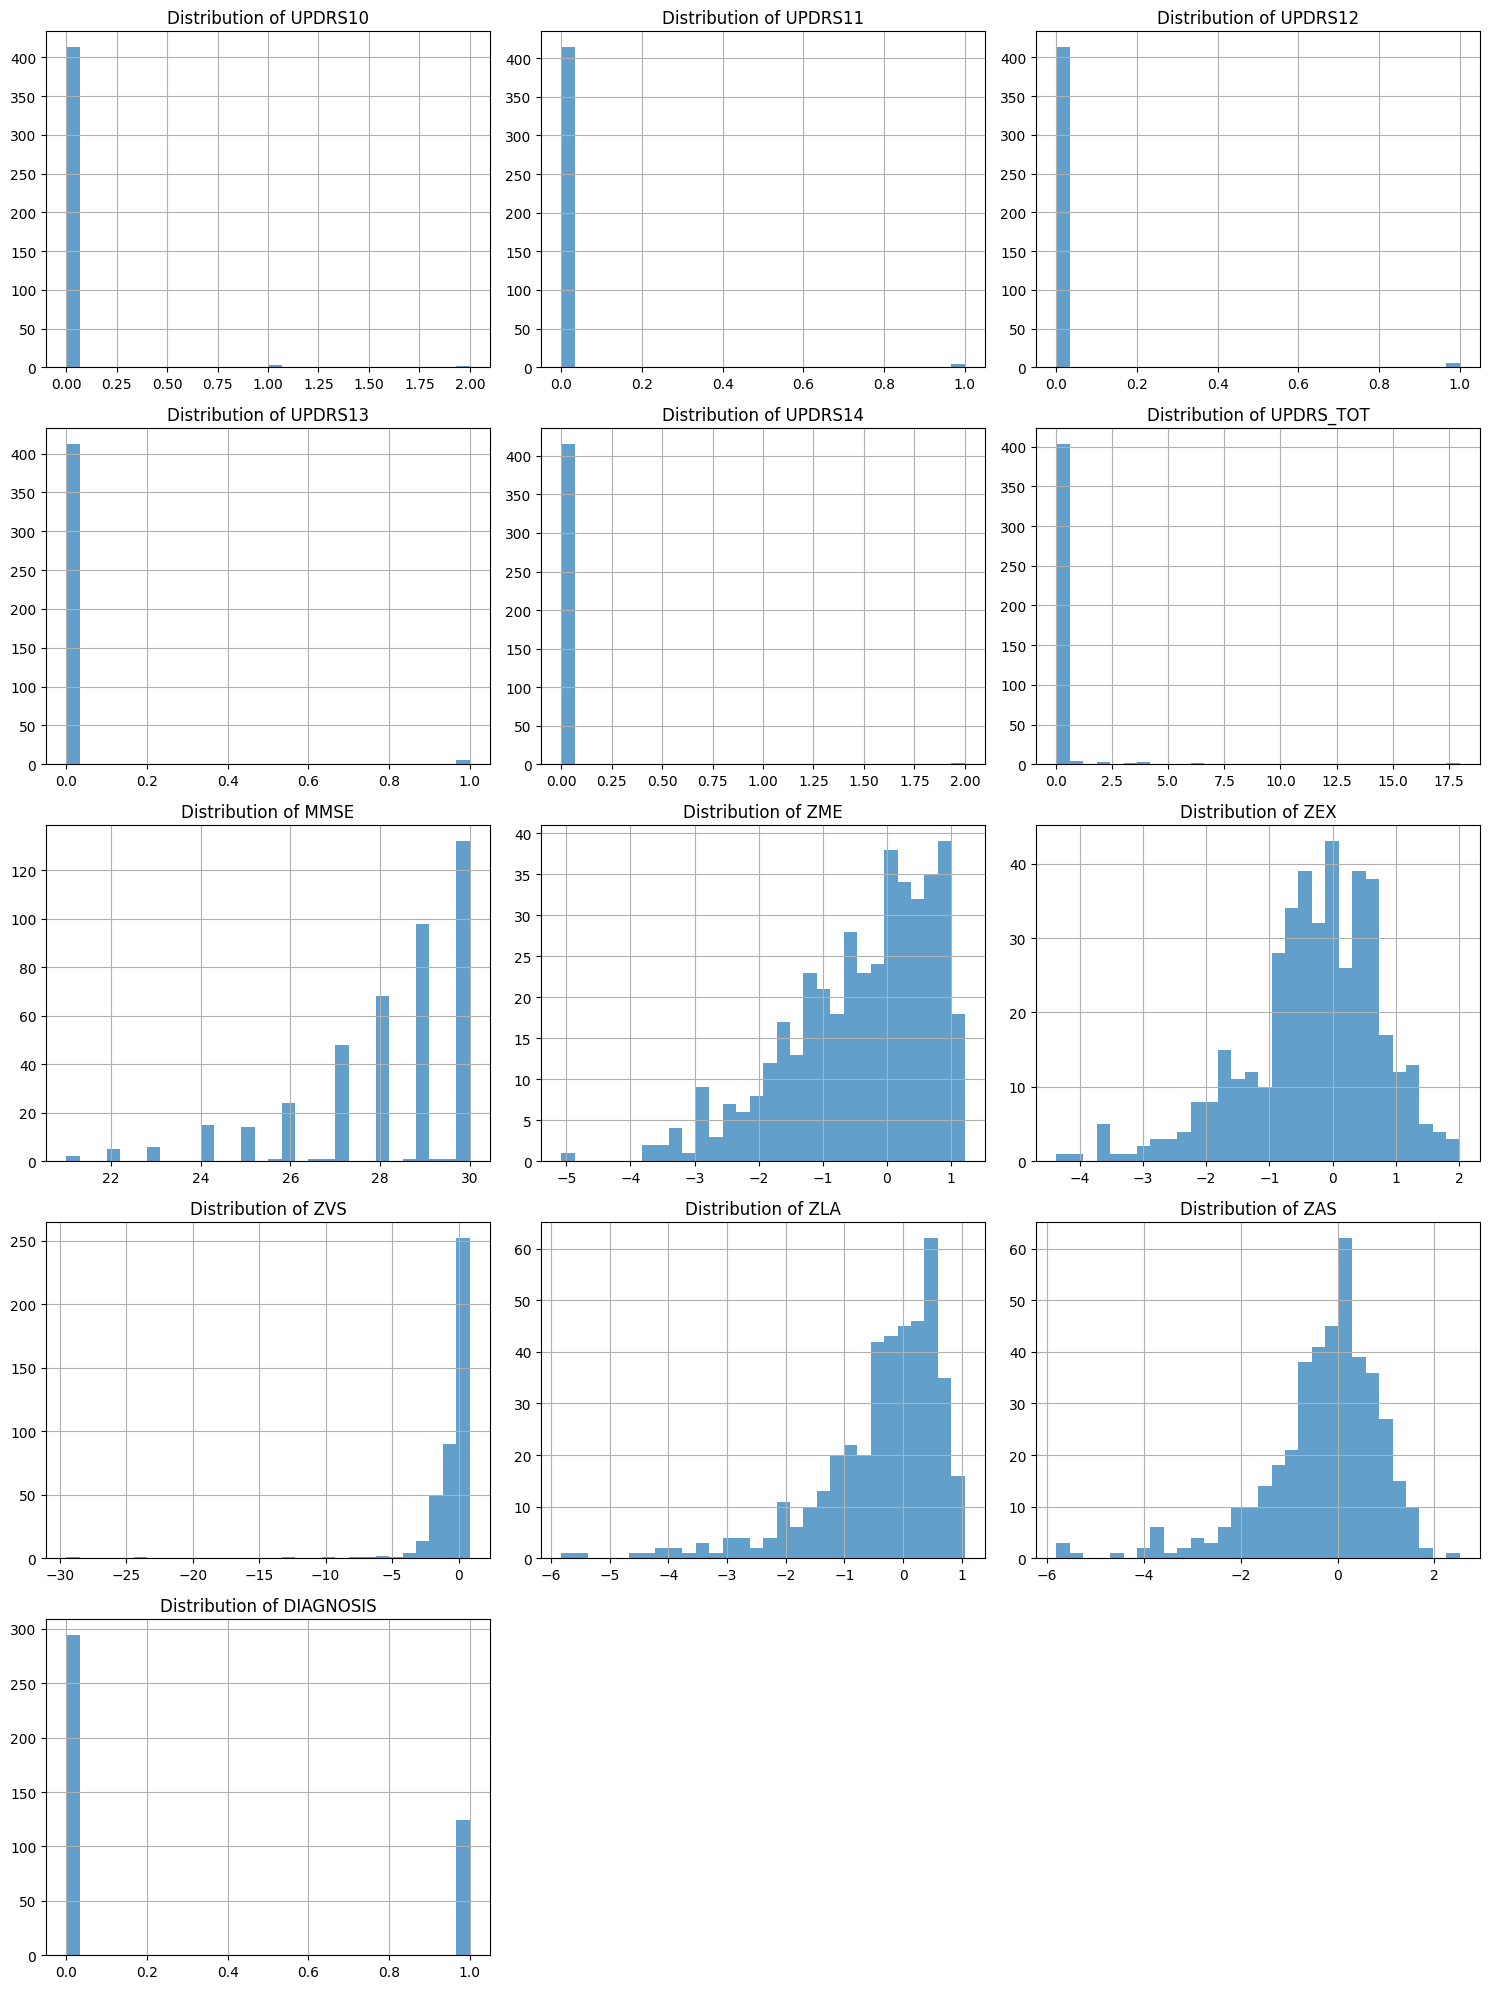

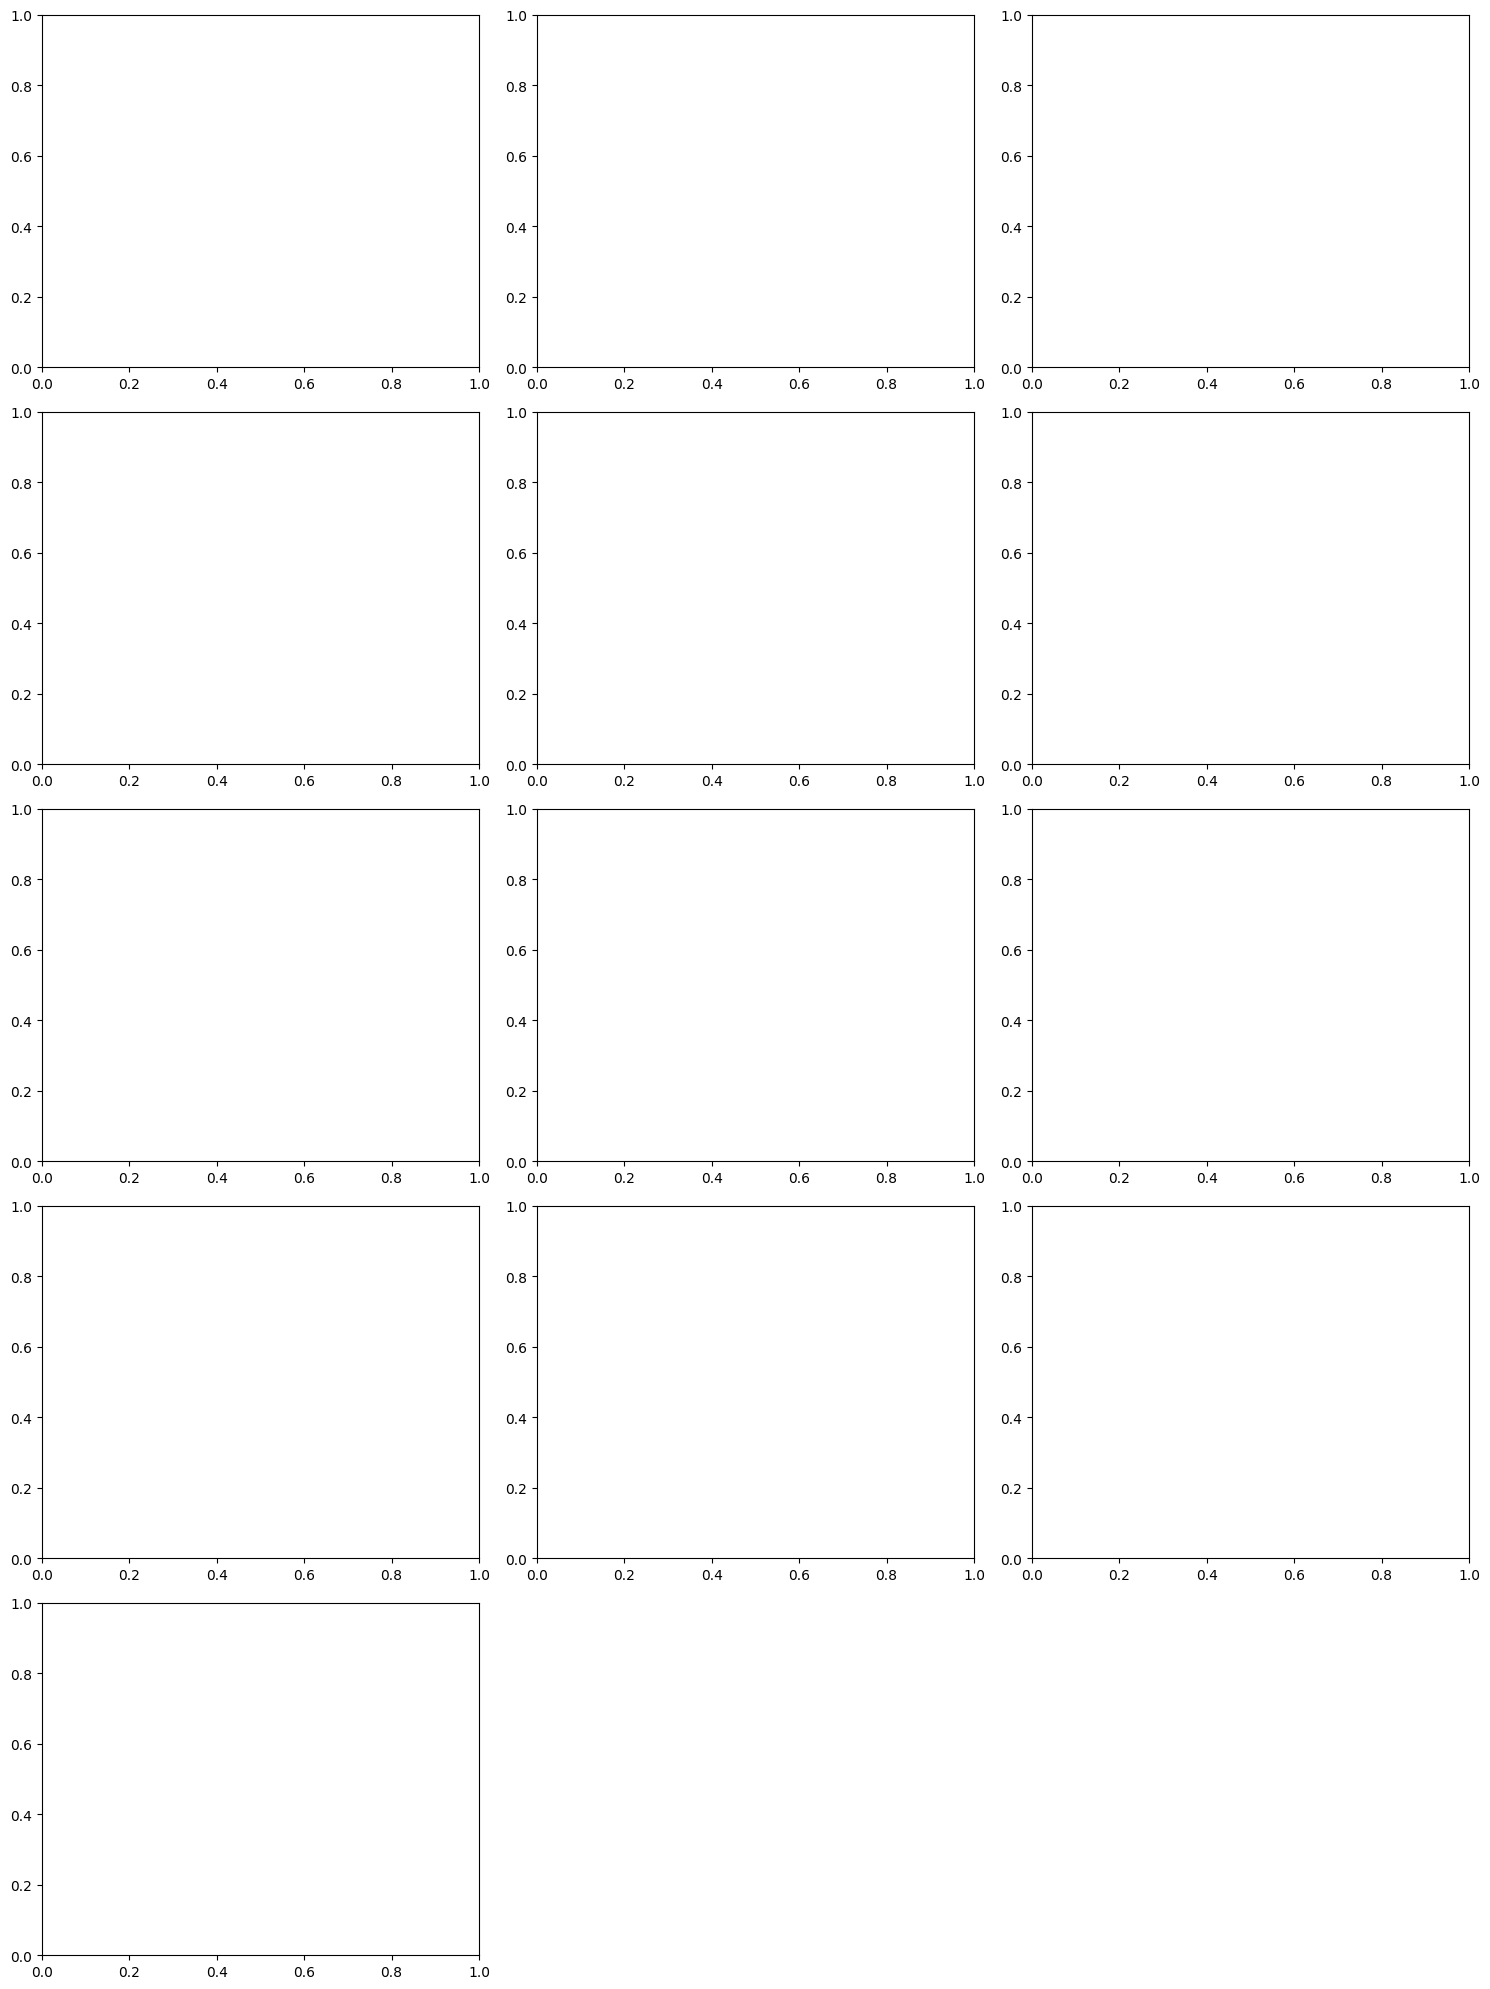

In [23]:
# Set the number of features per figure to 13
features_per_plot = 13
num_features = train_df.shape[1]
num_chunks = (num_features // features_per_plot) + 1

# Loop through features in chunks
for chunk in range(num_chunks):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows and 3 columns for 13 plots (1 will be empty)
    axes = axes.ravel()

    start_idx = chunk * features_per_plot
    end_idx = min((chunk + 1) * features_per_plot, num_features)

    for i, feature in enumerate(train_df.columns[start_idx:end_idx]):
        train_df[feature].hist(ax=axes[i], bins=30, alpha=0.7)
        axes[i].set_title(f'Distribution of {feature}')
    
    # Hide any extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [24]:
# Loop through all numerical columns to compare distributions using KS test for the train data
for column in train_df.columns:
    if train_df[column].dtype in ['float64', 'int64']:  # Apply only to numerical columns
        # Drop missing values from the original dataset
        original_data = train_df_copy[column].dropna()
        # Select only the imputed values (rows where original data had NaNs)
        imputed_data = train_df[column][train_df_copy[column].isna()]  

        if len(original_data) > 0 and len(imputed_data) > 0:  # Ensure both datasets are not empty
            # Perform the KS test
            ks_stat, ks_p_value = ks_2samp(original_data, imputed_data)
            print(f"KS test for {column}: stat={ks_stat}, p-value={ks_p_value}")
        else:
            print(f"Not enough data for column: {column}")


Not enough data for column: ID
Not enough data for column: SEX
Not enough data for column: VisitNuA
Not enough data for column: EDU
Not enough data for column: AgeC
KS test for ΜaritalC: stat=0.3981707317073171, p-value=0.12395672213397259
KS test for Living_Arrangement: stat=0.1356901862989585, p-value=0.8845730145561533
KS test for WorkStat: stat=0.30190239867659224, p-value=0.11478864671381128
Not enough data for column: MH1
Not enough data for column: MH2
Not enough data for column: MH3
Not enough data for column: MH4
Not enough data for column: MH5
Not enough data for column: MH6
Not enough data for column: MH7
Not enough data for column: MH8
Not enough data for column: MH9
Not enough data for column: MH10
Not enough data for column: MH11
Not enough data for column: MH12
Not enough data for column: MH13
Not enough data for column: MH14
Not enough data for column: MH15
Not enough data for column: MH16
Not enough data for column: MH17
Not enough data for column: MH18
Not enough data

In [25]:
# Loop through all numerical columns to compare distributions using KS test for the test data
for column in test_df.columns:
    if test_df[column].dtype in ['float64', 'int64']:  # Apply only to numerical columns
        # Drop missing values from the original dataset
        original_data = test_df_copy[column].dropna()
        # Select only the imputed values (rows where original data had NaNs)
        imputed_data = test_df[column][test_df_copy[column].isna()]  

        if len(original_data) > 0 and len(imputed_data) > 0:  # Ensure both datasets are not empty
            # Perform the KS test
            ks_stat, ks_p_value = ks_2samp(original_data, imputed_data)
            print(f"KS test for {column}: stat={ks_stat}, p-value={ks_p_value}")
        else:
            print(f"Not enough data for column: {column}")


Not enough data for column: ID
Not enough data for column: SEX
Not enough data for column: VisitNuA
Not enough data for column: EDU
Not enough data for column: AgeC
KS test for ΜaritalC: stat=0.38144329896907214, p-value=0.5205459321442346
KS test for Living_Arrangement: stat=0.21768707482993196, p-value=0.9945994599459946
KS test for WorkStat: stat=0.3625, p-value=0.45519588777729025
Not enough data for column: MH1
Not enough data for column: MH2
Not enough data for column: MH3
Not enough data for column: MH4
Not enough data for column: MH5
Not enough data for column: MH6
Not enough data for column: MH7
Not enough data for column: MH8
Not enough data for column: MH9
Not enough data for column: MH10
Not enough data for column: MH11
Not enough data for column: MH12
Not enough data for column: MH13
Not enough data for column: MH14
Not enough data for column: MH15
Not enough data for column: MH16
Not enough data for column: MH17
Not enough data for column: MH18
Not enough data for column:

In [26]:
train_df_copy.to_csv('../data/train_df_NON_imputed_allvisit.csv', index=False)
test_df_copy.to_csv('../data/test_df_NON_imputed_allvisit.csv', index=False)